# From Clouds to Nodes to Blobs

J. A Hernando, M. Pérez

March 2022

In [1]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import nana.bclouds.bclouds      as bc
#import hipy.hfit         as hfit

import clouds.utils     as clut
import clouds.clouds    as cl
import clouds.graphs    as graphs
import clouds.pltclouds as pltclouds
import networkx         as nx

import clouds.mc_clouds as mcclouds

import invisible_cities.io.dst_io as dio

In [4]:
from utils.plotting_utils import plot_cloud_voxels, plot_cloud_voxels_and_hits, plot_3d_hits

In [5]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Fri Apr  8 11:45:56 2022


In [6]:
#import os
import re
import glob

## Code

In [7]:
def draw_event(clouds, cells, bins, ehits):
    %matplotlib notebook
    cells_select = cl.cells_select
    plt.figure(figsize = (8, 8));

    hits = [ehits[name].values for name in ['x', 'y', 'z']]
    
    pltclouds.draw_cloud(cells, bins, clouds);
    ax = plt.gca()
    ax.scatter(*hits, c = 'white', alpha = 0.5);
    start = [x[5] for x in hits]
    ax.scatter(*start, c = 'green', alpha = 1.);
    
    sel = ehits.segclass == 1
    if (np.sum(sel) > 0):
        ohits = [ehits[sel][name].values for name in ['x', 'y', 'z']]
        ax.scatter(*ohits, c = 'grey', alpha = 0.5);
    
    bsel = clouds.segclass == 3
    pltclouds.voxels(cells_select(cells, bsel), bins, alpha = 0.5, color = 'green' , label = 'true');
    return

def draw_graph(graph, glink, enes = None):
    %matplotlib inline
    g = nx.Graph()
    g.add_nodes_from(graph)
    g.add_edges_from(glink)
    enes = enes if enes is not None else np.ones(len(graph))
    nx.draw(g, with_labels = True, node_size = 1e3 * enes, node_color = 'yellow');
    return

In [49]:
def roc(var1, var2, nbins, range, **kargs):
    counts1, bins = np.histogram(var1, nbins, range, density = True)
    ccounts1 = np.cumsum(counts1 * np.diff(bins))
    counts2,  _   = np.histogram(var2, nbins, range, density = True)
    ccounts2 = np.cumsum(counts2 * np.diff(bins))
    xs = 0.4 * (bins[1:] + bins[:-1])
    plt.plot(ccounts1, 1.-ccounts2, **kargs) # sig eff (y) vs bkg rej (x)
    #plt.plot(ccounts2, 1.-ccounts1, **kargs) #  bkg-acc (y) vs eff (x)
    return counts1, counts2, xs

def hist2d_text(xs, ys, bins, ranges,
                  factor = 100, text_format = "{:4.1f} %", offset = 0.3,
                  **kargs):
    h, hxs, hys, im = plt.hist2d(xs, ys, bins, ranges, **kargs);
    ax = plt.gca()
    for i in range(len(hys)-1):
        for j in range(len(hxs)-1):
            ax.text(hxs[j] + offset, hys[i] + offset, 
                    text_format.format(factor * h.T[i,j]))
    return

In [50]:
def hbar(var, vals = ['blob', 'other', 'track', 'unknown'], **kargs):
    counts = [np.sum(var == val)/len(var) for val in vals]
    plt.bar(vals, counts, **kargs);
    plt.gca().set_xticklabels(vals)
    return

In [51]:
def indices_in_selection(df, sels, names):
    dgroups = {}
    for k, sel in enumerate(sels):
        for i in (0, 1): 
            ename = 'e' if i == 0 else 'bb'
            isel = df.dataclass == i
            vals = df[isel & sel].index.values
            eff  = float(len(vals)/len(df[isel]))
            dgroups[names[k]+'_'+ename] = (eff, vals)
    return dgroups

# Inspect Events - Clouds - Nodes - Blobs

### Selection of events

In [9]:
e_noblob1  = [(0, 83), (0, 215), (0, 278), (0, 400), (0, 653), (0, 685), (0, 697), (0, 728), (0, 1005), (0, 1271)]
e_noblob2  = [(0, 83), (0, 215), (0, 254), (0, 278), (0, 400), (0, 653), (0, 685), (0, 697), (0, 728), (0, 1005)]
e_noblobs  = [(0, 83), (0, 215), (0, 278), (0, 400), (0, 653), (0, 685), (0, 697), (0, 728), (0, 1005), (0, 1271)]
bb_noblob1 = [(0, 208), (0, 670), (0, 776), (0, 1190), (0, 1589), (0, 1727), (0, 2076), (0, 2221), (1, 212), (1, 255)]
bb_noblob2 = [(0, 196), (0, 208), (0, 223), (0, 301), (0, 516), (0, 757), (0, 776), (0, 799), (0, 814), (0, 840)]
bb_noblobs = [(0, 208), (0, 776), (0, 2076), (1, 212), (1, 1407), (1, 2361), (1, 2637), (2, 399), (2, 1381), (2, 1636)]

**Problems with no MC blobs in events**

electrons:
noblob1, noblobs   : 83, 215, 278, 81, blob1start (overlap of the start and blob1 nodes!)

bb:
noblob2: 196, 223, 799, 814 (no blob2 labeling, not vissible in event),
         301, 516, 757 (labeling in event but not in cloud!)

Rare events:
192: large blob, split in 3 nodes at the extreme!
254: extrange labelling!!

In [10]:
e_graph_noblob1  = [(0, 778), (0, 1053), (0, 1116), (0, 1421), (0, 2105), (0, 2239), (0, 2263), (1, 81), (1, 807), (1, 903)]
e_graph_noblob2  = [(0, 91), (0, 109), (0, 271), (0, 356), (0, 377), (0, 389), (0, 700), (0, 778), (0, 787), (0, 910)]
e_graph_no_blobs = [(0, 778), (0, 1116), (0, 1421), (0, 2105), (0, 2239), (1, 81), (1, 807), (1, 1151), (1, 1458), (1, 1592)]
bb_graph_noblob1 = [(0, 1604), (0, 1743), (0, 1796), (0, 1837), (0, 1891), (0, 2028), (1, 2179), (2, 106), (3, 71), (3, 1131)]
bb_graph_noblob2 = [(0, 1278), (0, 1837), (0, 1914), (0, 2358), (1, 29), (1, 98), (1, 801), (1, 971), (1, 1238), (1, 1641)]
bb_graph_noblobs = [(0, 1837), (3, 1131)]

**Problems with no MC blob in graphs**

graphs:
    
e-no noblob1: 778, several graphs, graph with blobs is not most energetic, 1053, 2263, split track by Beersheva

In [ ]:
b1ecc1_e   =  [(0, 3), (0, 10), (0, 22), (0, 24), (0, 26), (0, 29), (0, 32), (0, 33),
               (0, 35), (0, 38), (0, 45), (0, 50), (0, 53), (0, 54), (0, 56)]
b1ecc1_bb  =  [(0, 6), (0, 25), (0, 55), (0, 66), (0, 106), (0, 111), (0, 119), (0, 159),
               (0, 160), (0, 168), (0, 181), (0, 238), (0, 291), (0, 300), (0, 301)]
b2ecc2_e   =  [(0, 0), (0, 2), (0, 3), (0, 10), (0, 23), (0, 24), (0, 32), (0, 33), 
               (0, 38), (0, 39), (0, 43), (0, 58), (0, 61), (0, 65), (0, 80)]
b2ecc2_bb  =  [(0, 55), (0, 121), (0, 160), (0, 173), (0, 176), (0, 189), (0, 200), (0, 234), 
               (0, 250), (0, 322), (0, 355), (0, 361), (0, 440), (0, 444), (0, 508)]

**Problems with MC blobs not in the most eccentric nodes**

blob1 e: \
(0,  3) : electron twisted and blob after the twist \
(0, 10) : electron long twist, blob \
(0, 22) : several fake cells, one fake cell creates the extreme! (reco problem) \
(0, 24) : track with some loops, one of the loops generates the extreme (edges cleaning problem?) \
(0, 26) : track with twist, a weak node, from the twidt, generate the extreme. 

b2ecc2_bb : \
(0, 55)  : twist at the end of the bb generate extreme, interesting event due to other deposition \
(0, 121) : twist at the end of the bb generate extreme,
(0, 160) : Tracks as a ball/balloon.

In [11]:
mc_irre           =  [(0, 397), (0, 414), (0, 533), (0, 580), (0, 672), (0, 717), (0, 736), 
                      (0, 896), (0, 919), (0, 926)]
paulina_irre      =  [(0, 91), (0, 278), (0, 414), (0, 533), (0, 580), (0, 648), (0, 653), 
                      (0, 672), (0, 707), (0, 717)]
isapaulina_irre   =  [(0, 87), (0, 199), (0, 240), (0, 248), (0, 413), (0, 580), (0, 648), 
                      (0, 712), (0, 755), (0, 989)]
extremes_irre     =  [(0, 158), (0, 211), (0, 324), (0, 414), (0, 533), (0, 580), (0, 728), 
                      (0, 736), (0, 751), (0, 896)]
extremes_sum_irre =  [(0, 213), (0, 236), (0, 290), (0, 410), (0, 414), (0, 580), (0, 596), 
                      (0, 648), (0, 687), (0, 715)]
extremes_max_irre =  [(0, 211), (0, 213), (0, 236), (0, 290), (0, 410), (0, 414), (0, 533), 
                      (0, 580), (0, 596), (0, 648)]

**Irreducible background for diferent blob selection methods**

mc-irre: \
(0, 397): b1 is other and b2 is blob. Track is twisted, few nodes and connected.\
(0, 414): b1 is blob  and b2 is other. Track clear, but only 3 nodes \
(0, 533): b1 is blob  and b2 is other. Track clear, 4 nodes, but other is energetic \
(0, 580): b1 is other and b1 is blob. Track clear, other quite energetic \
(0, 672): b1 is blob  and b2 is other. Track clear, several others makes a quite energetic node 

extremes_irre: \
(0, 158): b1 is blob and b2 is other. nodes in web \
(0, 211): b1 is other and b1 is blob. Other is not in the start but can be confused with an extreme! \
(0, 324): b1 is other and b2 is blob. Other can be confused with an extreme, clear track 

### Get Data and DataFrames

In [52]:
filename = bc.filenames[0]
print('Input file ', filename)
dfs  = bc.get_dfs(filename)
print('data tables ', tuple(dfs.keys()))
evts = bc.get_events(dfs)
print('number of events ', len(evts));
x0, voxel_size = bc.get_dimensions(dfs)
print('voxel size ', voxel_size)
print('origin ', x0)

Input file  /Users/hernando/work/investigacion/NEXT/data/MC/NEW/ds/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut50.beersheba_label_4mm.h5
data tables  ('rcvoxels', 'mcvoxels', 'mchits', 'events', 'bins', 'isaura')
number of events  2420
voxel size  [5. 5. 4.]
origin  [-220. -220.    1.]


### Get an event

In [76]:
# good 15, 21 bb
evt = 160
print('Event ', evt)
evoxels, ehits, etracks, eblobs = bc.get_event(dfs, evt)
bins, mask, cells, clouds       = bc.get_clouds           (evoxels, x0, voxel_size)
clouds                          = bc.get_clouds_from_event(dfs, evt)
#print('isaura   tracks :', list(etracks.columns))
#print('beerseba hits   :', list(ehits.columns))
#print('clouds          :', list(clouds.columns))

Event  160


<IPython.core.display.Javascript object>


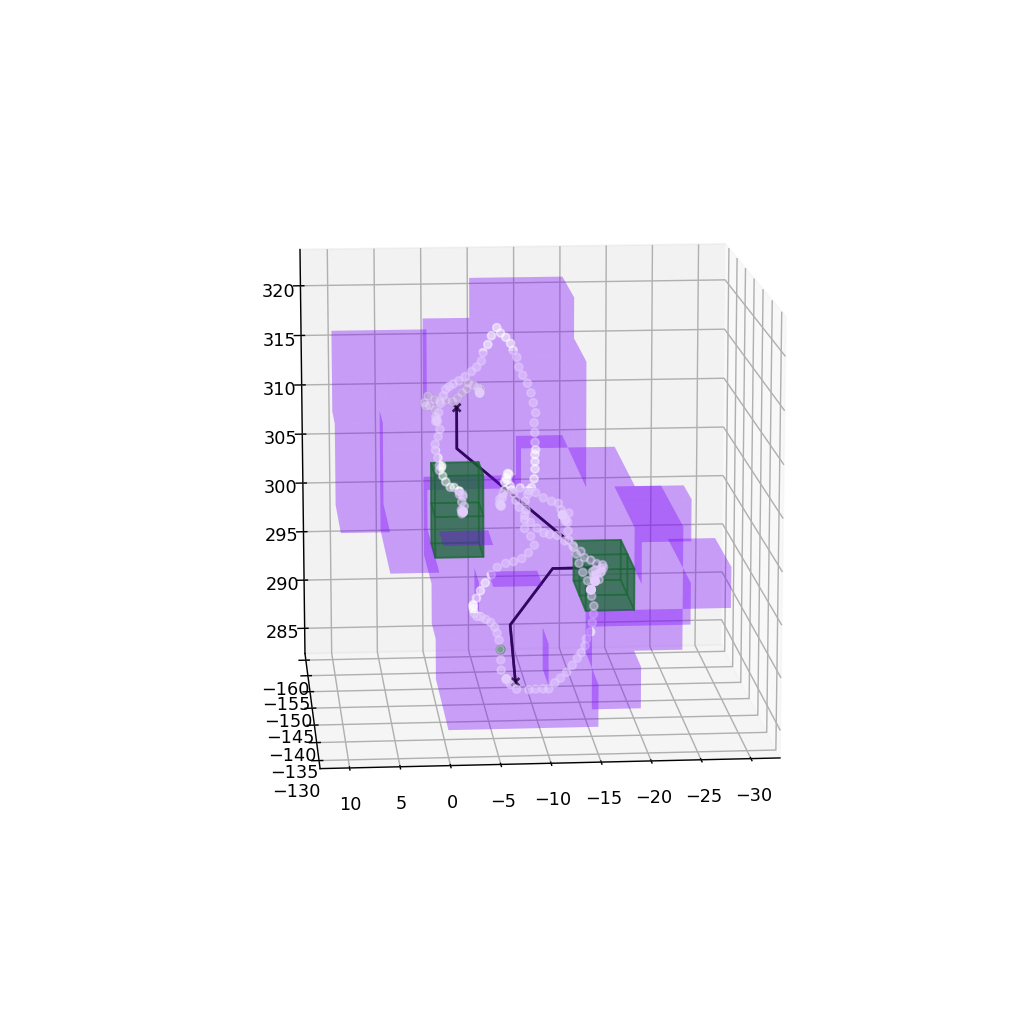

In [77]:
draw_event(clouds, cells, bins, ehits)

### Draw Graph and attributes

graphid  node    energy  nsize segclass segextreme segpaulina  \
15         0    15  0.492249     40     blob      blob1      blob1   
75         0    75  0.608760     52     blob      blob2    segment   
87         0    87  0.117956     14    other       node    segment   
108        0   108  0.395005     39    other       node      blob2   

     eccentricity  
15              2  
75              2  
87              3  
108             3

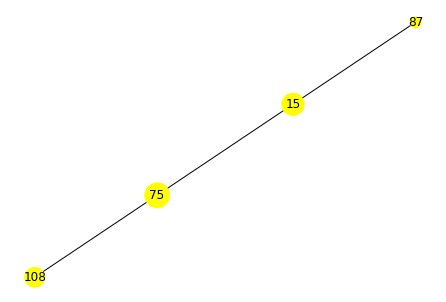

In [78]:
fnodes = bc.ana_nodes_frame(clouds)
graph, glinks = bc.nodes_to_graph(fnodes)
enes          = np.array([bc._nodes_energy(n, fnodes) for n in graph])
draw_graph(graph, glinks, enes)
names = ['graphid', 'node', 'energy', 'nsize', 'segclass', 'segextreme', 'segpaulina', 'eccentricity']
fnodes[fnodes.graphid == 0][names]

### Blob selection

In [79]:
bmethods = bc.ana_extremes(fnodes)
#print('blobs frame ', list(bmethods.columns))
bmethods[['bmethod', 'bncandis', 'bismcextr', 'b1energy', 'b1segclass', 
    'b1ismcextr', 'b1size', 'b2energy', 'b2size', 'b2segclass', 'b2ismcextr']]

bmethod  bncandis  bismcextr  b1energy b1segclass  b1ismcextr  b1size  \
0            mc         1          2  0.608760       blob           1      52   
1       paulina         1          1  0.492249       blob           1      40   
2    isapaulina         1          1  1.138350       blob           1      40   
3      extremes         1          0  0.395005      other           0      39   
4  extremes_sum         1          2  1.003765       blob           1      91   
5  extremes_max         1          2  0.608760       blob           1      52   

   b2energy  b2size b2segclass  b2ismcextr  
0  0.492249      40       blob           1  
1  0.395005      39      other           0  
2  1.027056      39      other           0  
3  0.117956      14      other           0  
4  0.610205      54       blob           1  
5  0.492249      40       blob           1

# ------------

# Run: Clouds to Nodes 

Run the events, create the clouds, generate the nodes frames and store them for further analysis

In [17]:
fnodes_filename = 'fnodes_50_54_220407_v0.h5'
nevtns          = -1
save            = True
ok = input('Do you want to run? (y, n) ')
def _run():
    dds = [bc.clouds_run(filename, bc.ana_nodes_frame, -1) for filename in bc.filenames]
    for i, idd in enumerate(dds): idd['fileindex'] = i
    xdd = pd.concat(dds, ignore_index = False)
    if (save):
        print('saving file ', fnodes_filename)
        xdd.to_hdf(fnodes_filename, 'fnodes')
    return xdd
dd = pd.read_hdf(fnodes_filename, 'fnodes') if ok != 'y' else _run()
print('number of entries {:d}'.format(len(dd)))
group     = ['fileindex', 'event']
#print('number of events  {:d}'.format(len(dd.groupby(group))))

Do you want to run? (y, n) n
number of entries 109674


In [18]:
group     = ['fileindex', 'event']
print('number of events  {:d}'.format(len(dd.groupby(group))))

number of events  13057


### Plots - Nodes Frame

In [19]:
def ana_event():
    
    group     = ['fileindex', 'event']
    fileindex = dd.groupby(group)['fileindex'].max()
    event     = dd.groupby(group)['event'].max()
    dataclass = dd.groupby(group)['dataclass'] .max().values

    nnodes    = dd.groupby(group)['evtnodes']  .max().values
    ntracks   = dd.groupby(group)['evtntracks'].max().values
    ngraphs   = dd.groupby(group)['graphid']   .max().values + 1
    energy    = dd.groupby(group)['energy']    .sum().values
    g0ene     = dd.groupby(group)['graphene']  .max().values
    g0size    = dd.groupby(group)['graphsize'] .max().values
    g0ecc     = dd.groupby(group)['graphecc']  .max().values
    g0necc    = dd.groupby(group)['graphnecc'] .max().values
    g0cycles  = dd.groupby(group)['graphcycles'].max().values

    hasblob1 = np.array(['blob1' in d['segextreme'].values for _, d in dd.groupby(group)])
    hasblob2 = np.array(['blob2' in d['segextreme'].values for _, d in dd.groupby(group)])
    hasstart = np.array(['start' in d['segextreme'].values for _, d in dd.groupby(group)])
    hasblob2 = hasblob2 + hasstart

    hasg0b1 = np.array(['blob1' in d['segextreme'][d['graphid'] == 0].values for _, d in dd.groupby(group)])
    hasg0b2 = np.array(['blob2' in d['segextreme'][d['graphid'] == 0].values for _, d in dd.groupby(group)])
    hasg0st = np.array(['start' in d['segextreme'][d['graphid'] == 0].values for _, d in dd.groupby(group)])
    hasg0b2 = hasg0b2 + hasg0st
    
    df = {}
    df['fileindex'] = fileindex
    df['event']     = event
    df['dataclass'] = dataclass
    df['evtntracks']= ntracks
    df['evtngraphs']= ngraphs
    df['evtsize']   = nnodes
    df['evtenergy'] = energy
    df['evthasb1']  = hasblob1
    df['evthasb2']  = hasblob2
    df['g0size']    = g0size
    df['g0energy']  = g0ene
    df['g0ecc']     = g0ecc
    df['g0necc']    = g0necc
    df['g0cycles']  = g0cycles
    df['g0hasb1']   = hasg0b1
    df['g0hasb2']   = hasg0b2
    
    return pd.DataFrame(df)

In [20]:
edd = ana_event()

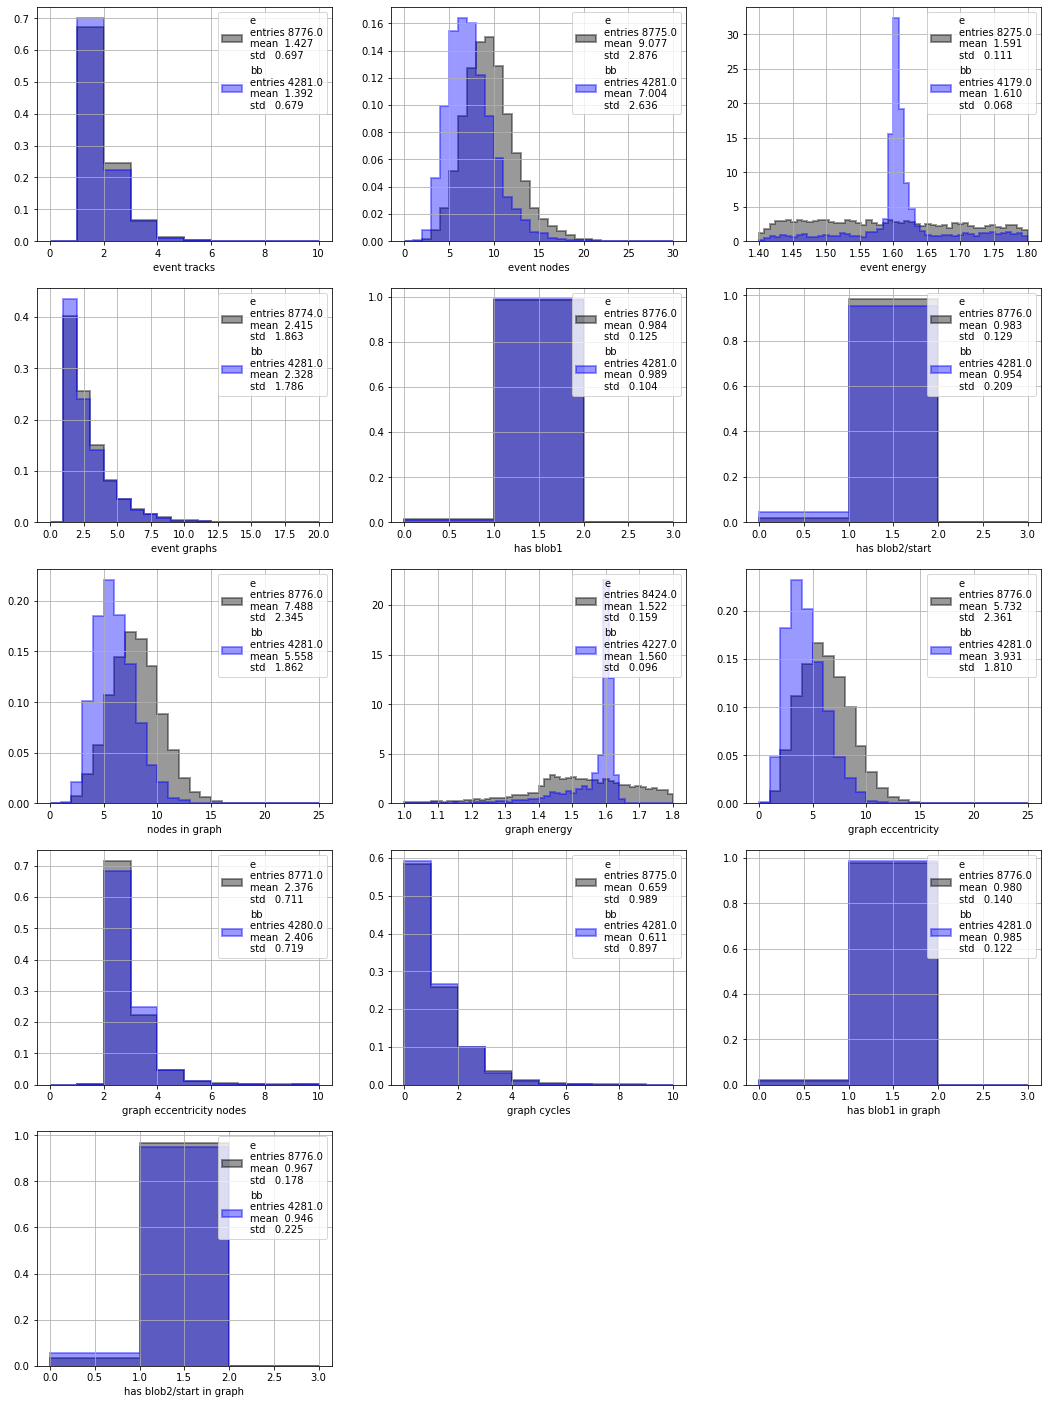

In [21]:
%matplotlib inline
names    = ['e', 'bb']

histos = (('evtntracks', 10, (0, 10), 'event tracks'),
          ('evtsize'   , 30, (0, 30), 'event nodes'),
          ('evtenergy' , 50, (1.4, 1.8), 'event energy'),
          ('evtngraphs', 20, (0, 20), 'event graphs'),
          ('evthasb1'  , 3, (0, 3), 'has blob1'),
          ('evthasb2'  , 3, (0, 3), 'has blob2/start'),
          ('g0size'    , 25, (0, 25), 'nodes in graph'),
          ('g0energy'  , 50, (1., 1.8), 'graph energy'),
          ('g0ecc'     , 25, (0, 25), 'graph eccentricity'),
          ('g0necc'    , 10, (0, 10), 'graph eccentricity nodes'),
          ('g0cycles'  , 10, (0, 10), 'graph cycles'),
          ('g0hasb1'   , 3, (0, 3), 'has blob1 in graph'),
          ('g0hasb2'   , 3, (0, 3), 'has blob2/start in graph')
         )

canvas = pltext.canvas(len(histos), 3)
for i, histo in enumerate(histos):
    canvas(i +1)
    var, nbins, xrange, label = histo
    for i in (0, 1):
        sel = edd.dataclass == i
        pltext.hist(edd[var][sel], nbins, xrange, density = True, 
                    label = names[i], lw = 2, alpha = 0.4, fill = True);
        plt.xlabel(label)

### Events with no-blob in MC

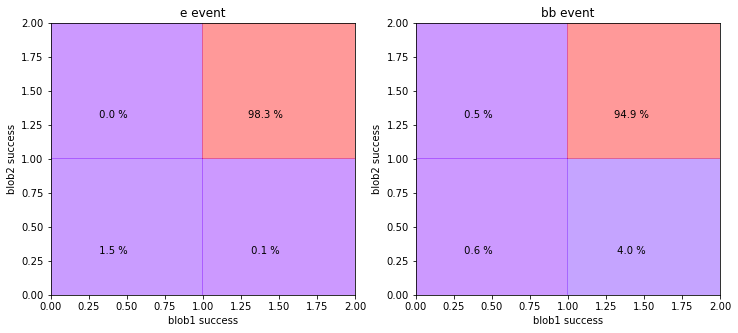

In [22]:
canvas = pltext.canvas(2, 2)
for i in (0, 1):
    canvas(i +1)
    sel = edd.dataclass == i
    hist2d_text(edd.evthasb1[sel], edd.evthasb2[sel], (2, 2), ((0, 2), (0, 2)),
                density = True, alpha = 0.4);
    plt.xlabel('blob1 success'); plt.ylabel('blob2 success'); plt.title(names[i] + ' event')

In [23]:
sels     = [edd['evthasb1'] == False, edd['evthasb2'] == False, 
            (edd['evthasb1'] == False) & (edd['evthasb2'] == False)]
selnames = ['noblob1', 'noblob2', 'no blobs ']

edd_noblobs = {} 
for i in (0, 1):
    isel = edd.dataclass == i
    for j, jsel in enumerate(sels):
        edd_noblobs[(i, j)] = edd[isel & jsel][['evthasb1', 'evthasb2']]
        eff = float(len(edd_noblobs[(i, j)])/len(edd[isel]))
        print(names[i], selnames[j], '\t  size {:3d}'.format(len(edd_noblobs[(i, j)])), 
              ', efficiency {:4.2f} %'.format(100. *eff))

e noblob1 	  size 140 , efficiency 1.60 %
e noblob2 	  size 148 , efficiency 1.69 %
e no blobs  	  size 136 , efficiency 1.55 %
bb noblob1 	  size  47 , efficiency 1.10 %
bb noblob2 	  size 196 , efficiency 4.58 %
bb no blobs  	  size  24 , efficiency 0.56 %


In [24]:
for i in (0, 1):
    for j in (0, 1, 2):
        print(names[i]+'_'+selnames[j]+' = '+str(list(edd_noblobs[(i, j)].index.values)[:10]))

e_noblob1 = [(0, 83), (0, 215), (0, 278), (0, 400), (0, 653), (0, 685), (0, 697), (0, 728), (0, 1005), (0, 1271)]
e_noblob2 = [(0, 83), (0, 215), (0, 254), (0, 278), (0, 400), (0, 653), (0, 685), (0, 697), (0, 728), (0, 1005)]
e_no blobs  = [(0, 83), (0, 215), (0, 278), (0, 400), (0, 653), (0, 685), (0, 697), (0, 728), (0, 1005), (0, 1271)]
bb_noblob1 = [(0, 208), (0, 670), (0, 776), (0, 1190), (0, 1589), (0, 1727), (0, 2076), (0, 2221), (1, 212), (1, 255)]
bb_noblob2 = [(0, 196), (0, 208), (0, 223), (0, 301), (0, 516), (0, 757), (0, 776), (0, 799), (0, 814), (0, 840)]
bb_no blobs  = [(0, 208), (0, 776), (0, 2076), (1, 212), (1, 1407), (1, 2361), (1, 2637), (2, 399), (2, 1381), (2, 1636)]


### Events with no blob in Graph (but ok in MC)

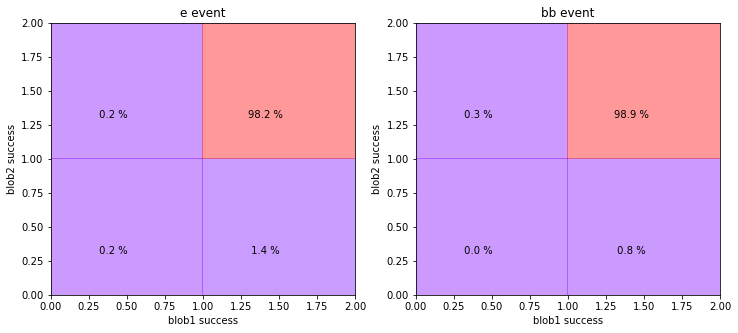

In [25]:
canvas = pltext.canvas(2, 2)
for i in (0, 1):
    canvas(i +1)
    evtok = (edd.evthasb1 == True) & (edd.evthasb2 == True)
    sel = edd.dataclass == i
    hist2d_text(edd.g0hasb1[sel & evtok], edd.g0hasb2[sel & evtok],
                (2, 2), ((0, 2), (0, 2)),
                density = True, alpha = 0.4);
    plt.xlabel('blob1 success'); plt.ylabel('blob2 success'); plt.title(names[i] + ' event')

In [26]:
selhasbs = (edd['evthasb1'] == True) & (edd['evthasb2'] == True)

sels     = [edd['g0hasb1'] == False, edd['g0hasb2'] == False, 
            (edd['g0hasb1'] == False) & (edd['g0hasb2'] == False)]
selnames = ['graph noblob1', 'graph noblob2', 'graph no blobs ']

edd_noblobs = {} 
for i in (0, 1):
    isel = (edd.dataclass == i) & (selhasbs)
    for j, jsel in enumerate(sels):
        edd_noblobs[(i, j)] = edd[isel & jsel][['evthasb1', 'evthasb2']]
        eff = float(len(edd_noblobs[(i, j)])/len(edd[isel]))
        print(names[i], selnames[j], '\t  size {:3d}'.format(len(edd_noblobs[(i, j)])), 
              ', efficiency {:4.2f} %'.format(100. *eff))

e graph noblob1 	  size  35 , efficiency 0.41 %
e graph noblob2 	  size 139 , efficiency 1.61 %
e graph no blobs  	  size  18 , efficiency 0.21 %
bb graph noblob1 	  size  14 , efficiency 0.34 %
bb graph noblob2 	  size  33 , efficiency 0.81 %
bb graph no blobs  	  size   2 , efficiency 0.05 %


In [27]:
for i in (0, 1):
    for j in (0, 1, 2):
        print(names[i]+'_'+selnames[j]+' = '+str(list(edd_noblobs[(i, j)].index.values)[:10]))

e_graph noblob1 = [(0, 778), (0, 1053), (0, 1116), (0, 1421), (0, 2105), (0, 2239), (0, 2263), (1, 81), (1, 807), (1, 903)]
e_graph noblob2 = [(0, 91), (0, 109), (0, 271), (0, 356), (0, 377), (0, 389), (0, 700), (0, 778), (0, 787), (0, 910)]
e_graph no blobs  = [(0, 778), (0, 1116), (0, 1421), (0, 2105), (0, 2239), (1, 81), (1, 807), (1, 1151), (1, 1458), (1, 1592)]
bb_graph noblob1 = [(0, 1604), (0, 1743), (0, 1796), (0, 1837), (0, 1891), (0, 2028), (1, 2179), (2, 106), (3, 71), (3, 1131)]
bb_graph noblob2 = [(0, 1278), (0, 1837), (0, 1914), (0, 2358), (1, 29), (1, 98), (1, 801), (1, 971), (1, 1238), (1, 1641)]
bb_graph no blobs  = [(0, 1837), (3, 1131)]


### Conclusions

   * Aprox 5 % of bb has not the blobs in the graph, but 95.6% of the events have them
   
   * graphs without blobs correspond to events where the graph is not the most energetic or the track is splitted during the reconstruction 
   
   * Can we improve the blob2 for bb assignement?


## Ana graph0

In [32]:
def ana_graph0(dd):
    
    group     = ['fileindex', 'event']
    fileindex = dd.groupby(group)['fileindex'].max()
    event     = dd.groupby(group)['event'].max()
    dataclass = dd.groupby(group)['dataclass'] .max().values

    nnodes    = dd.groupby(group)['evtnodes']  .max().values
    ngraphs   = dd.groupby(group)['graphid']   .max().values + 1
    energy    = dd.groupby(group)['energy']    .sum().values
    g0ene     = dd.groupby(group)['graphene']  .max().values
    g0size    = dd.groupby(group)['graphsize'] .max().values
    g0ecc     = dd.groupby(group)['graphecc']  .max().values
    g0necc    = dd.groupby(group)['graphnecc'] .max().values
    g0cycles  = dd.groupby(group)['graphcycles'].max().values

    hasblob1 = np.array(['blob1' in d['segextreme'].values for _, d in dd.groupby(group)])
    hasblob2 = np.array(['blob2' in d['segextreme'].values for _, d in dd.groupby(group)])
    hasstart = np.array(['start' in d['segextreme'].values for _, d in dd.groupby(group)])
    hasblobs = hasblob1.astype(int) + hasblob2.astype(int) + hasstart.astype(int)

    hasg0b1  = np.array(['blob1' in d['segextreme'][d['graphid'] == 0].values for _, d in dd.groupby(group)])
    hasg0b2  = np.array(['blob2' in d['segextreme'][d['graphid'] == 0].values for _, d in dd.groupby(group)])
    hasg0st  = np.array(['start' in d['segextreme'][d['graphid'] == 0].values for _, d in dd.groupby(group)])
    hasg0bs  = hasg0b1.astype(int) + hasg0b2.astype(int) + hasg0st.astype(int)
    
    def _blob_info(d, iblob):
        idataclass = int(np.unique(d.dataclass))
        seg = 'blob1' if iblob == 1 else 'blob2'
        if (iblob == 2):
            seg = 'start' if idataclass == 0 else seg
        sel = (d.segextreme == seg) & (d.graphid == 0)
        eccdist  = float(d[sel].eccdistance)  if np.sum(sel) == 1 else -1
        ecc0dist = float(d[sel].ecc0distance) if np.sum(sel) == 1 else -1
        eneorder = float(d[sel].eneorder)     if np.sum(sel) == 1 else -1
        return eccdist, ecc0dist, eneorder

    df = {}
    df['fileindex'] = fileindex
    df['event']     = event
    df['dataclass'] = dataclass
    df['ngraphs']   = ngraphs
    df['evtsize']   = nnodes
    df['evtenergy'] = energy
    df['evthasbs']  = hasblobs
    df['g0size']    = g0size
    df['g0energy']  = g0ene
    df['g0ecc']     = g0ecc
    df['g0necc']    = g0necc
    df['g0cycles']  = g0cycles
    df['g0hasbs']   = hasg0bs
    
    for i in (1, 2):
        bi = [_blob_info(d, i) for _, d in dd.groupby(group)]
        ecc, ecc0, eno0 = [x[0] for x in bi], [x[1] for x in bi], [x[2] for x in bi]
        df['b'+str(i)+'eccdist']  = ecc
        df['b'+str(i)+'ecc0dist'] = ecc0
        df['b'+str(i)+'eneorder'] = eno0
    
    return pd.DataFrame(df)

In [33]:
gdd = ana_graph0(dd)

In [38]:
#gdd

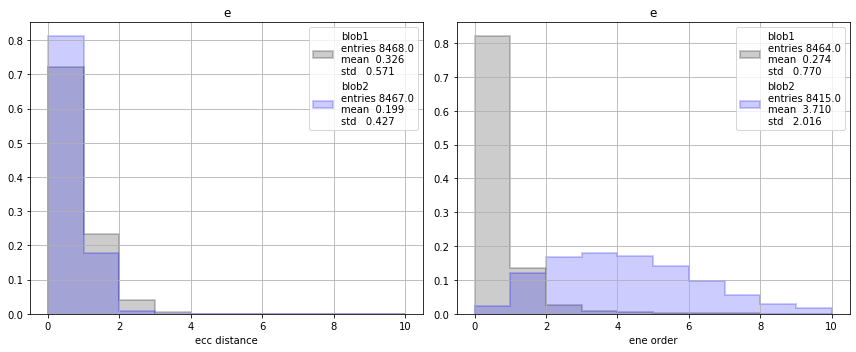

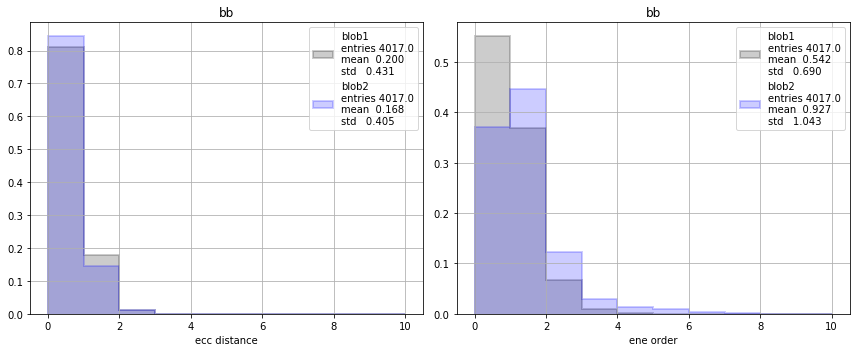

In [39]:
%matplotlib inline
names    = ['blob1', 'blob2']

histos = (('eccdist' , 10, (0, 10), 'ecc distance'),
          #('ecc0dist', 15, (0, 15), 'ecc0 distance'),
          ('eneorder', 10, (0, 10), 'ene order'),
         )

for itype in (0, 1):
    title = 'e' if itype == 0 else 'bb'
    canvas = pltext.canvas(len(histos), 2)
    for i, histo in enumerate(histos):
        canvas(i +1)
        var, nbins, xrange, label = histo
        for i in (1, 2):
            uvar = 'b' + str(i) + var
            sel = (gdd.dataclass == itype) & (gdd.g0hasbs == 2)
            pltext.hist(gdd[uvar][sel], nbins, xrange, density = True, 
                        label = names[i-1], lw = 2, alpha = 0.2, fill = True);
            plt.xlabel(label); plt.title(title)
        plt.tight_layout()

In [41]:
def indices_in_selection(df, sels, names):
    dgroups = {}
    for k, sel in enumerate(sels):
        for i in (0, 1): 
            ename = 'e' if i == 0 else 'bb'
            isel = df.dataclass == i
            vals = df[isel & sel].index.values
            eff  = float(len(vals)/len(df[isel]))
            dgroups[names[k]+'_'+ename] = (eff, vals)
    return dgroups

In [42]:
sels      = (gdd.b1eccdist >= 1,  gdd.b2eccdist >= 1)
evts_ecc1 = indices_in_selection(gdd, sels, ('b1ecc1', 'b2ecc2'))

In [48]:
for key in evts_ecc1:
    eff, vals = evts_ecc1[key]
    print(key, ': \t  size {:3d}'.format(len(vals)), ', efficiency \t {:4.2f} %'.format(100. * eff))
    print(key, ' = ', list(vals[:15]))

b1ecc1_e : 	  size 2374 , efficiency 	 27.05 %
b1ecc1_e  =  [(0, 3), (0, 10), (0, 22), (0, 24), (0, 26), (0, 29), (0, 32), (0, 33), (0, 35), (0, 38), (0, 45), (0, 50), (0, 53), (0, 54), (0, 56)]
b1ecc1_bb : 	  size 827 , efficiency 	 19.32 %
b1ecc1_bb  =  [(0, 6), (0, 25), (0, 55), (0, 66), (0, 106), (0, 111), (0, 119), (0, 159), (0, 160), (0, 168), (0, 181), (0, 238), (0, 291), (0, 300), (0, 301)]
b2ecc2_e : 	  size 1599 , efficiency 	 18.22 %
b2ecc2_e  =  [(0, 0), (0, 2), (0, 3), (0, 10), (0, 23), (0, 24), (0, 32), (0, 33), (0, 38), (0, 39), (0, 43), (0, 58), (0, 61), (0, 65), (0, 80)]
b2ecc2_bb : 	  size 631 , efficiency 	 14.74 %
b2ecc2_bb  =  [(0, 55), (0, 121), (0, 160), (0, 173), (0, 176), (0, 189), (0, 200), (0, 234), (0, 250), (0, 322), (0, 355), (0, 361), (0, 440), (0, 444), (0, 508)]


## Nodes Frame Run - Extremes

In [41]:
bmethods_filename = 'bmethods_50_54_220407_v0.h5'
save              = True
ok = input('Do you want to run? (y, n) ')
def _run():
    xdf = bc.nodes_run(dd, bc.ana_extremes, -1)
    if (save):
        xdf.to_hdf(bmethods_filename, 'bmethods')
    return xdf
dfext = pd.read_hdf(bmethods_filename, 'bmethods') if ok != 'y' else _run()
print('number of events {:d}'.format(len(dfext)))

Do you want to run? (y, n) y
Number of events  13057
event  0
event  500
event  1000
event  1500
event  2000
event  2500
event  3000
event  3500
event  4000
event  4500
event  5000
event  5500
event  6000
event  6500
event  7000
event  7500
event  8000
event  8500
event  9000
event  9500
event  10000
event  10500
event  11000
event  11500
event  12000
event  12500
event  13000
processed number of events  13056
failures                    0
number of events 78336


In [42]:
print('blobs frame ',list(dfext.columns))

blobs frame  ['evtenergy', 'evtsize', 'evtntracks', 'evtngraphs', 'evtismcextr', 'g0size', 'g0energy', 'g0ecc', 'g0necc', 'g0ismcextr', 'bmethod', 'bncandis', 'bmcorder', 'bismcextr', 'b1node', 'b1energy', 'b1size', 'b1ismcextr', 'b1segclass', 'b2node', 'b2energy', 'b2size', 'b2ismcextr', 'b2segclass', 'dataclass', 'fileindex', 'event']


In [131]:
methods =  ('mc', 'paulina', 'isapaulina', 'extremes', 'extremes_sum', 'extremes_max')
    
def plot_bmethods_candidates(df, methods = methods):

    canvas = pltext.canvas(2 * len(methods), 2)

    for i, method in enumerate(methods):

        esel  = (df.dataclass == 0) & (df.bmethod == method) #& (dfext.g0ismcextr == 2) & (dfext.bncandis >= 1)
        bbsel = (df.dataclass == 1) & (df.bmethod == method) #& (dfext.g0ismcextr == 2) & (dfext.bncandis >= 1)
    
        canvas(2 * i + 1)
        plt.hist(df.bncandis[esel] , 10, (0, 10), density = True, alpha = 0.4, label = 'e');
        plt.hist(df.bncandis[bbsel], 10, (0, 10), density = True, alpha = 0.4, label = 'bb');
        plt.grid(); plt.title(method); plt.legend(); plt.xlabel('number of candidates')
    
        canvas(2 * i + 2)
        plt.hist(df.bmcorder[esel] , 11, (-1, 10), density = True, alpha = 0.4, label = 'e');
        plt.hist(df.bmcorder[bbsel], 11, (-1, 10), density = True, alpha = 0.4, label = 'bb');
        plt.grid(); plt.title(method); plt.legend(); plt.xlabel('order of true candidate')
        
    plt.tight_layout()
    return 


def plot_bmethods_b2energy(df, methods = methods):

    canvas = pltext.canvas(2 * len(methods), 2)

    for i, method in enumerate(methods):

        esel  = (df.dataclass == 0) & (df.bmethod == method) 
        bbsel = (df.dataclass == 1) & (df.bmethod == method)
    
        canvas(2 * i + 1)
        plt.hist(df.bismcextr[esel] , 4, (0, 4), density = True, alpha = 0.4, label = 'e');
        plt.hist(df.bismcextr[bbsel], 4, (0, 4), density = True, alpha = 0.4, label = 'bb');
        plt.grid(); plt.title(method); plt.legend(); plt.xlabel('number of true blobs')
    
        canvas(2 * i + 2)
        plt.hist(df.b2energy[esel] , 100, (0, 1.2), density = True, alpha = 0.4, label = 'e');
        plt.hist(df.b2energy[bbsel], 100, (0, 1.2), density = True, alpha = 0.4, label = 'bb');
        plt.grid(); plt.title(method); plt.legend(); plt.xlabel('energy blob2 (MeV)')
        
    plt.tight_layout()
    return 

def plot_bmethods_roc(df, methods = methods, title = 'RoC'):

    plt.figure(figsize = (8, 6))

    for i, method in enumerate(methods):

        esel  = (df.dataclass == 0) & (df.bmethod == method) 
        bbsel = (df.dataclass == 1) & (df.bmethod == method)
        
        var1 = df.b2energy[esel].values
        var2 = df.b2energy[bbsel].values
        ls = 'dotted' if 'pau' in method else 'solid'
        ls = 'dashed'  if 'mc' in method  else ls
        roc(var1, var2, 100, (0., 1.6), label = method, linestyle = ls, lw = 3, alpha = 1.);

    
    plt.legend(); plt.grid(); plt.title(title)
    plt.xlabel('rejection', fontsize = 14); plt.ylabel('efficiency', fontsize = 14);
    #plt.ylabel('bkg acceptance', fontsize = 14); plt.xlabel('signal efficiency', fontsize = 14);
    plt.tight_layout()
    return 

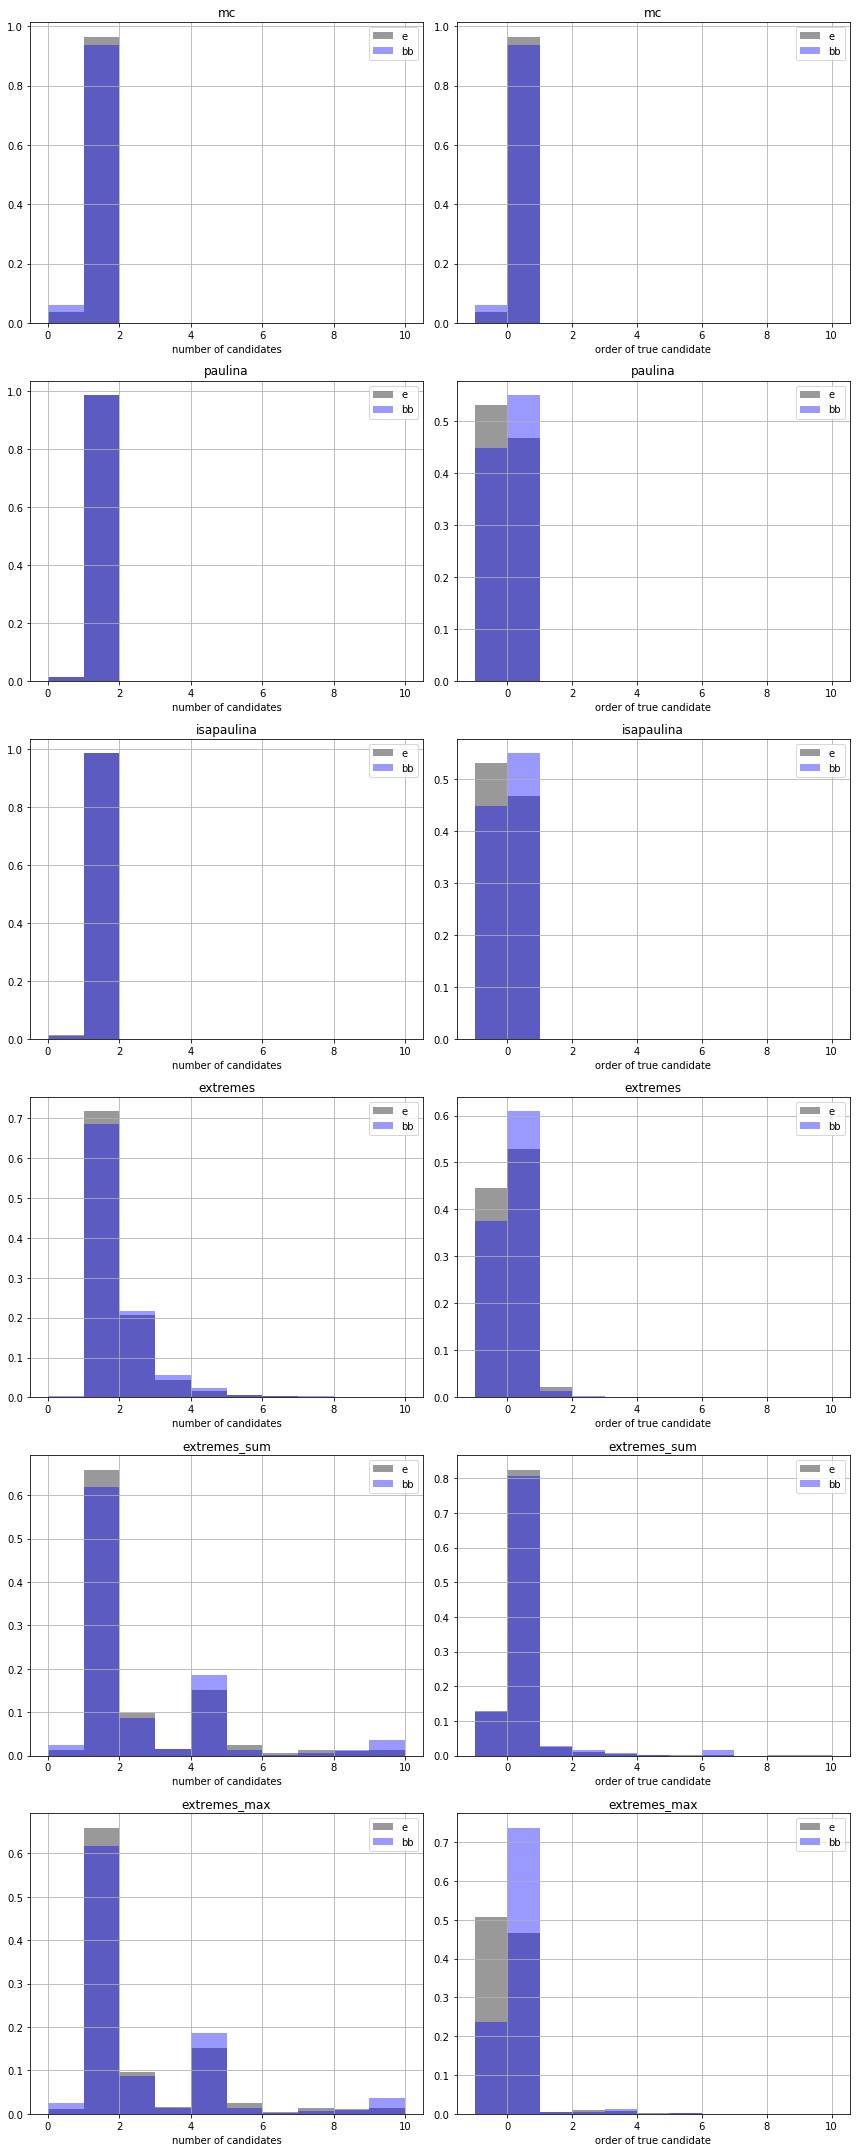

In [44]:
plot_bmethods_candidates(dfext)

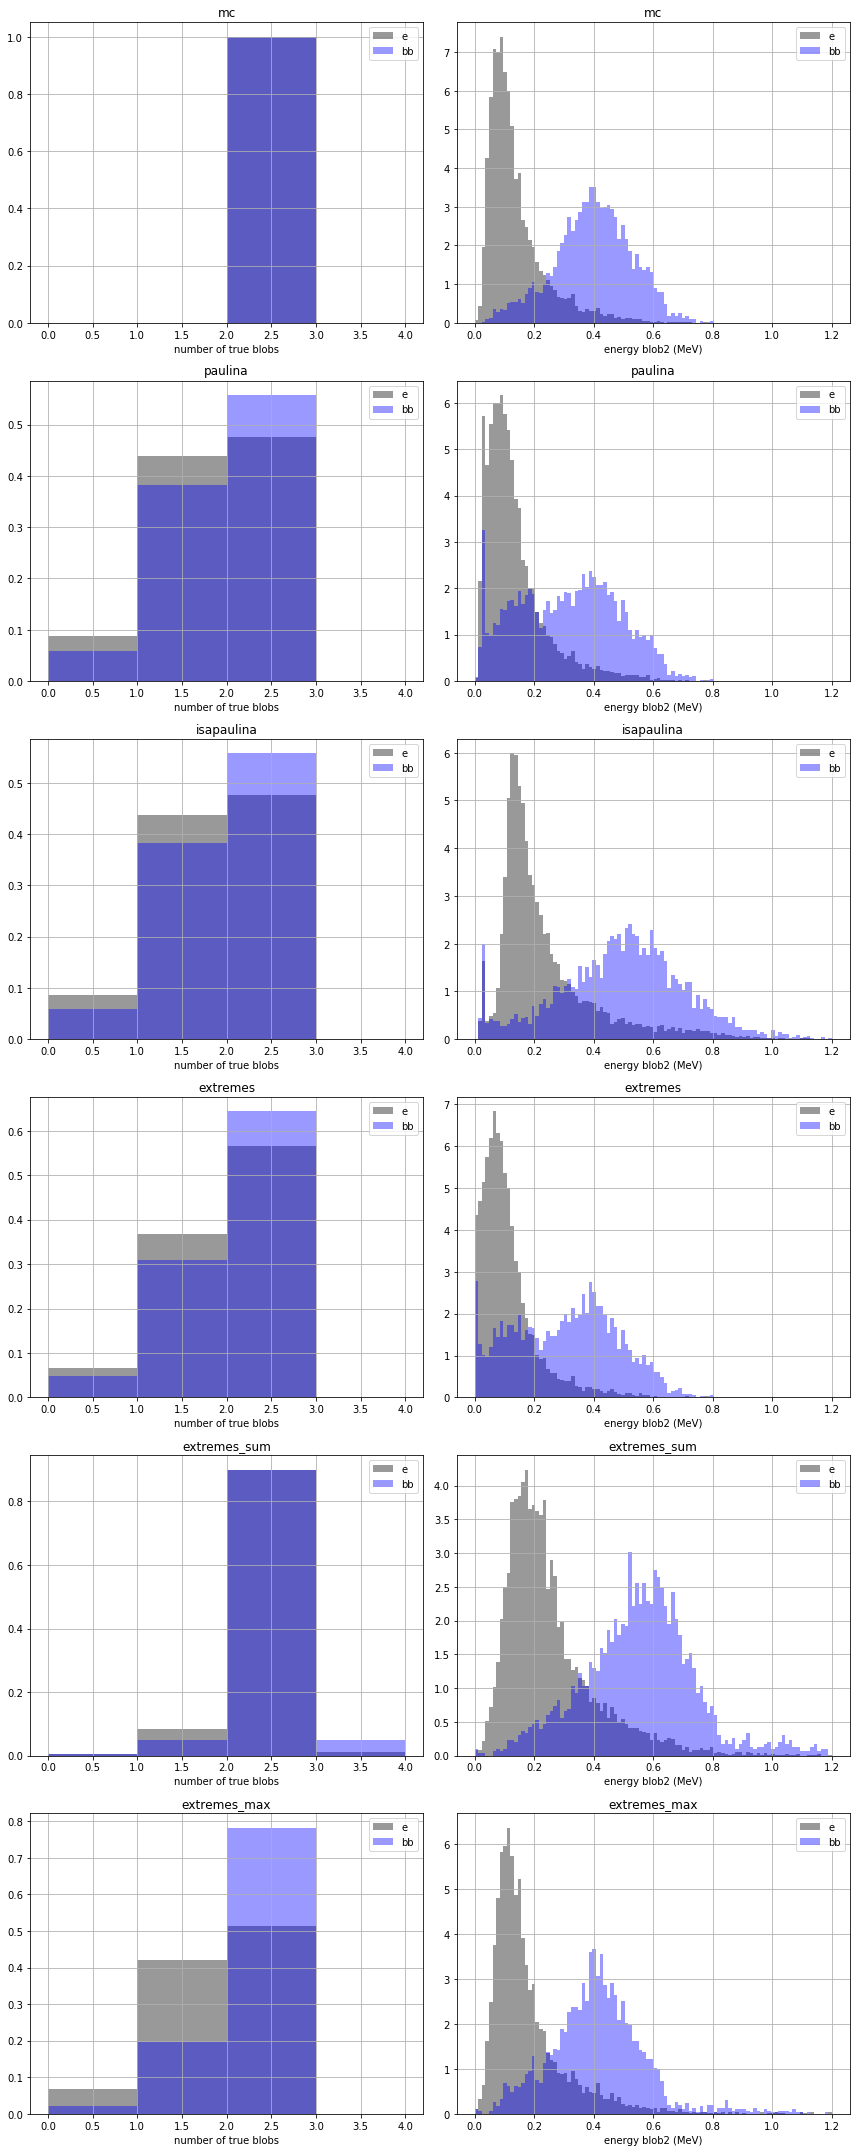

In [45]:
sel = (dfext.bncandis == 1) 
plot_bmethods_b2energy(dfext[sel])

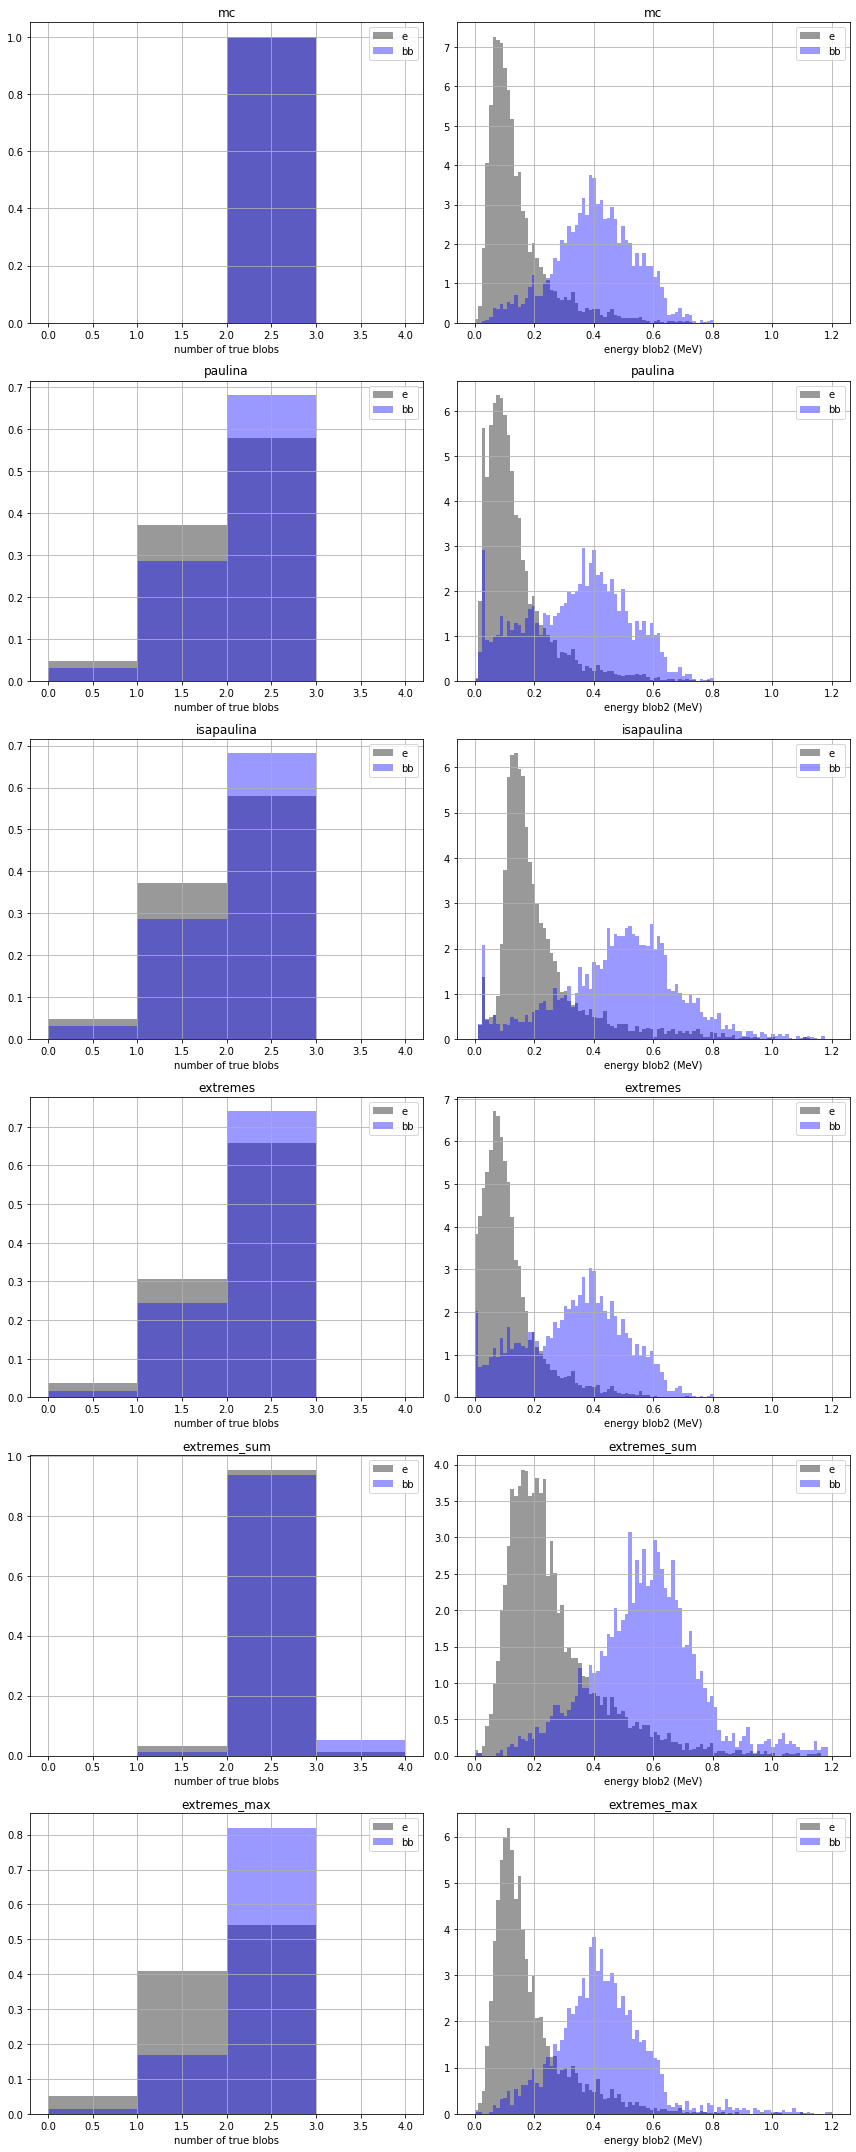

In [46]:
sel = (dfext.g0ismcextr == 2) & (dfext.bncandis == 1 ) & (dfext.g0size == dfext.g0ecc +1)
plot_bmethods_b2energy(dfext[sel])

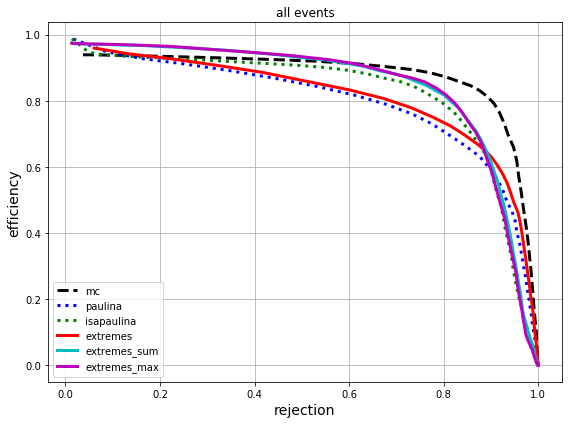

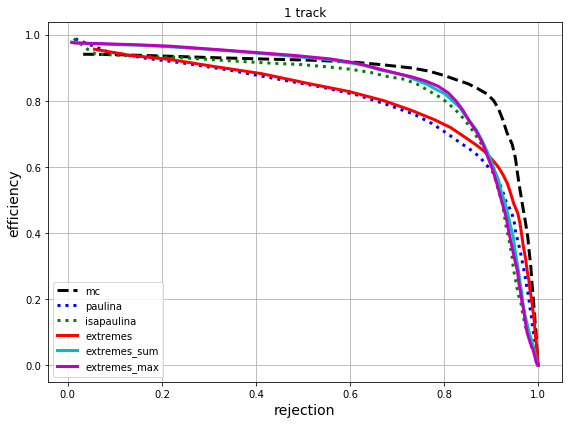

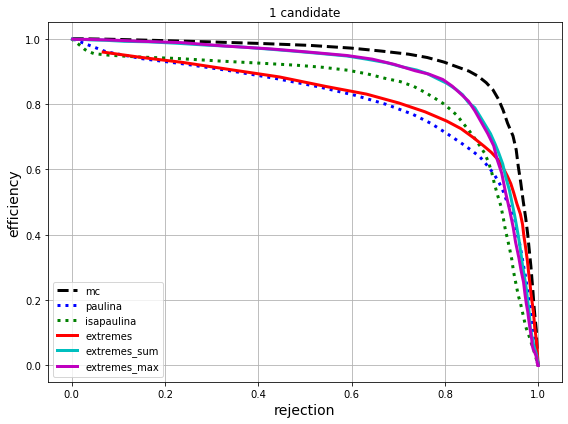

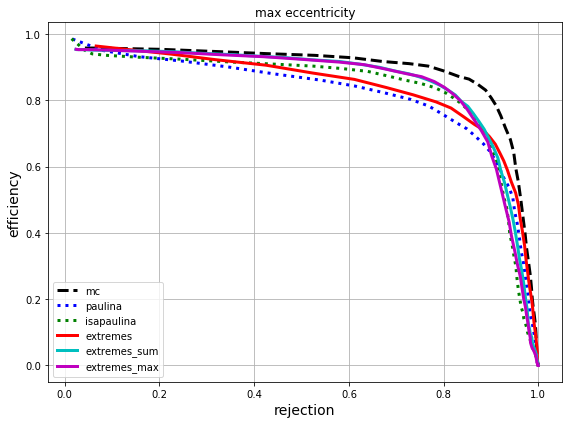

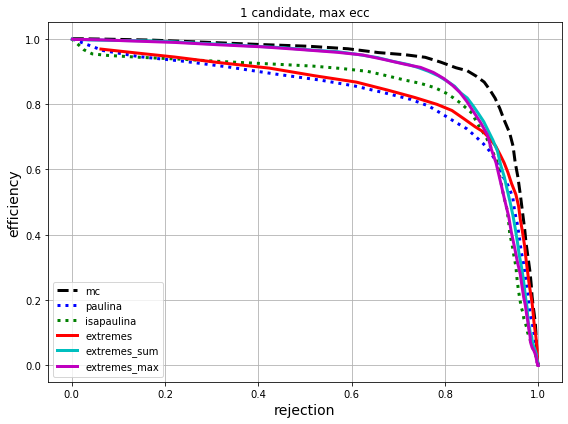

In [132]:
plot_bmethods_roc(dfext, title = 'all events');
#plt.yscale('log'); plt.ylim(0.1, 1.); plt.grid(which = 'both');
sel = (dfext.evtntracks == 1)
plot_bmethods_roc(dfext[sel], title = '1 track')
sel = (dfext.bncandis == 1)
plot_bmethods_roc(dfext[sel], title = '1 candidate')
sel = (dfext.g0ecc ==  dfext.g0size - 1)
plot_bmethods_roc(dfext[sel], title = 'max eccentricity')
sel = (dfext.bncandis == 1) & (dfext.g0ecc ==  dfext.g0size - 1) # & (dfext.g0size >= 4)
plot_bmethods_roc(dfext[sel], title = '1 candidate, max ecc')

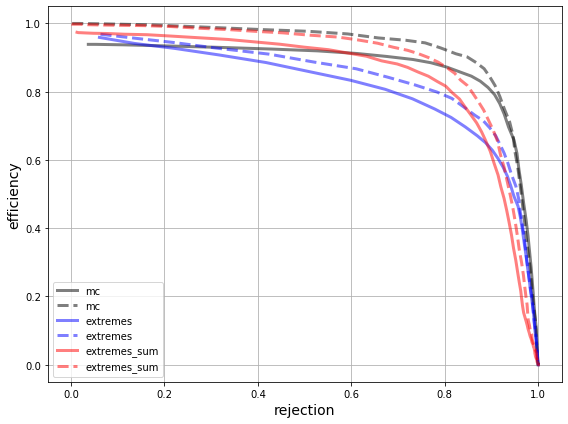

In [134]:
def _roc_method(df, method, **kargs):
    esel  = (df.dataclass == 0) & (df.bmethod == method) 
    bbsel = (df.dataclass == 1) & (df.bmethod == method)
        
    var1 = df.b2energy[esel].values
    var2 = df.b2energy[bbsel].values
    roc(var1, var2, 100, (0., 1.6), label = method, lw = 3, **kargs);
    return
    
_methods = ['mc', 'extremes', 'extremes_sum']
plt.figure(figsize = (8, 6))

colors = ['black', 'blue', 'red']
for i, method in enumerate(_methods):
    _roc_method(dfext, method, ls = 'solid', color = colors[i], alpha = 0.5)
    sel = (dfext.bncandis == 1) & (dfext.g0ecc ==  dfext.g0size - 1) # & (dfext.g0size >= 4)
    _roc_method(dfext[sel], method, ls = 'dashed', color = colors[i], alpha = 0.5)
plt.legend(); plt.grid();
plt.xlabel('rejection', fontsize = 14); plt.ylabel('efficiency', fontsize = 14);
plt.tight_layout()

## Other studies

### Why Paulina has this inefficiency?

paulina ineff  0.01332720588235294


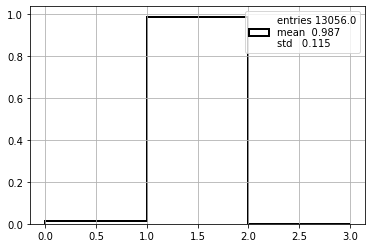

In [48]:
sel  = (dfext.bmethod == 'isapaulina')
sel0 = sel & (dfext.bncandis == 0)
pltext.hist(dfext[sel].bncandis, 3, (0., 3), density = True, lw = 2);
print('paulina ineff ', np.sum(sel0)/np.sum(sel))

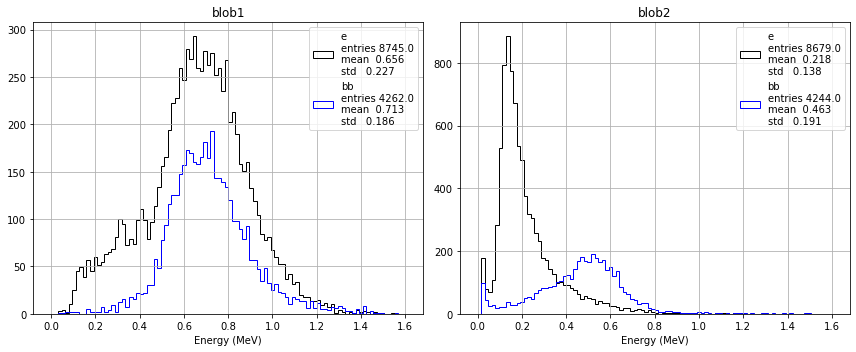

In [49]:
canvas = pltext.canvas(2, 2)
datanames = ['e', 'bb']
for j, name in enumerate(('blob1', 'blob2')):
    canvas(j + 1)
    for i in (0, 1):
        sel = (dd.segpaulina == name) & (dd.dataclass == i)
        pltext.hist(dd.epaulina[sel], 100, (0, 1.6), label = datanames[i]);
        plt.title(name); plt.xlabel('Energy (MeV)')
plt.tight_layout();


#### Conclusions:

  * Paulina inefficiency comes from blob2 some events have very low energy!

## What are the irreducible events?

In [65]:
b2cut = {'mc': 0.5, 'paulina':0.5, 'isapaulina':0.8, 'extremes':0.45, 'extremes_sum':0.7, 'extremes_max':0.52}
for method in methods:
    sel  = (dfext.dataclass == 0) & (dfext.bmethod == method) & (dfext.bncandis == 1) & (dfext.b2energy >  b2cut[method])
    evts = list(zip(dfext[sel].fileindex.values, dfext[sel].event.values))
    print(method, ' events ', len(evts))
    print(method, '_irre = ', str(evts[:10]) )

mc  events  93
mc _irre =  [(0, 397), (0, 414), (0, 533), (0, 580), (0, 672), (0, 717), (0, 736), (0, 896), (0, 919), (0, 926)]
paulina  events  122
paulina _irre =  [(0, 91), (0, 278), (0, 414), (0, 533), (0, 580), (0, 648), (0, 653), (0, 672), (0, 707), (0, 717)]
isapaulina  events  136
isapaulina _irre =  [(0, 87), (0, 199), (0, 240), (0, 248), (0, 413), (0, 580), (0, 648), (0, 712), (0, 755), (0, 989)]
extremes  events  97
extremes _irre =  [(0, 158), (0, 211), (0, 324), (0, 414), (0, 533), (0, 580), (0, 728), (0, 736), (0, 751), (0, 896)]
extremes_sum  events  120
extremes_sum _irre =  [(0, 213), (0, 236), (0, 290), (0, 410), (0, 414), (0, 580), (0, 596), (0, 648), (0, 687), (0, 715)]
extremes_max  events  154
extremes_max _irre =  [(0, 211), (0, 213), (0, 236), (0, 290), (0, 410), (0, 414), (0, 533), (0, 580), (0, 596), (0, 648)]


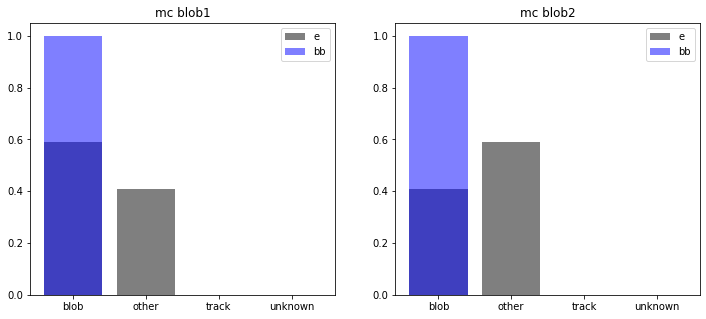

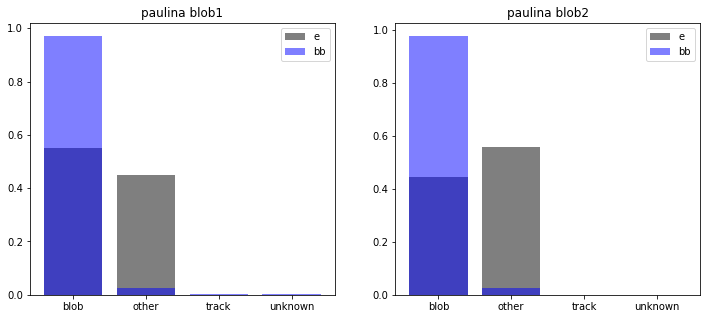

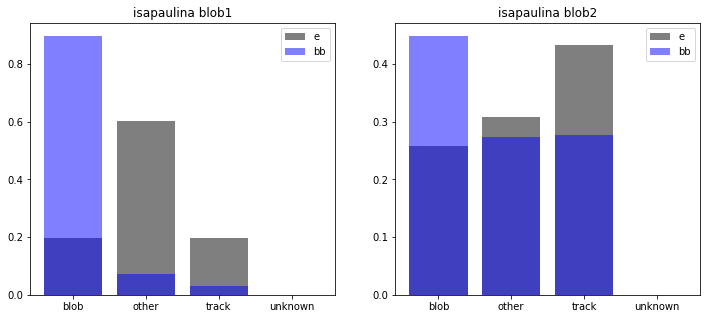

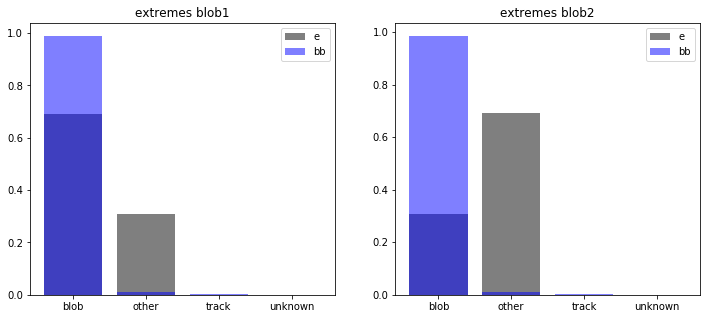

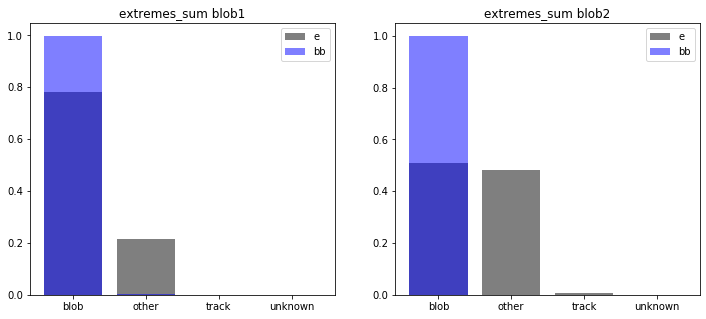

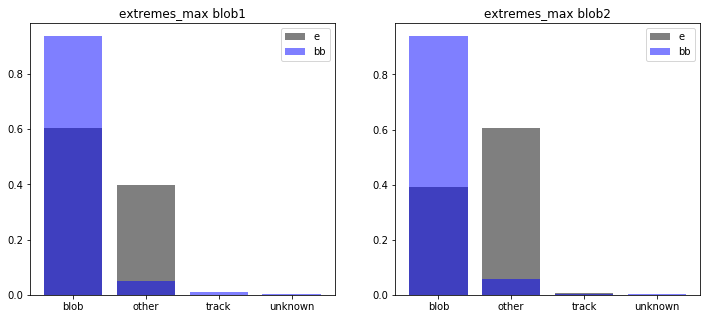

In [117]:
def hbar(var, vals = ['blob', 'other', 'track', 'unknown'], **kargs):
    counts = [np.sum(var == val)/len(var) for val in vals]
    plt.bar(vals, counts, **kargs);
    plt.gca().set_xticklabels(vals)
    return

method    = 'extremes'
datanames = ['e', 'bb']

for i, method in enumerate(methods):
    
    sel  = (dfext.bmethod == method) & (dfext.bncandis == 1) & (dfext.b2energy >  b2cut[method])
    
    canvas = pltext.canvas(2, 2)
    for k in (1, 2):
        canvas(k)
        for i in (0, 1):
            usel = (dfext.dataclass == i) & sel
            var = dfext[usel]['b'+str(k)+'segclass'].values
            hbar(var, label = datanames[i], alpha = 0.5)
            plt.title(method + ' blob'+str(k)); plt.legend(); plt.grid();

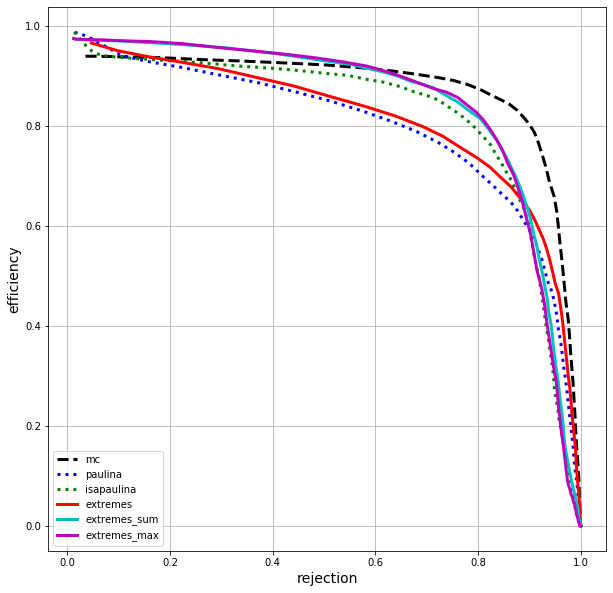

In [1321]:
plt.figure(figsize = (10, 10))
good = (dfext.g0size == dfext.g0ecc + 1)

for method in ('mc', 'paulina', 'isapaulina', 'extremes', 'extremes_sum', 'extremes_max'): 
    esel  = (dfext.dataclass == 0) & (dfext.bmethod == method) & (dfext.g0ismcextr >= 0) #& good #& (xxx.bncandis >= 1)
    bbsel = (dfext.dataclass == 1) & (dfext.bmethod == method) & (dfext.g0ismcextr >= 0) #& good #& (xxx.bncandis >= 1)
    var1 = dfext.b2energy[esel].values
    var2 = dfext.b2energy[bbsel].values
    ls = 'dotted' if 'pau' in method else 'solid'
    ls = 'dashed'  if 'mc' in method  else ls
    roc(var1, var2, 100, (0., 1.2), label = method, linestyle = ls, lw = 3, alpha = 1.);
plt.legend(); plt.grid(); 
plt.xlabel('rejection', fontsize = 14); plt.ylabel('efficiency', fontsize = 14);

In [820]:
nevt.columns

Index(['nnodes', 'node', 'energy', 'nsize', 'evtene', 'evtnodes', 'segclass',
       'segextreme', 'segpaulina', 'epaulina', 'links', 'nlinks',
       'eccentricity', 'eccdistance', 'ecc0distance', 'eneorder', 'graphid',
       'graphene', 'graphsize', 'graphecc', 'graphnecc', 'graphcycles',
       'dataclass', 'event', 'fileindex'],
      dtype='object')

In [ ]:
%matplotlib inline
names    = ['e', 'bb']

histos = (('ngraphs'  , 20, (0, 20), 'event graphs'),
          ('evtsize'  , 30, (0, 30), 'event nodes'),
          ('evtenergy', 50, (1.4, 1.8), 'event energy'),
          ('evthasb1' , 3, (0, 3), 'has blob1'),
          ('evthasb2' , 3, (0, 3), 'has blob2/start'),
          ('g0size'   , 25, (0, 25), 'nodes in graph'),
          ('g0energy' , 50, (1., 1.8), 'graph energy'),
          ('g0ecc'    , 25, (0, 25), 'graph eccentricity'),
          ('g0necc'   , 10, (0, 10), 'graph eccentricity nodes'),
          ('g0cycles' , 10, (0, 10), 'graph cycles'),
          ('g0hasb1'  , 3, (0, 3), 'has blob1 in graph'),
          ('g0hasb2'  , 3, (0, 3), 'has blob2/start in graph')
         )

canvas = pltext.canvas(len(histos), 3)
for i, histo in enumerate(histos):
    canvas(i +1)
    var, nbins, xrange, label = histo
    for i in (0, 1):
        sel = edd.dataclass == i
        pltext.hist(edd[var][sel], nbins, xrange, density = True, 
                    label = names[i], lw = 2, alpha = 0.4, fill = True);
        plt.xlabel(label)

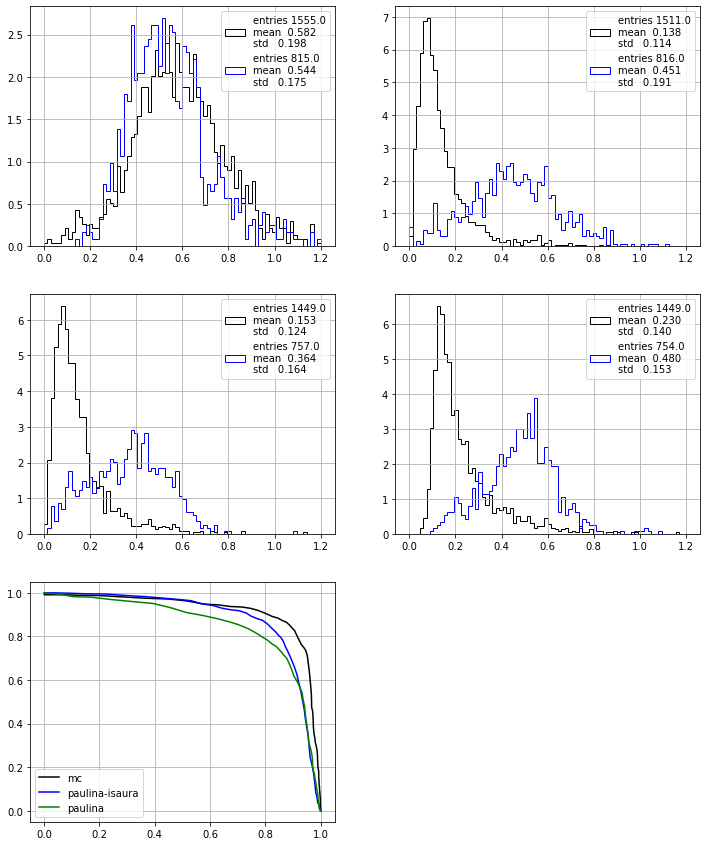

In [126]:
canvas = pltext.canvas(5, 2)
nbins, erange = 80, (0., 1.2)
canvas(1)
esel1 = (dd.dataclass == 0) & (dd.segextreme == 'blob1') & (dd.graphid == 0)
esel2 = (dd.dataclass == 1) & (dd.segextreme == 'blob1') & (dd.graphid == 0)
pltext.hist(dd.energy[esel1], nbins, erange, density = True);
pltext.hist(dd.energy[esel2], nbins, erange, density = True);
canvas(2)
esel1 = (dd.dataclass == 0) & (dd.segextreme == 'start') & (dd.graphid == 0)
esel2 = (dd.dataclass == 1) & (dd.segextreme == 'blob2') & (dd.graphid == 0)
pltext.hist(dd.energy[esel1], nbins, erange, density = True);
pltext.hist(dd.energy[esel2], nbins, erange, density = True);
canvas(3)
esela = (dd.dataclass == 0) & (dd.segpaulina == 'blob2') & (dd.graphid == 0) #& (dd.graphsize == dd.graphecc +1)
eselb = (dd.dataclass == 1) & (dd.segpaulina == 'blob2') & (dd.graphid == 0) #& (dd.graphsize == dd.graphecc +1)
pltext.hist(dd.energy[esela], nbins, erange, density = True);
pltext.hist(dd.energy[eselb], nbins, erange, density = True);
canvas(4)
pltext.hist(dd.epaulina[esela], nbins, erange, density = True);
pltext.hist(dd.epaulina[eselb], nbins, erange, density = True);
canvas(5)
#esela1 = (dd.dataclass == 0) & (dd.segpaulina == 'blob2') & (dd.graphid == 0) & (dd.graphsize == dd.graphecc +1)
#eselb1 = (dd.dataclass == 1) & (dd.segpaulina == 'blob2') & (dd.graphid == 0) & (dd.graphsize == dd.graphecc +1)
roc(dd.energy[esel1]  , dd.energy[esel2]  , 100, (0., 1.2), label = 'mc');
roc(dd.epaulina[esela], dd.epaulina[eselb], 100, (0., 1.2), label = 'paulina-isaura'); 
roc(dd.energy[esela]  , dd.energy[eselb], 100, (0., 1.2), label = 'paulina'); 
#roc(dd.epaulina[esela1]  , dd.epaulina[eselb1], 100, (0., 1.2), label = 'paulina1'); 
plt.grid(); plt.legend();

In [46]:
dd.columns

Index(['node', 'energy', 'nvoxles', 'segclass', 'segextreme', 'segpaulina',
       'epaulina', 'links', 'nlinks', 'eccentricity', 'eccdistance',
       'eneorder', 'graphid', 'graphene', 'graphsize', 'graphecc', 'graphnecc',
       'graphcycles', 'dataclass', 'event'],
      dtype='object')

In [59]:
def _plot(dd, seg = 'blob1', usel = dd.dataclass >= 0):
    %matplotlib inline
    labels  = ['e', 'bb']
    histos = (('energy', 50, (0., 1.8), 'energy (MeV)'),
              ('nvoxles', 100, (0, 100), 'number of voxels'),
              ('graphene', 50, (1.4, 1.8), 'energy graph (MeV)'),
              ('graphsize', 30, (0, 30), 'nodes in graph'),
              ('graphecc',  30, (0, 30), 'graph diameter'),
              ('graphnecc', 10, (0, 10), 'number of eccetric nodes'),
              ('graphcycles', 10, (0, 10), 'number of cycles'),
              ('eccentricity', 20, (0, 20), 'eccentricity'),
              ('eccdistance', 10, (0, 10), 'distance to extreme'),
              ('eneorder', 10, (0, 10), 'order in eneergy'))
    canvas = pltext.canvas(len(histos), 3)
    for k, histo in enumerate(histos):
        canvas(k +1)
        name, bins, xrange, xlabel = histo
        for i in (0, 1):
            sel = usel & (dd.dataclass == i) & (dd.graphid == 0) & (dd.segextreme == seg)
            pltext.hist(dd[name][sel], bins, xrange, label = labels[i], 
                     density = True, alpha = 0.2, fill = True, lw = 2)
        plt.xlabel(xlabel); plt.grid();
        plt.legend();
    plt.tight_layout()
    return

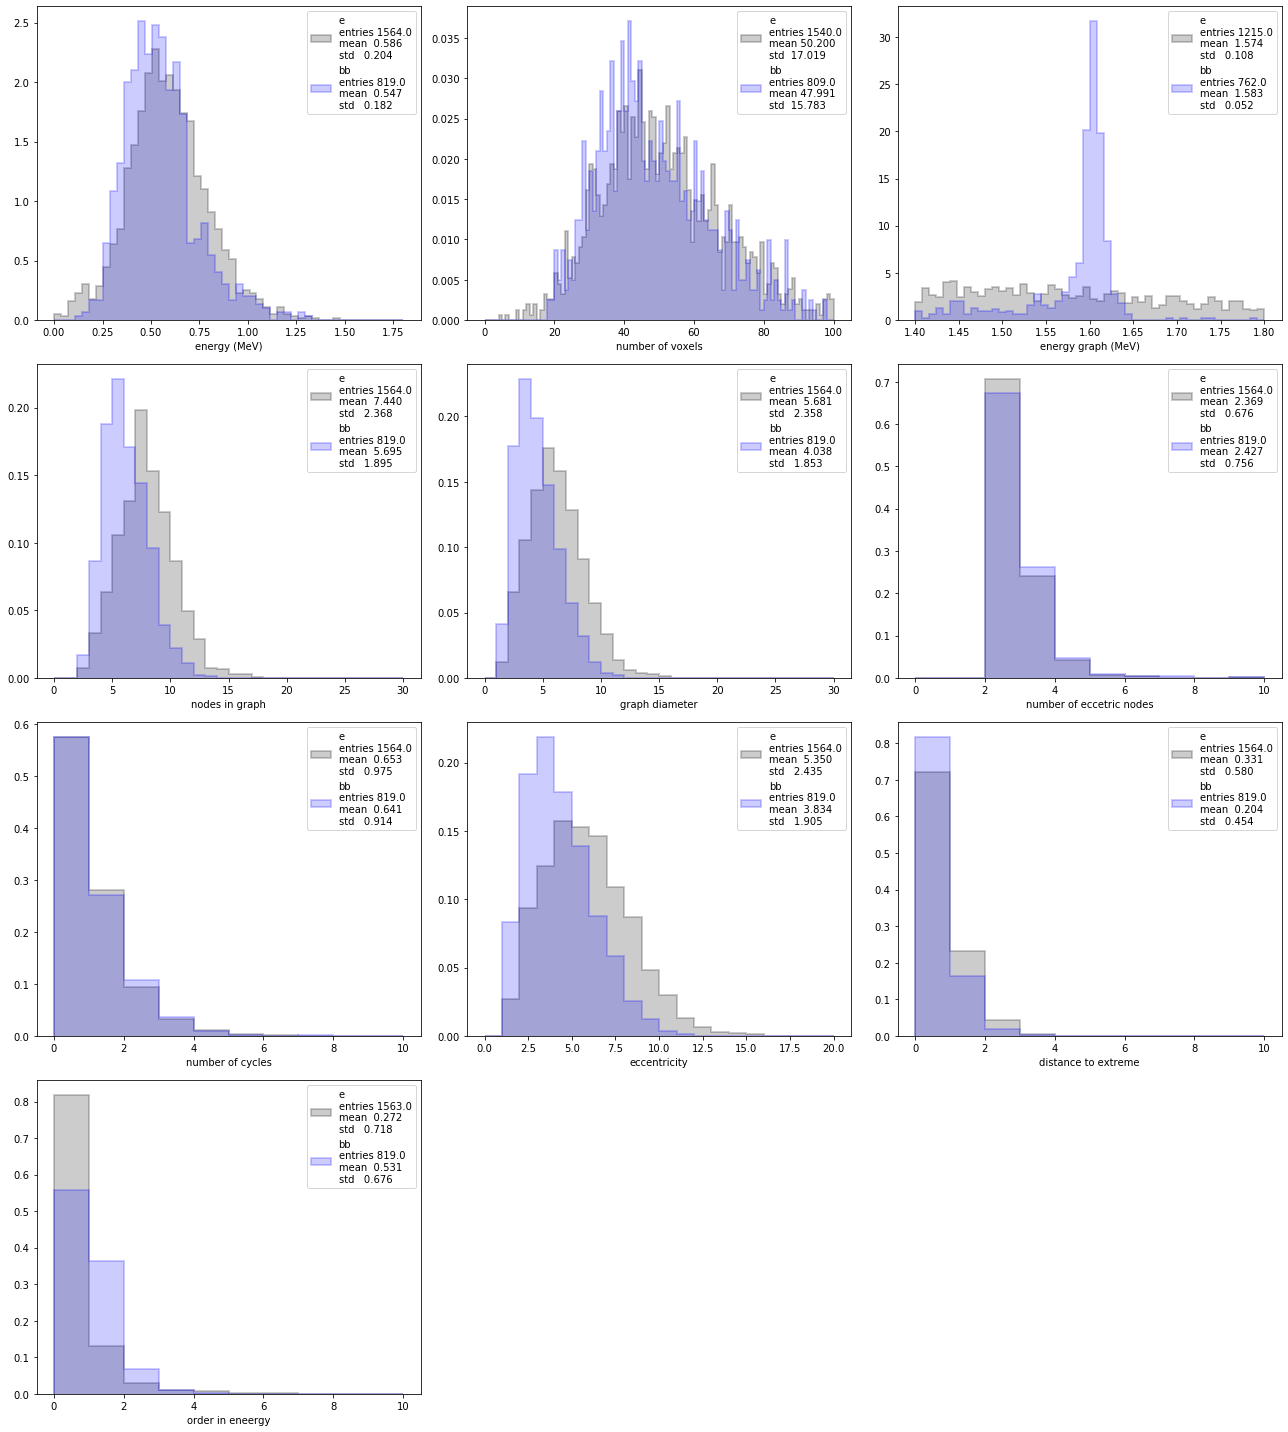

In [60]:
_plot(dd)

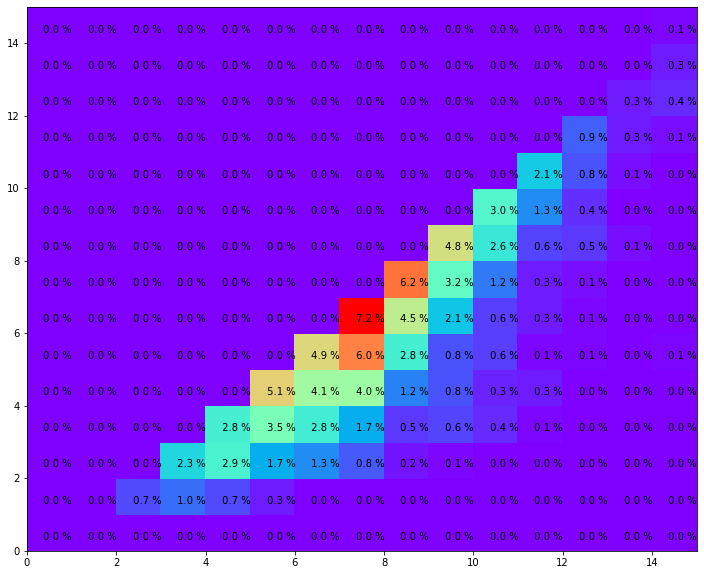

In [70]:
plt.figure(figsize = (12, 10));
esel1 = (dd.dataclass == 0) & (dd.segextreme == 'blob1') & (dd.graphid == 0) 
hist2d_text(dd[esel1].graphsize, dd[esel1].eccentricity, (15, 15), ((0, 15), (0, 15)), density = True);

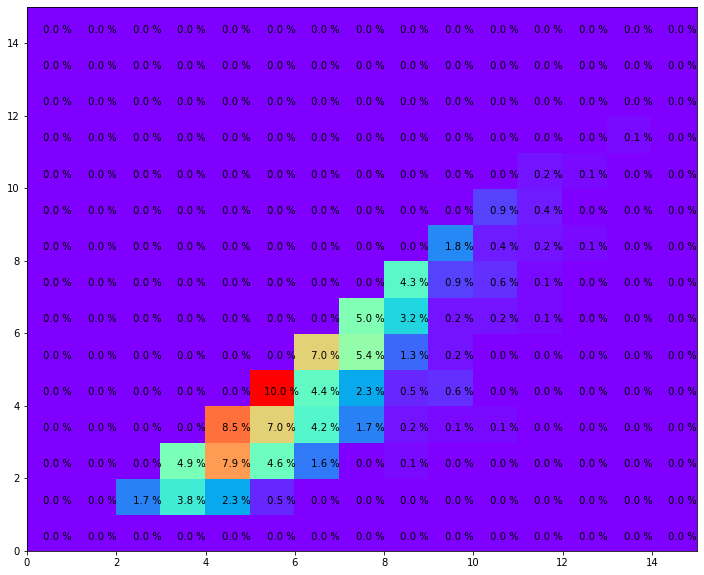

In [71]:
plt.figure(figsize = (12, 10));
esel1 = (dd.dataclass == 1) & (dd.segextreme == 'blob1') & (dd.graphid == 0) 
hist2d_text(dd[esel1].graphsize, dd[esel1].eccentricity, (15, 15), ((0, 15), (0, 15)), density = True);

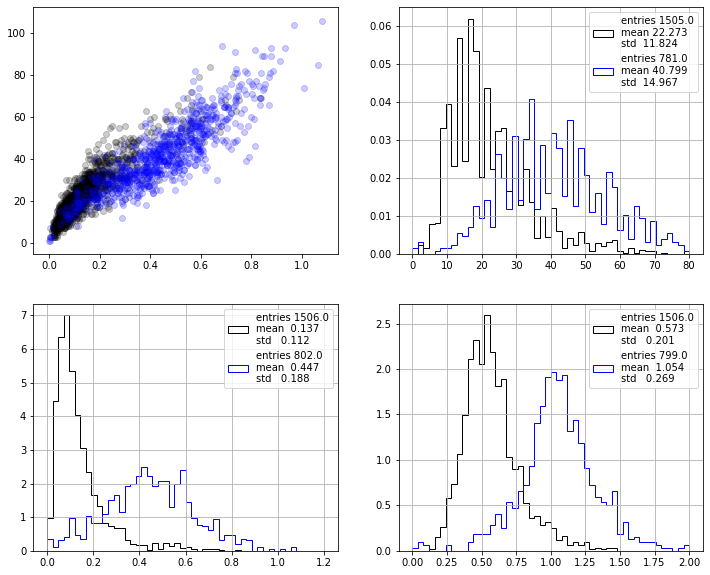

In [652]:
canvas = pltext.canvas(4, 2)
nbins  = 50
esel1 = (dd.dataclass == 0) & (dd.segextreme == 'start') & (dd.graphid == 0) & (dd.graphsize > 2)# & (dd.graphsize-1 == dd.eccentricity)
esel2 = (dd.dataclass == 1) & (dd.segextreme == 'blob2') & (dd.graphid == 0) & (dd.graphsize > 2)# & (dd.graphsize-1 == dd.eccentricity)
var1 = dd[esel1].energy.values
var2 = dd[esel1]['size'].values
len(var1), len(var2)
canvas(1)
plt.scatter(dd[esel1].energy, dd[esel1]['size'], alpha = 0.2);
plt.scatter(dd[esel2].energy, dd[esel2]['size'], alpha = 0.2);
canvas(2)
pltext.hist(dd[esel1]['size'], nbins, (0., 80), density = True);
pltext.hist(dd[esel2]['size'], nbins, (0., 80), density = True);
canvas(3)
pltext.hist(dd[esel1]['energy'], nbins, (0., 1.2), density = True);
pltext.hist(dd[esel2]['energy'], nbins, (0., 1.2), density = True);
canvas(4)
pltext.hist(100*dd.energy[esel1]/dd[esel1]['size'], nbins, (0., 2.), density = True);
pltext.hist(100*dd.energy[esel2]/dd[esel2]['size'], nbins, (0., 2.), density = True);

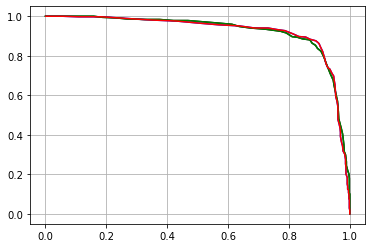

In [666]:
for n in (2, 2):
    esel1 = (dd.dataclass == 0) & (dd.segextreme == 'start') & (dd.graphid == 0) & (dd.graphsize-1 == dd.eccentricity)
    esel2 = (dd.dataclass == 1) & (dd.segextreme == 'blob2') & (dd.graphid == 0) & (dd.graphsize-1 == dd.eccentricity)
    den1 = 100*dd.energy[esel1]/dd[esel1]['size']
    den2 = 100*dd.energy[esel2]/dd[esel2]['size']
    roc(den1, den2, 100, (0., 2.));
    den1 = dd.energy[esel1]
    den2 = dd.energy[esel2]
    roc(den1, den2, 100, (0., 1.2)); 
plt.grid();

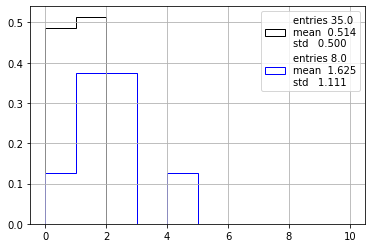

In [682]:
esel1 = (dd.dataclass == 0) & (dd.segextreme == 'start') & (dd.graphid == 0) & (dd.graphsize == dd.eccentricity + 5)
esel2 = (dd.dataclass == 1) & (dd.segextreme == 'blob2') & (dd.graphid == 0) & (dd.graphsize == dd.eccentricity + 5)
pltext.hist(dd.eccdistance[esel1], 10, (0, 10), density = True);
pltext.hist(dd.eccdistance[esel2], 10, (0, 10), density = True);

In [ ]:
plt.hist(dd.eccentricity)

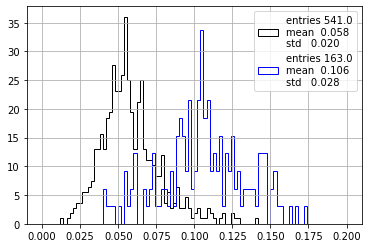

In [645]:
pltext.hist(10*dd.energy[esel1]/dd[esel1]['size'], 100, (0., 0.2), density = True);
pltext.hist(10*dd.energy[esel2]/dd[esel2]['size'], 100, (0., 0.2), density = True);

In [ ]:
esel1 = (dd.dataclass == 0) & (dd.segextreme == 'blob1')
esel2 = (dd.dataclass == 0) & (dd.segextreme == 'start')
pltext.hist(dd.energy[esel1], 100, (0., 1.2));
pltext.hist(dd.energy[esel2], 100, (0., 1.2));

In [223]:
dd.columns

Index(['nnodes', 'nedges', 'diameter', 'extremes', 'eccentric', 'cycles',
       'ngraphs', 'ene', 'enegraph', 'eblob1', 'eblob2', 'sizeblob1',
       'sizeblob2', 'disgraph1', 'disgraph2', 'disene1', 'disene2',
       'dataclass', 'event'],
      dtype='object')

### Plots

In [224]:
def plot_graph_features(dd, usel = dd.dataclass >= 0):
    %matplotlib inline
    labels  = ['e', 'bb']
    histos = (('ene', 50, (1.4, 1.8), 'energy (MeV)'),
              ('ngraphs', 10, (0, 10), 'number of graphs'),
              ('enegraph', 50, (1.4, 1.8), 'energy graph (MeV)'),
              ('nnodes', 20, (0, 20), 'nodes'),
              ('nedges', 30, (0, 30), 'edges'),
              ('diameter', 20, (0, 20), 'diameter'),
              ('extremes', 10, (0, 10), 'extremes nodes'),
              ('eccentric', 10, (0, 10), 'eccentric nodes'),
              ('cycles', 10, (0, 10), 'cycles'),
              ('eblob1', 50, (0., 1.4), 'Energy blob1 (MeV)'),
              ('eblob2', 50, (0., 1.4), 'Energy blob1 (MeV)'),
              ('sizeblob1', 120, (0, 120), 'cells in blob1'),
              ('sizeblob2', 120, (0, 120), 'cells in blob2'),
              ('disgraph1', 11, (-1, 10), 'blob1 graph distance'),
              ('disgraph2', 11, (-1, 10), 'blob2 graph distance'),
              ('disene1', 11, (-1, 10), 'blob1 energy distance'),
              ('disene2', 11, (-1, 10), 'blob2 energy distance'))   
    canvas = pltext.canvas(len(histos), 3)
    for k, histo in enumerate(histos):
        canvas(k +1)
        name, bins, xrange, xlabel = histo
        for i in (0, 1):
            sel = usel & (dd.dataclass == i)
            plt.hist(dd[name][sel], bins, xrange, label = labels[i], 
                     density = True, alpha = 0.5, fill = True, lw = 2)
        plt.xlabel(xlabel); plt.grid();
        plt.legend();
    plt.tight_layout()
    return

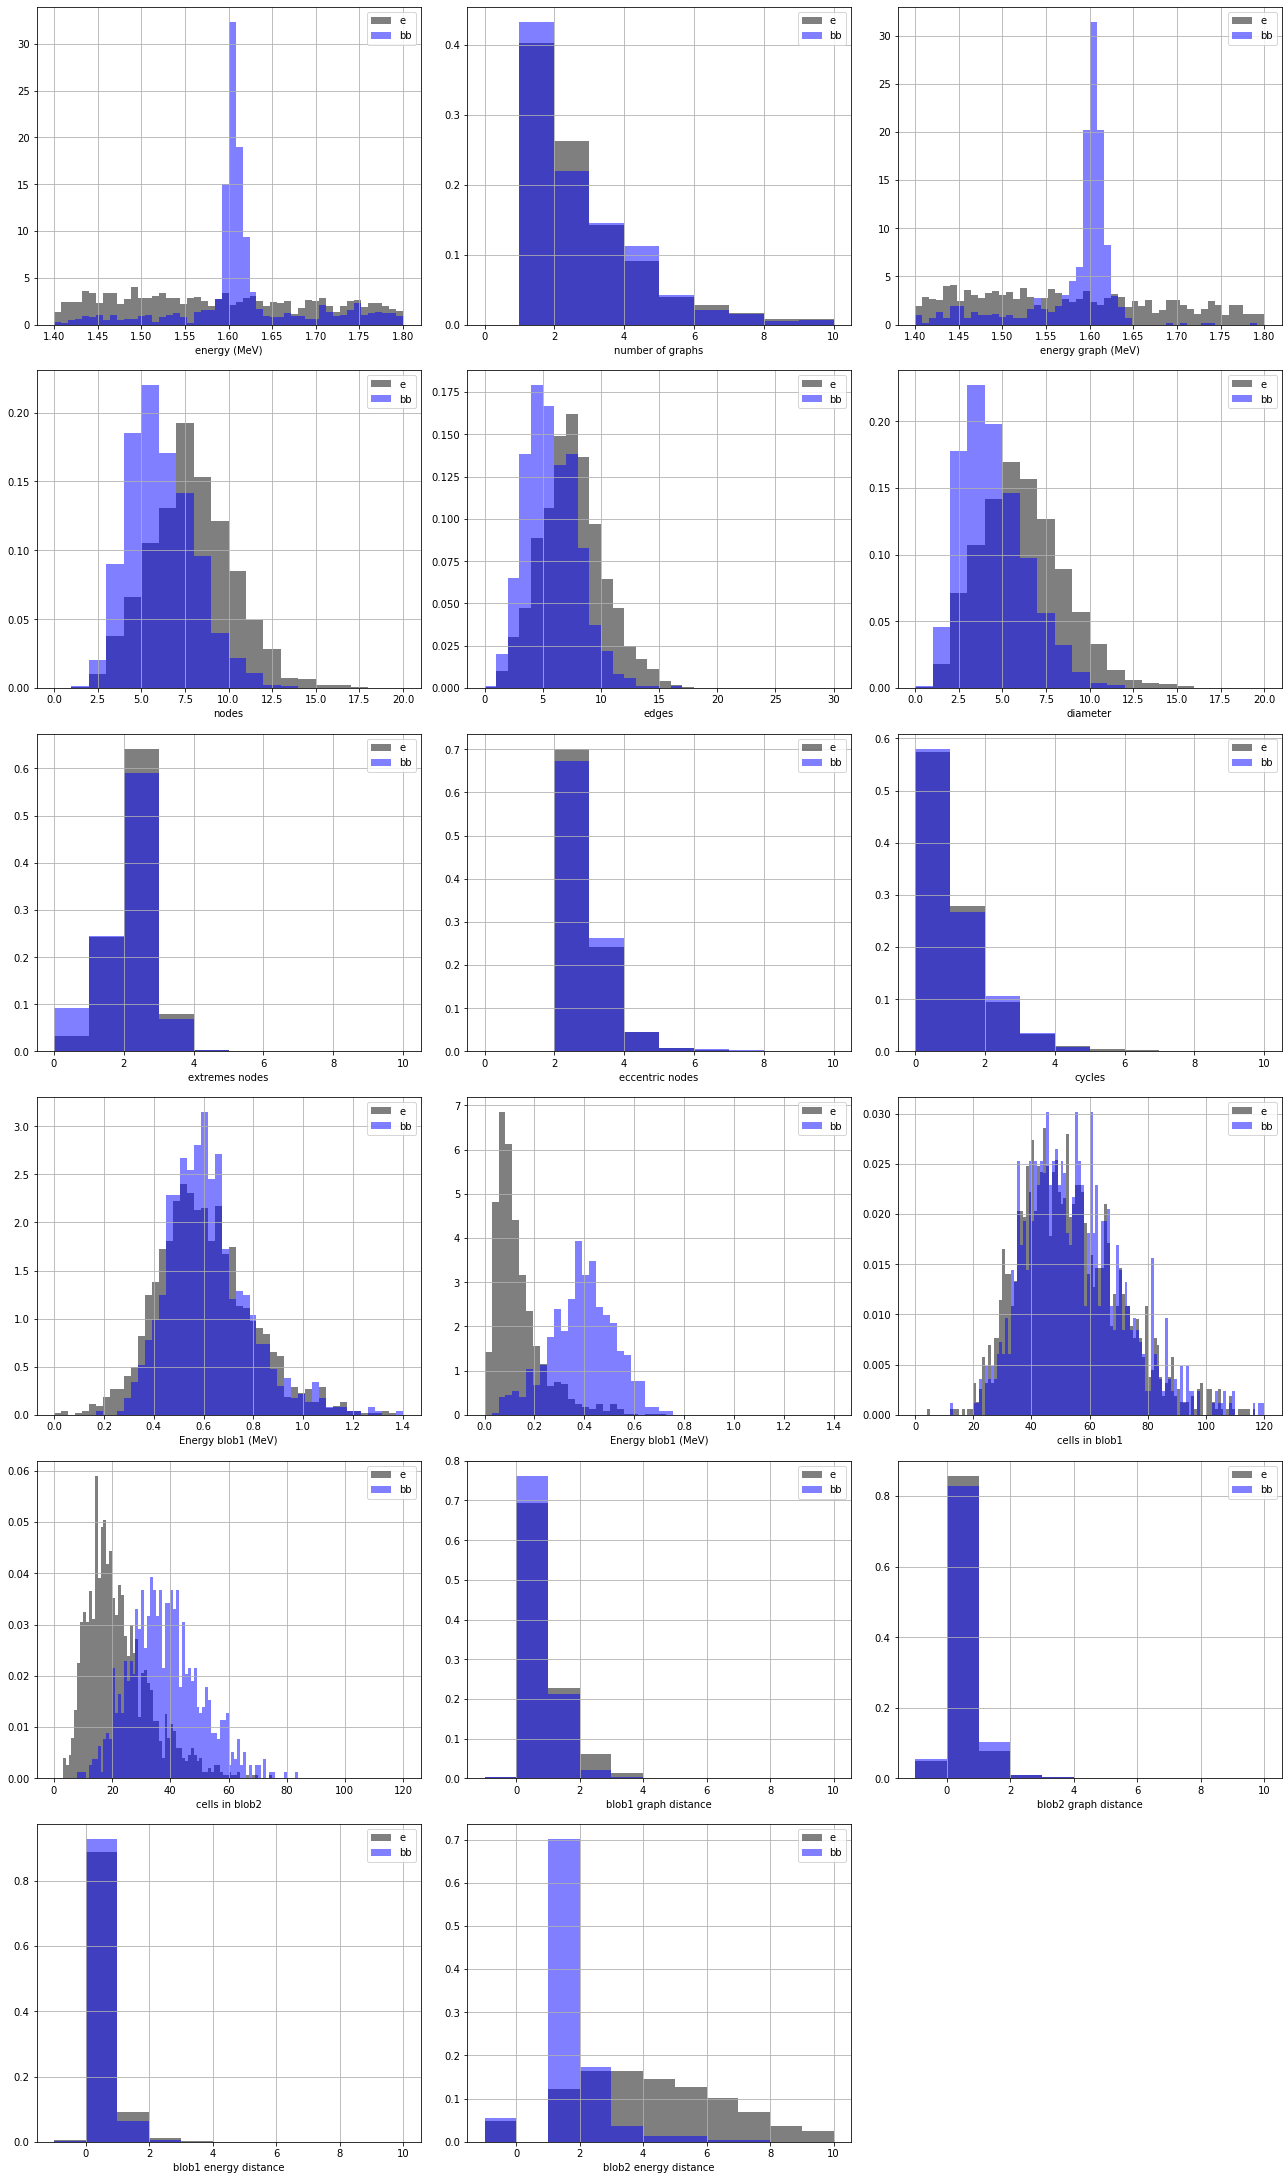

In [225]:
plot_graph_features(dd)

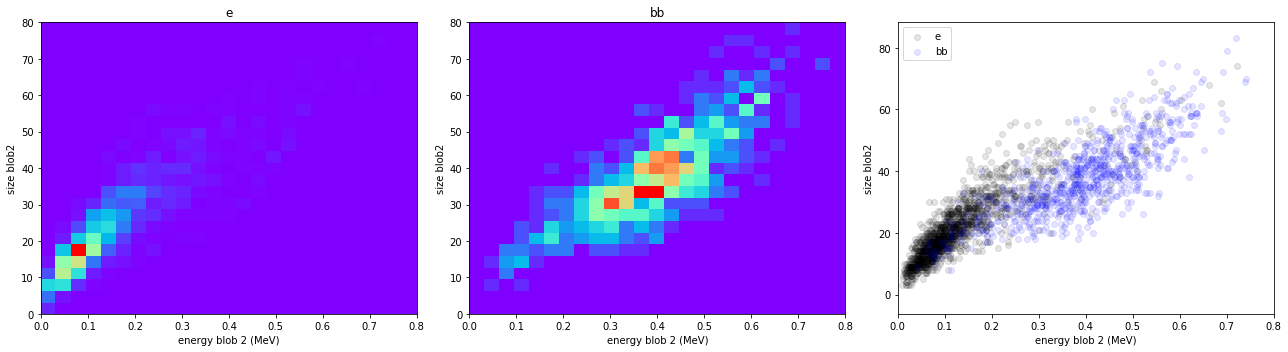

In [263]:
%matplotlib inline
canvas = pltext.canvas(3, 3)
canvas(1)
sel = dd.dataclass == 0
plt.hist2d(dd.eblob2[sel], dd.sizeblob2[sel], (25, 25), ((0., 0.8), (0., 80)));
plt.xlabel('energy blob 2 (MeV)'); plt.ylabel('size blob2'); plt.title('e')
canvas(2)
sel = dd.dataclass == 1
plt.hist2d(dd.eblob2[sel], dd.sizeblob2[sel], (25, 25), ((0., 0.8), (0., 80)));
plt.xlabel('energy blob 2 (MeV)'); plt.ylabel('size blob2'); plt.title('bb')
canvas(3)
sel = dd.dataclass == 0
plt.scatter(dd.eblob2[sel], dd.sizeblob2[sel], alpha = 0.1, label = 'e');
sel = dd.dataclass == 1
plt.scatter(dd.eblob2[sel], dd.sizeblob2[sel], alpha = 0.1, label = 'bb');
plt.xlabel('energy blob 2 (MeV)'); plt.ylabel('size blob2'); plt.legend();
plt.xlim((0., 0.8));
plt.tight_layout();

In [268]:
sel  = (dd.dataclass == 0) & (dd.eblob2 < 0)
evts = np.unique(dd.event[sel])
print('e events with no start in the graph', evts[:10])
print('bb possible track splitting {:6.2f} %'.format(100.*np.sum(sel)/np.sum(dd.dataclass == 0)))
sel  = (dd.dataclass == 1) & (dd.eblob2 < 0)
evts = np.unique(dd.event[sel])
print('bb events with no blobs in the graph', evts[:10])
print('bb possible track splitting {:6.2f} %'.format(100.*np.sum(sel)/np.sum(dd.dataclass == 1)))

e events with no start in the graph [38 83 91 109 152 192 215 271 278 338]
bb possible track splitting   4.86 %
bb events with no blobs in the graph [196 208 223 301 516 670 757 776 799 814]
bb possible track splitting   5.40 %


### Conclusions

   * Features with differences: diameter, number of nodes, edges
   
   * Physical differences: energy and size of 2nd blob
   
   * for bb: both blobs are within 2-nodes of the eccentric nodes.
   
   * From the scatter plots, it seems that we can gain using a BDT combining size, energy of the blob
   
   * for e: The start is 90% time in an eccentric node, otherwise in the next node!
   
   * Why there are 20% of the electrons where the start is not in the graph?

       * It seems that the problem are splitted Beersheba tracks!!

## Clouds Run

In [392]:
eblob1_e,  eblob2_e  = bc.paulina_blobs_energy(dfs, 0)
eblob1_bb, eblob2_bb = bc.paulina_blobs_energy(dfs, 1)

In [408]:
idd = bc.ana_graph_blobs(clouds)
idd[idd.method == 'graph']

nnodes nedges diameter extremes eccentric cycles method ngraphs     ene  \
3      6      5        5        2         2      0  graph       1  1.5094   

  enegraph  ...    eblob1      eblob2 sizeblob1 sizeblob2 disgraph1 disgraph2  \
3   1.5094  ...  0.314904  0.00274746        32         2         0         0   

  disene1 disene2 success1 success2  
3       2       5     True    False  

[1 rows x 22 columns]

In [409]:
idd = bc.ana_mcblob_success(clouds)
idd[idd.method == 'graph']

method  node1  node2      ene1      ene2  size1  size2 success1 success2  \
3  graph      1    116  0.002747  0.314904      2     32    False     True   

   disgraph1  disgraph2  disene1  disene2  
3          2          0        5        2

In [432]:
#dd = bc.run(filename, bc.ana_mcblob_success, -1)
dd = bc.run(filename, bc.ana_graph_blobs, -1)

Filename :  /Users/hernando/work/investigacion/NEXT/data/MC/NEW/ds/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut50.beersheba_label_4mm.h5
Events  : 2420
event  0
event  100
event  200
event  300
event  400
event  500
event  600
event  700
event  800
event  900
event  1000
event  1100
event  1200
event  1300
event  1400
event  1500
event  1600
event  1700
event  1800
event  1900
event  2000
event  2100
event  2200
event  2300
event  2400
processed number of events  2420
clouds failures             30


In [433]:
dd

nnodes nedges diameter extremes eccentric cycles   method ngraphs  \
0         7     10        3        0         4      4       mc       1   
1         7     10        3        0         4      4  paulina       1   
2         7     10        3        0         4      4   maxene       1   
3         7     10        3        0         4      4    graph       1   
4         5      4        3        3         3      0       mc       9   
...     ...    ...      ...      ...       ...    ...      ...     ...   
9555      7      6        6        2         2      0    graph       1   
9556      9      9        7        1         3      1       mc       2   
9557      9      9        7        1         3      1  paulina       2   
9558      9      9        7        1         3      1   maxene       2   
9559      9      9        7        1         3      1    graph       2   

          ene enegraph  ... sizeblob1 sizeblob2 disgraph1 disgraph2 disene1  \
0     1.63214  1.63214  ...        48        24         0         0       0   
1     1.63214  1.63214  ...        24        24         0         0       3   
2     1.63214  1.63214  ...        48        38         0         1       0   
3     1.63214  1.63214  ...        48        24         0         0       0   
4     1.71048  1.00902  ...        55        33         0         1       0   
...       ...      ...  ...       ...       ...       ...       ...     ...   
9555  1.53419  1.53419  ...        44        27         0         0       0   
9556  1.65582  1.65546  ...        29        16         0         0       0   
9557  1.65582  1.65546  ...        29        16         0         0       0   
9558  1.65582  1.65546  ...        29        39         0         2       0   
9559  1.65582  1.65546  ...        29        16         0         0       0   

     disene2 success1 success2 dataclass event  
0          5     True     True         0     1  
1          5    False     True         0     1  
2          1     True    False         0     1  
3          3     True    False         0     1  
4          1     True     True         0     2  
...      ...      ...      ...       ...   ...  
9555       4     True     True         0  2418  
9556       4     True     True         0  2419  
9557       4     True     True         0  2419  
9558       1     True    False         0  2419  
9559       4     True     True         0  2419  

[9560 rows x 24 columns]

In [434]:
name1, name2 = 'eblob1', 'eblob2'
esel  = dd.dataclass == 0
bbsel = dd.dataclass == 1
for method in methods:
    sela = esel   & (dd[name2] > dd[name1]) & (dd.method == method)
    selb = bbsel  & (dd[name2] > dd[name1]) & (dd.method == method)
    print('method ', method, ', e b2 > b1', np.sum(sela), ', bb b2 > b1', np.sum(selb))
print('paulina-isaura, e ', np.sum(eblob2_e > eblob1_e), ', bb ', np.sum(eblob2_bb > eblob1_bb))

method  mc , e b2 > b1 0 , bb b2 > b1 0
method  paulina , e b2 > b1 0 , bb b2 > b1 0
method  maxene , e b2 > b1 0 , bb b2 > b1 0
method  graph , e b2 > b1 0 , bb b2 > b1 0
paulina-isaura, e  0 , bb  0


In [435]:
ehits.columns

Index(['x', 'y', 'z', 'hit_id', 'particle_id', 'energy', 'segclass',
       'binclass', 'dist_hits', 'cumdist', 'particle_name', 'creator_proc',
       'group_ener', 'small_b', 'dataset_id'],
      dtype='object')

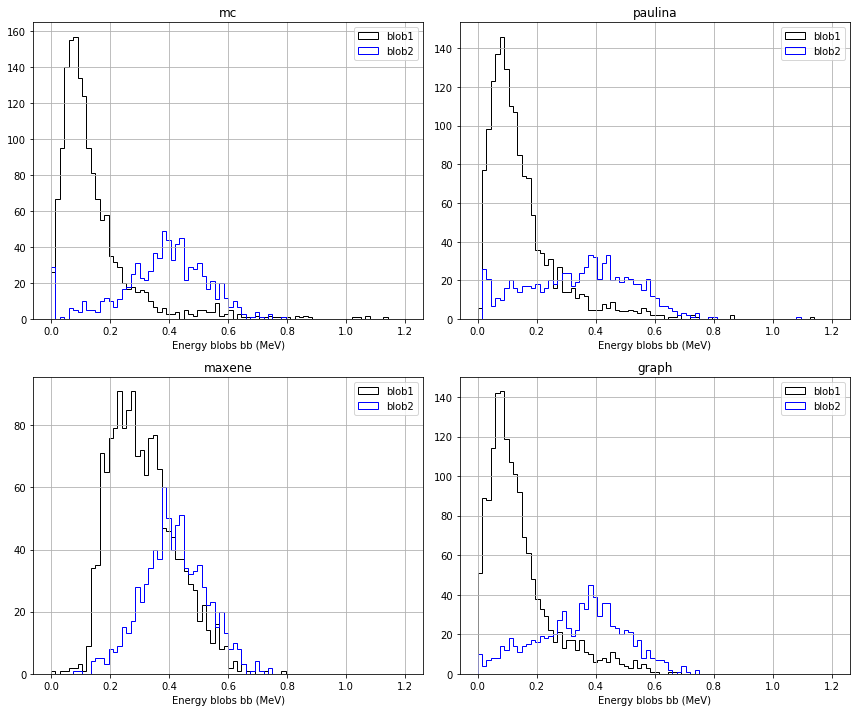

In [399]:
sel    = dd.dataclass == 1
name   = 'ene2'
canvas = pltext.canvas(len(methods), 2)
esel   = dd.dataclass == 0
bbsel  = dd.dataclass == 1
for i, method in enumerate(methods):
    canvas(i + 1)
    isel = (dd.method == method)
    pltext.hist(dd[name][esel  & isel].values, 80, (0, 1.2), label = 'blob1', stats = False)
    pltext.hist(dd[name][bbsel & isel].values, 80, (0, 1.2), label = 'blob2', stats = False)
    plt.title(method); plt.legend(); plt.xlabel('Energy blobs bb (MeV)');
plt.tight_layout();

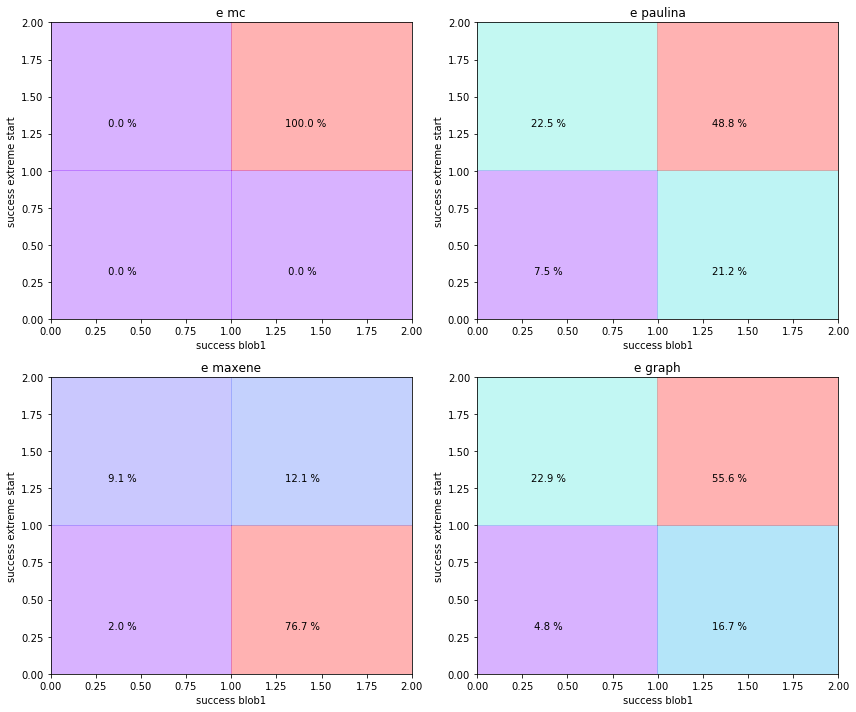

In [401]:
methods = ('mc', 'paulina', 'maxene', 'graph')
canvas  = pltext.canvas(len(methods), 2)
for i, method in enumerate(methods):
    canvas(i+1)
    sel = (dd.dataclass == 0) & (dd.method == method)
    hist2d_text(dd.success1[sel], dd.success2[sel], (2, 2), ((0, 2), (0, 2)), alpha = 0.3, density = True);
    plt.xlabel('success blob1'); plt.ylabel('success extreme start'); plt.title('e '+str(methods[i]));
plt.tight_layout();

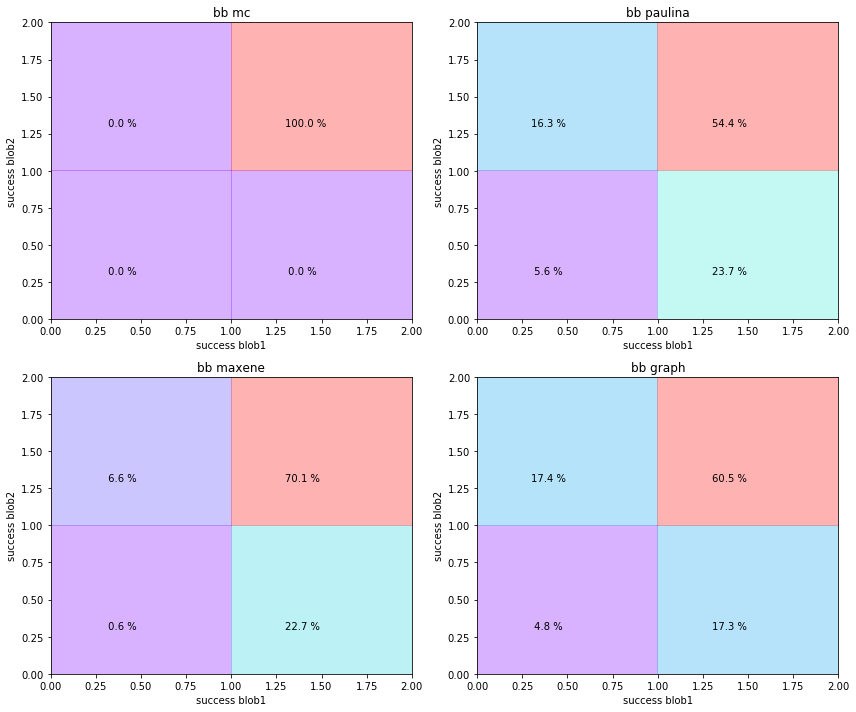

In [402]:
methods = ('mc', 'paulina', 'maxene', 'graph')
canvas  = pltext.canvas(len(methods), 2)
for i, method in enumerate(methods):
    canvas(i+1)
    sel = (dd.dataclass == 1) & (dd.method == method)
    hist2d_text(dd.success1[sel], dd.success2[sel], (2, 2), ((0, 2), (0, 2)), alpha = 0.3, density = True);
    plt.xlabel('success blob1'); plt.ylabel('success blob2'); plt.title('bb '+str(methods[i]));
plt.tight_layout();

In [403]:
dd.columns

Index(['method', 'node1', 'node2', 'ene1', 'ene2', 'size1', 'size2',
       'success1', 'success2', 'disgraph1', 'disgraph2', 'disene1', 'disene2',
       'dataclass', 'event'],
      dtype='object')

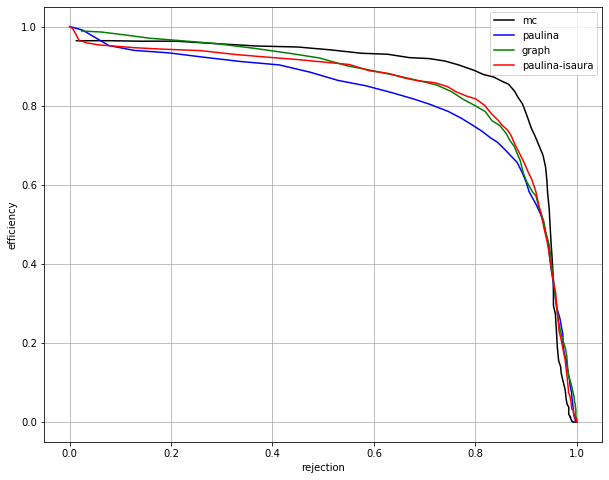

In [405]:
plt.figure(figsize = (10, 8))
nbins  = 100
name   = 'ene2'
erange = (0., 1.2)
sele  = dd.dataclass == 0
selbb = dd.dataclass == 1
for method in ('mc', 'paulina', 'graph'):
    isel = dd.method == method
    var1 = dd[name][isel & sele].values
    var2 = dd[name][isel & selbb].values
    roc(var1, var2, nbins, erange, label = method)
roc(eblob2_e, eblob2_bb, nbins, erange, label = 'paulina-isaura')
plt.legend();
plt.grid(which = 'both'); plt.xlabel('rejection'); plt.ylabel('efficiency');

In [329]:
dd

nnodes nedges diameter extremes eccentric cycles   method ngraphs      ene  \
0       7     10        3        0         4      4       mc       1  1.63214   
1       7     10        3        0         4      4  paulina       1  1.63214   
2       7     10        3        0         4      4   maxene       1  1.63214   
3       7     10        3        0         4      4    graph       1  1.63214   
4       5      4        3        3         3      0       mc       9  1.71048   
5       5      4        3        3         3      0  paulina       9  1.71048   
6       5      4        3        3         3      0   maxene       9  1.71048   
7       5      4        3        3         3      0    graph       9  1.71048   
8       6      5        5        2         2      0       mc       1   1.4637   
9       6      5        5        2         2      0  paulina       1   1.4637   
10      6      5        5        2         2      0   maxene       1   1.4637   
11      6      5        5        2         2      0    graph       1   1.4637   
12      8      7        7        2         2      0       mc       1  1.60889   
13      8      7        7        2         2      0  paulina       1  1.60889   
14      8      7        7        2         2      0   maxene       1  1.60889   
15      8      7        7        2         2      0    graph       1  1.60889   
16      7      7        5        2         2      1       mc       1  1.61451   
17      7      7        5        2         2      1  paulina       1  1.61451   
18      7      7        5        2         2      1   maxene       1  1.61451   
19      7      7        5        2         2      1    graph       1  1.61451   
20      6      5        5        2         2      0       mc       2  1.60512   
21      6      5        5        2         2      0  paulina       2  1.60512   
22      6      5        5        2         2      0   maxene       2  1.60512   
23      6      5        5        2         2      0    graph       2  1.60512   
24      6      5        4        3         2      0       mc       1  1.59978   
25      6      5        4        3         2      0  paulina       1  1.59978   
26      6      5        4        3         2      0   maxene       1  1.59978   
27      6      5        4        3         2      0    graph       1  1.59978   
28      8      8        6        1         3      1       mc       1  1.80105   
29      8      8        6        1         3      1  paulina       1  1.80105   
30      8      8        6        1         3      1   maxene       1  1.80105   
31      8      8        6        1         3      1    graph       1  1.80105   
32      7      6        6        2         2      0       mc       1  1.41038   
33      7      6        6        2         2      0  paulina       1  1.41038   
34      7      6        6        2         2      0   maxene       1  1.41038   
35      7      6        6        2         2      0    graph       1  1.41038   

   enegraph  ... sizeblob1 sizeblob2 disgraph1 disgraph2 disene1 disene2  \
0   1.63214  ...        48        24         0         0       0       5   
1   1.63214  ...        24        24         0         0       3       5   
2   1.63214  ...        48        38         0         1       0       1   
3   1.63214  ...        48        24         0         0       0       3   
4   1.00902  ...        55        33         0         1       0       1   
5   1.00902  ...        55        12         0         0       0       3   
6   1.00902  ...        55        33         0         1       0       1   
7   1.00902  ...        55        12         0         0       0       3   
8    1.4637  ...        66        15         1         0       0       5   
9    1.4637  ...        40        17         0         1       1       3   
10   1.4637  ...        66        40         1         0       0       1   
11   1.4637  ...        40        15         0         0       1       5   
12  1.60889  ... 

In [75]:
idd = bc.ana_graph_categories(clouds)
print(idd)

ngraphs                         1
energy         1.5094027103854486
nnodes                          6
next                            2
nloops                          0
necc                            2
ecc                             5
egraph0        1.5094027103854486
eblob1         0.3149040707858204
eblob2       0.002747457963482071
sblob1                         32
sblob2                          2
success1                     True
success2                    False
disgraph1                       2
disgraph2                       0
disene1                         2
disene2                         5
dtype: object


In [76]:
idd = bc.ana_mcblob_success(clouds)
idd

method  node1  node2      ene1      ene2  size1  size2 success1 success2  \
0       mc     94    116  0.450099  0.314904     45     32     True     True   
1  paulina     94     29  0.450099  0.254321     45     40     True    False   
2   maxene     94     92  0.450099  0.351091     45     37     True    False   
3    graph      1    116  0.002747  0.314904      2     32    False     True   

   disgraph1  disgraph2  disene1  disene2  
0          0          0        0        2  
1          0          1        0        3  
2          0          3        0        1  
3          2          0        5        2

## RUN

In [790]:
dd = bc.run(filename, bc.ana_graph_categories, -1, axis = 1)

Filename :  /Users/hernando/work/investigacion/NEXT/data/MC/NEW/ds/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut50.beersheba_label_4mm.h5
Events  : 2420
event  0
event  100
event  200
event  300
event  400
event  500
event  600
event  700
event  800
event  900
event  1000
event  1100
event  1200
event  1300
event  1400
event  1500
event  1600
event  1700
event  1800
event  1900
event  2000
event  2100
event  2200
event  2300
event  2400
processed number of events  2420
clouds failures             2


In [791]:
dd

ngraphs              energy nnodes nconn1 nloops nextr ecc  \
0          2  1.4498084968474112      8      2      0     2   7   
1          1  1.6321425257409525      7      0      4     4   3   
2          9  1.7104771453194734      5      3      0     3   3   
3          1  1.4637010886285453      6      2      0     2   5   
4          1  1.6088910458822392      8      2      0     2   7   
...      ...                 ...    ...    ...    ...   ...  ..   
2413       1   1.605223869776916      3      2      0     2   2   
2414       1   1.681831577780788      9      1      1     3   7   
2415       2  1.7147209144290447      7      1      1     3   5   
2416       1    1.53418571728758      7      2      0     2   6   
2417       2  1.6558179307606085      9      1      1     3   7   

                 egraph0               eblob1                eblob2 sblob1  \
0     1.4314534547696087  0.48420707773713195  0.040771260301676764     53   
1     1.6321425257409525   0.6826369695030859   0.13775480643944044     48   
2     1.0090191290863455   0.6405293284139011  0.026493689688501625     55   
3     1.4637010886285453   0.3501537090451302   0.04541591185444395     40   
4     1.6088910458822392   0.5875245939077063    0.5851947136887327     54   
...                  ...                  ...                   ...    ...   
2413   1.605223869776916    1.075223624782878    0.5070204027858041    101   
2414   1.681831577780788   0.8765414599555397   0.08897591209636983     69   
2415  1.6329247824536663   0.1279794047615725   0.11055473321209103     20   
2416    1.53418571728758   0.5370702171482589   0.14901469628452566     44   
2417  1.6554643558112685   0.4342460924367159   0.10054672361443198     29   

     sblob2 success1 success2 disgraph1 disgraph2 disene1 disene2 dataclass  \
0         8     True    False         0        -1       0       5         0   
1        24     True    False         0         1       0       3         0   
2        12     True    False         0        -1       0       3         0   
3        15    False     True         1         0       1       5         0   
4        51     True     True         0         0       0       1         1   
...     ...      ...      ...       ...       ...     ...     ...       ...   
2413     42     True    False         0         0       0       1         0   
2414     27     True     True         0         0       0       4         0   
2415     14    False    False         1         1       2       4         0   
2416     27     True     True         0         0       0       4         0   
2417     16     True     True         0         0       0       4         0   

     event  
0        0  
1        1  
2        2  
3        3  
4        4  
...    ...  
2413  2415  
2414  2416  
2415  2417  
2416  2418  
2417  2419  

[2418 rows x 20 columns]

In [796]:
%matplotlib inline
def _plot(dd, usel = dd.dataclass >= 0):
    canvas = pltext.canvas(18, 4)
    names = ['e', 'bb']
    for i in (0, 1):
        sel = usel & (dd.dataclass == i)
        
        canvas(1)
        pltext.hist(dd.energy[sel], 50, (1.2, 1.8), label = names[i],
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('energy')
        canvas(2)
        pltext.hist(dd.egraph0[sel], 50, (1.2, 1.8), label = names[i],
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('graph energy')

        canvas(3)
        pltext.hist(dd.nnodes[sel], 20, (0, 20), label = names[i],
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('number of nodes')
        canvas(4)
        pltext.hist(dd.ecc[sel], 20, (0, 20), label = names[i], 
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('eccentricity');
    
        canvas(5)
        pltext.hist(dd.nconn1[sel], 10, (0, 10), label = names[i],
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('number of nodes 1 connection')
        canvas(6)
        pltext.hist(dd.nloops[sel], 10, (0, 10), label = names[i],
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('number of loops')
    
        canvas(7)
        pltext.hist(dd.nextr[sel], 10, (0, 10), label = names[i],
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('number of extremes')
    
        canvas(9)
        pltext.hist(dd.eblob1[sel], 50, (0., 1.4), label = names[i],
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('eblob1')
        canvas(10)
        pltext.hist(dd.eblob2[sel], 50, (0, 1.4), label = names[i],
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('eblob2')
        
        canvas(11)
        pltext.hist(dd.sblob1[sel], 50, (0., 100), label = names[i],
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('size blob1')
        canvas(12)
        pltext.hist(dd.sblob2[sel], 50, (0, 100), label = names[i],
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('size blob2')
        
        canvas(13)
        pltext.hist(dd.success1[sel], 2, (0, 2), label = names[i],
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('success blob1')
        canvas(14)
        pltext.hist(dd.success2[sel], 2, (0, 2), label = names[i],
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('success blob2')
        
        canvas(15)
        pltext.hist(dd.disgraph1[sel], 10, (0, 10), label = names[i],
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('mc blob1 distance')
        canvas(16)
        pltext.hist(dd.disgraph2[sel], 10, (0, 10), label = names[i],
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('mc blob2 distance')
        
        canvas(17)
        pltext.hist(dd.disene1[sel], 10, (0, 10), label = names[i],
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('mc blob1 ene order')
        canvas(18)
        pltext.hist(dd.disene2[sel], 10, (0, 10), label = names[i],
                    stats = False, fill = True, alpha = 0.2, density = True);
        plt.title('mc blob2 ene order')

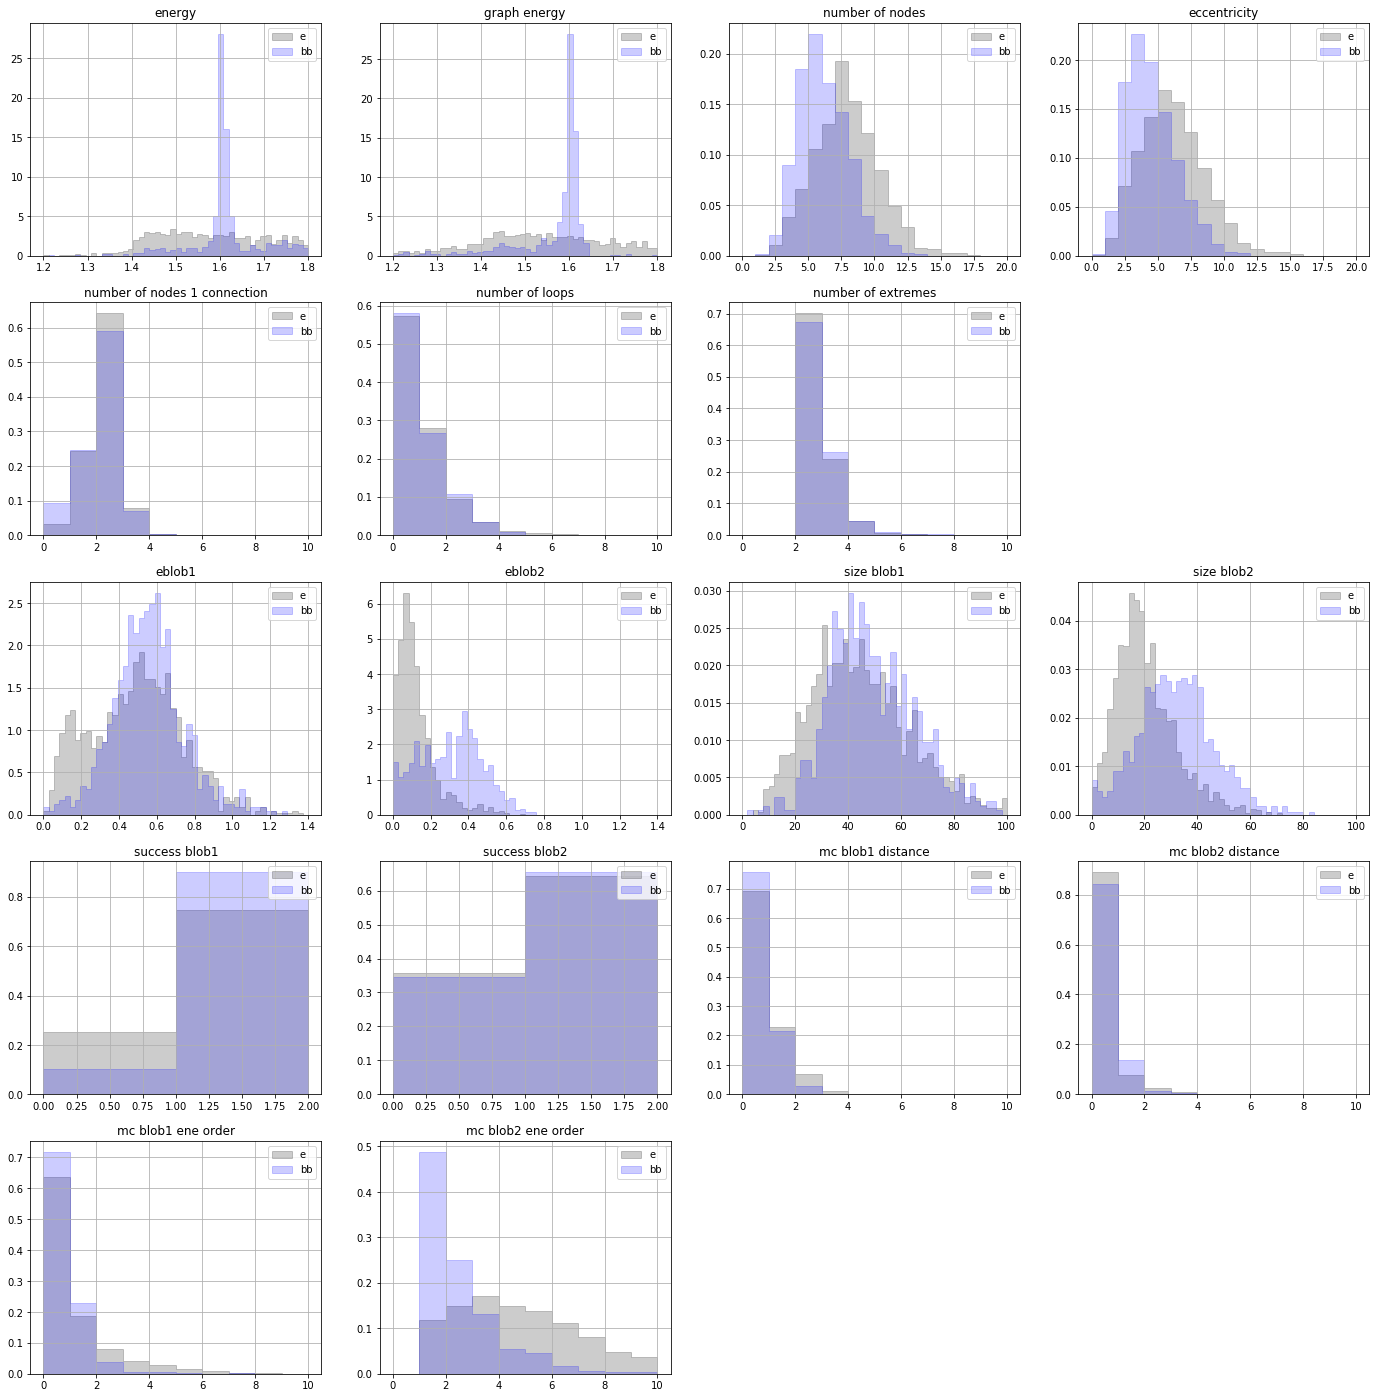

In [797]:
_plot(dd)

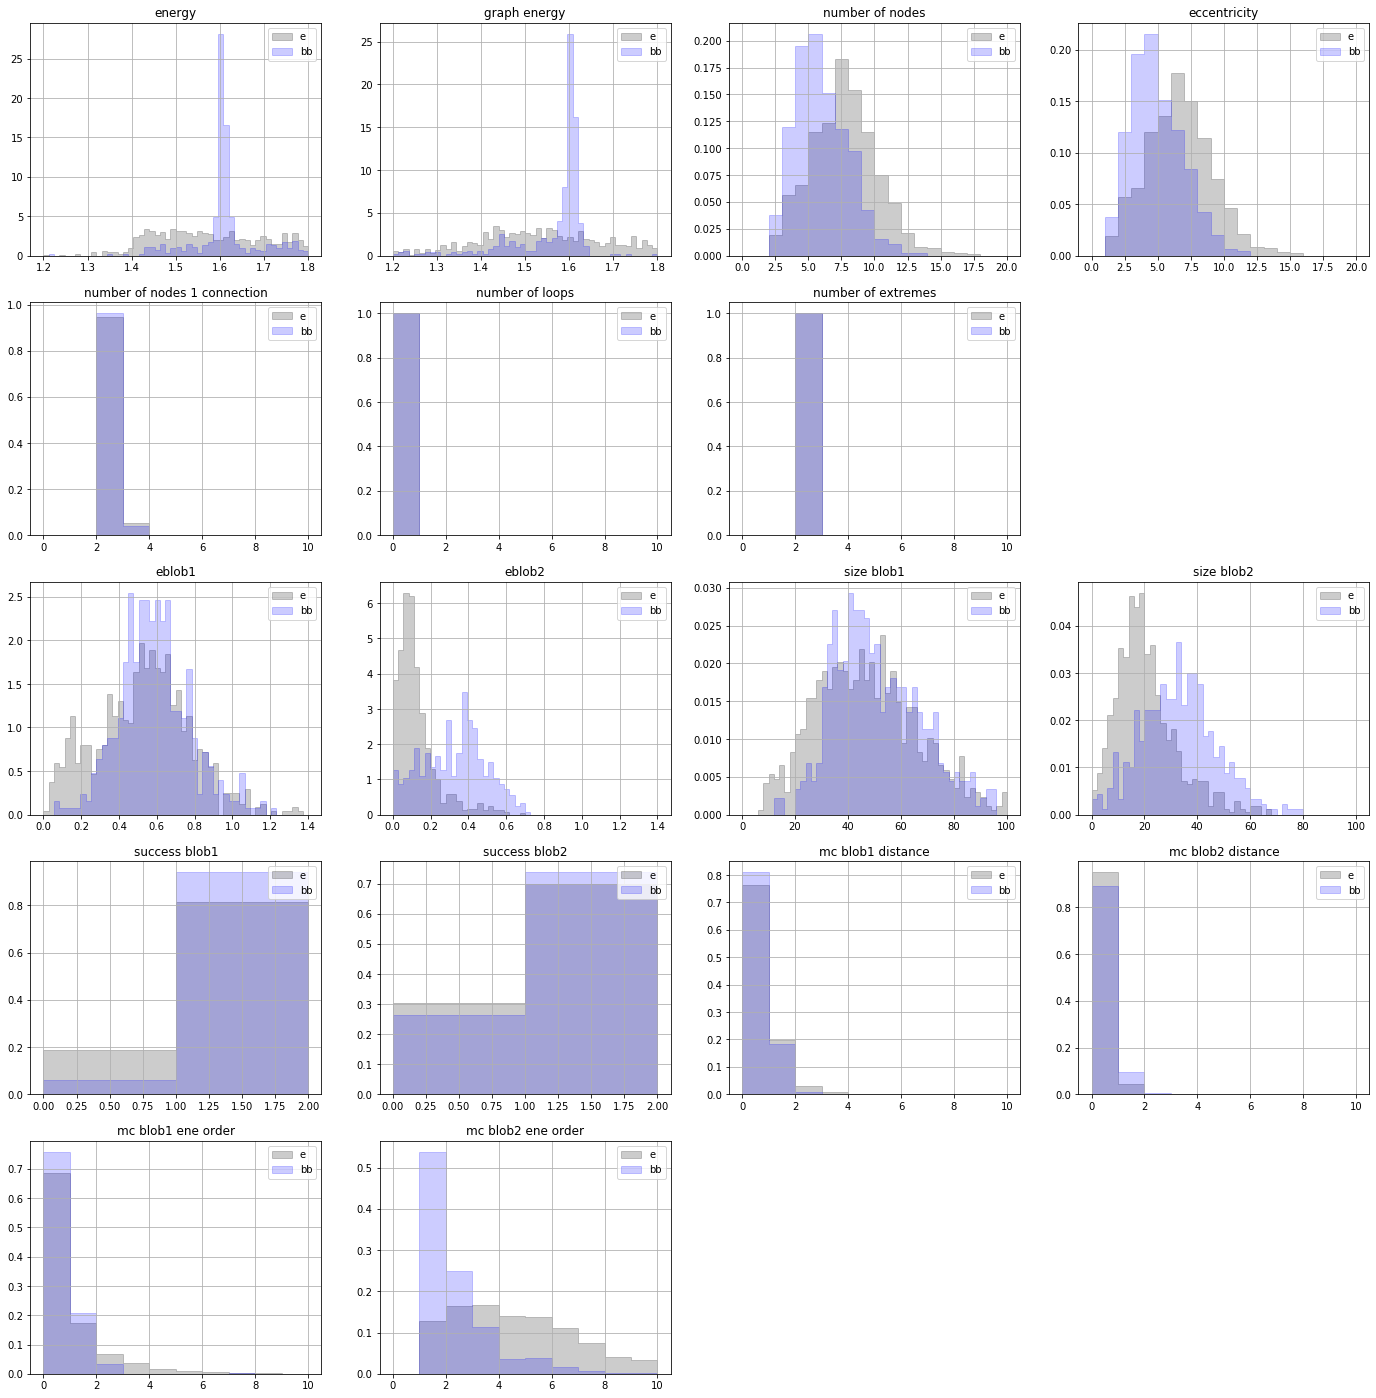

In [798]:
_plot(dd, (dd.nloops == 0) & (dd.nextr == 2))

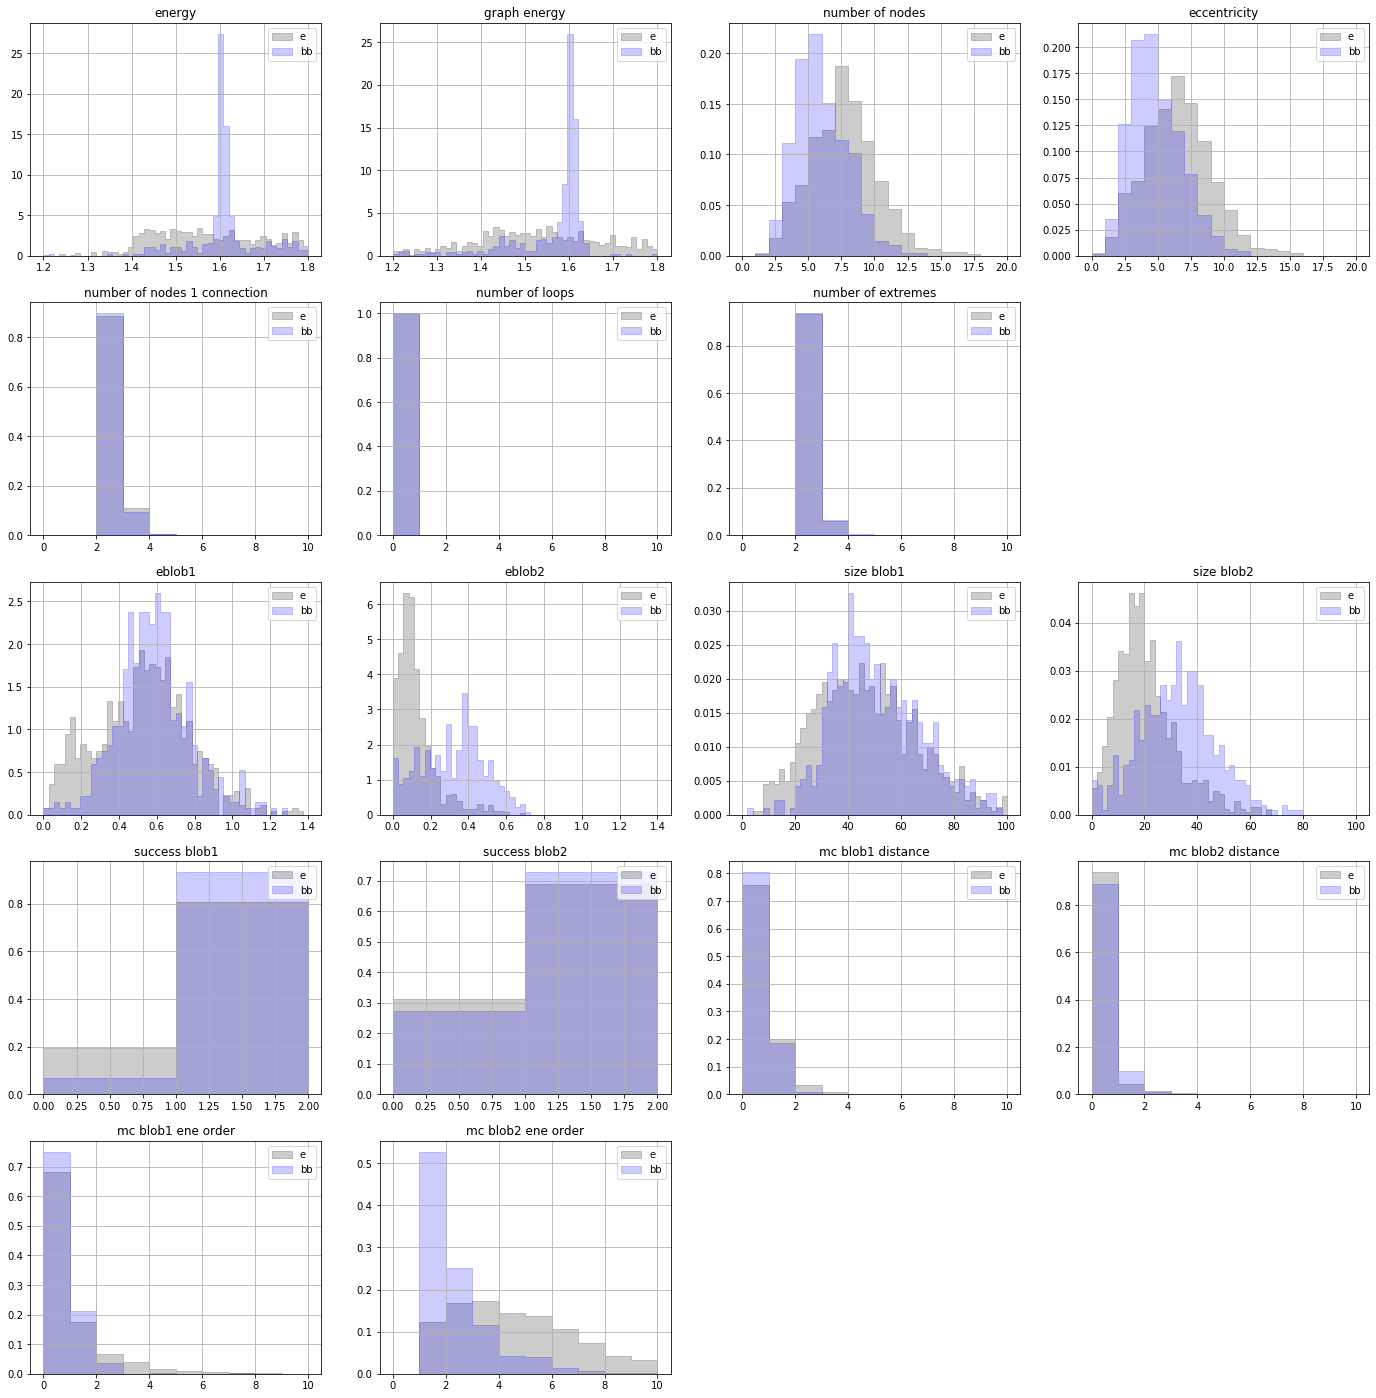

In [799]:
_plot(dd, (dd.nloops == 0))

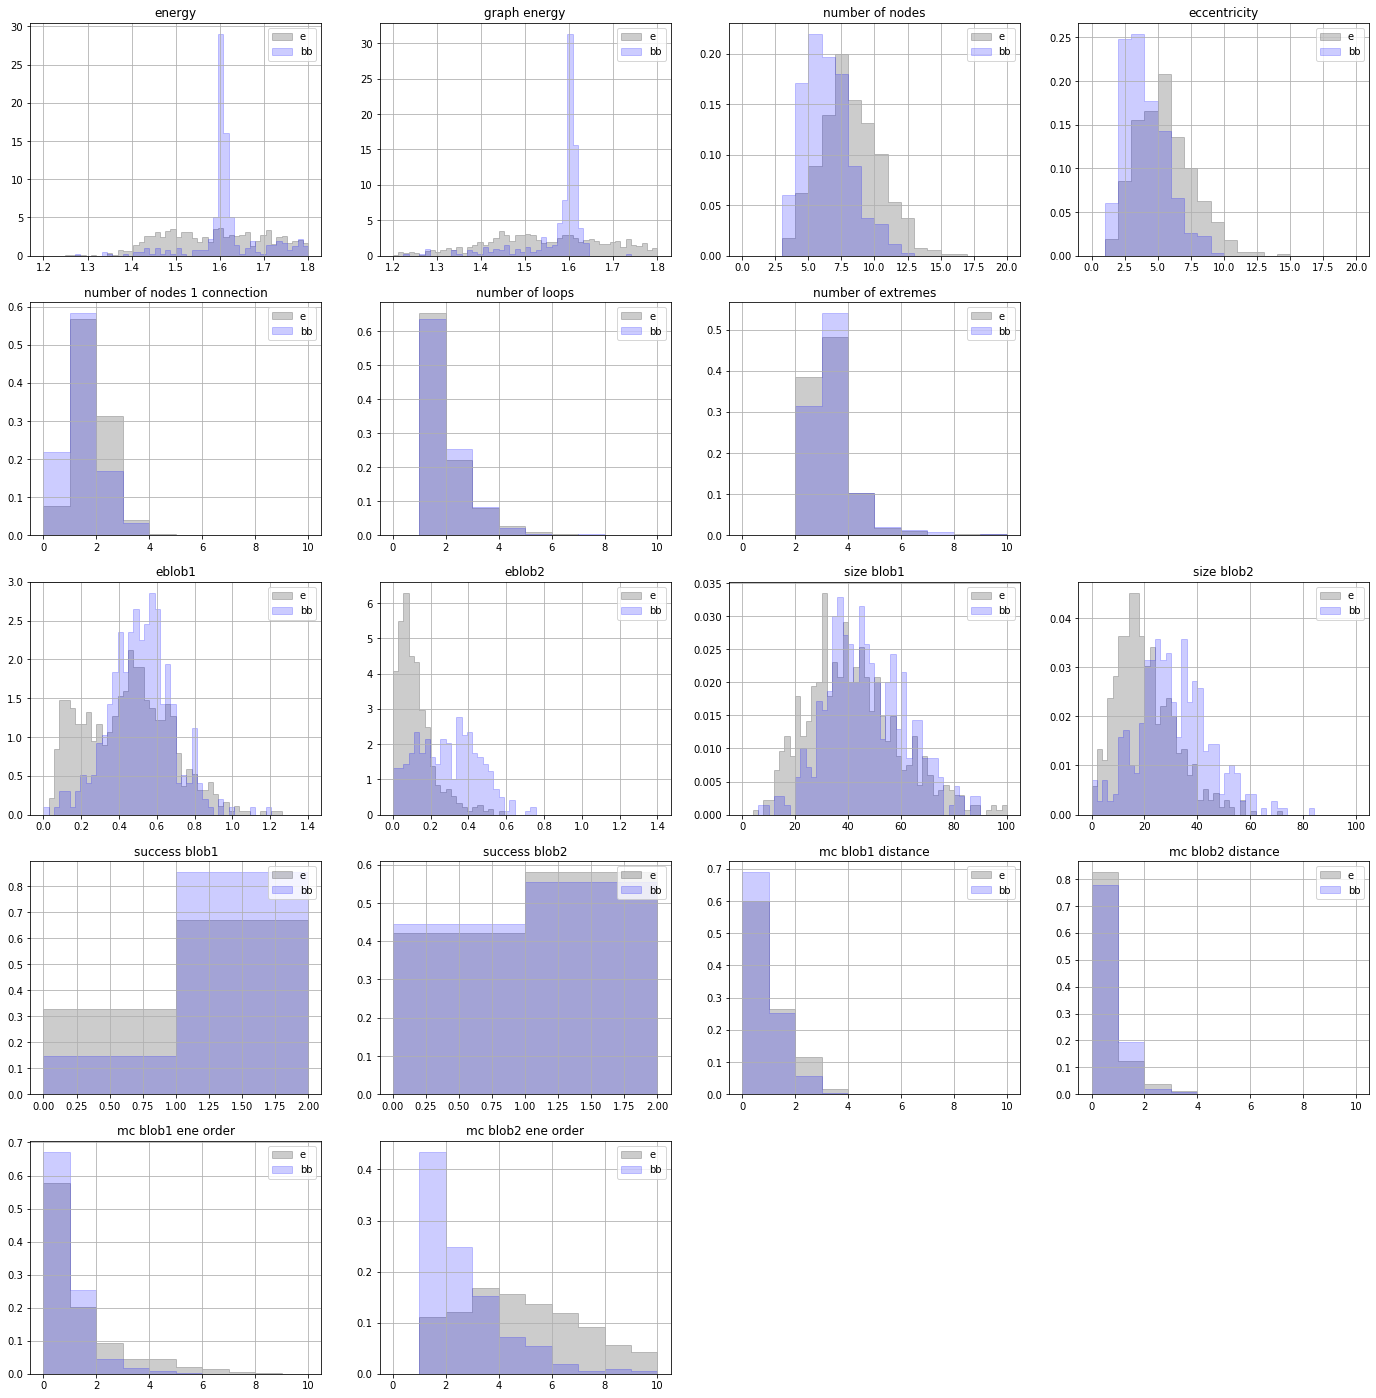

In [800]:
_plot(dd, (dd.nloops >= 1))

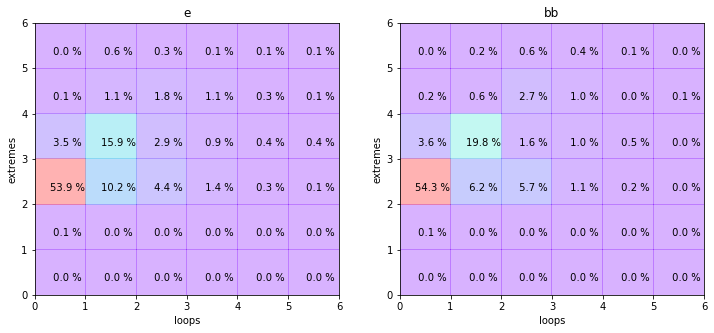

In [802]:
canvas = pltext.canvas(2, 2)
names = ['e', 'bb']
for i in (0, 1):
    canvas(i+1)
    sel = dd.dataclass == i
    h, xs, ys, im = plt.hist2d(dd.nloops[sel], dd.nextr[sel], (6, 6), ((0, 6), (0, 6)), 
                               alpha = 0.3, density = True);
    plt.xlabel('loops'); plt.ylabel('extremes'); plt.title(names[i])
    ax = plt.gca()
    for i in range(len(ys)-1):
        for j in range(len(xs)-1):
            ax.text(xs[j]+0.3, ys[i]+0.3, "{:4.1f} %".format(100*h.T[i,j]))

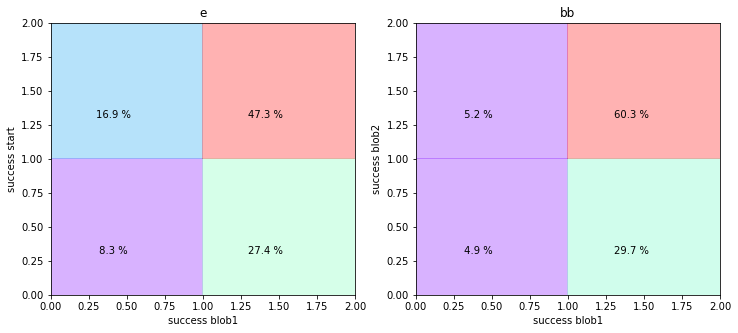

In [805]:
canvas = pltext.canvas(2, 2)
names = ['e', 'bb']
for i in range(2):
    canvas(i + 1)
    sel = (dd.dataclass == i) 
    hist2d_text(dd.success1[sel], dd.success2[sel], (2, 2), ((0, 2), (0, 2)), alpha = 0.3, density = True);
    ylabel = 'success start' if i == 0 else 'success blob2'
    plt.xlabel('success blob1'); plt.ylabel(ylabel); plt.title(names[i]);

In [806]:
ofile = 'ana_graph_categories.h5'
dd.to_hdf(ofile, '/graph_categories');

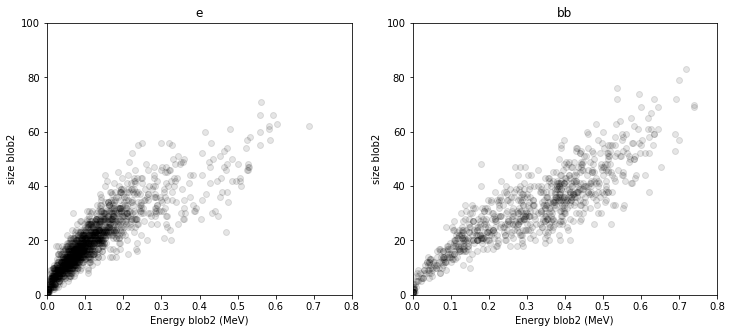

In [807]:
canvas = pltext.canvas(2, 2)
names  = ['e', 'bb']
for i in (0, 1):
    canvas(i+1)
    sel = (dd.nloops >= 0) & (dd.dataclass == i)
    plt.scatter(dd.eblob2[sel], dd.sblob2[sel], alpha = 0.1); 
    plt.ylim((0., 100)); plt.xlim(0., 0.8);
    plt.xlabel('Energy blob2 (MeV)'); plt.ylabel('size blob2')
    plt.title(names[i])

In [808]:
def roc(var1, var2, nbins, range, label = ''):
    counts1, bins = np.histogram(var1, nbins, range, density = True)
    ccounts1 = np.cumsum(counts1 * np.diff(bins))
    counts2,  _   = np.histogram(var2, nbins, range, density = True)
    ccounts2 = np.cumsum(counts2 * np.diff(bins))
    xs = 0.4 * (bins[1:] + bins[:-1])
    plt.plot(ccounts1, 1.-ccounts2, label = label)
    return counts1, counts2, xs

def hist2d_text(xs, ys, bins, ranges,
                  factor = 100, text_format = "{:4.1f} %", offset = 0.3,
                  **kargs):
    h, hxs, hys, im = plt.hist2d(xs, ys, bins, ranges, **kargs);
    ax = plt.gca()
    for i in range(len(hys)-1):
        for j in range(len(hxs)-1):
            ax.text(hxs[j] + offset, hys[i] + offset, 
                    text_format.format(factor * h.T[i,j]))
    return
    

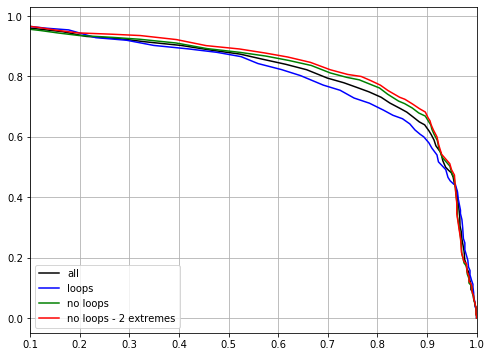

In [809]:
esel  = dd.dataclass == 0
bbsel = dd.dataclass == 1

names = ['all', 'loops', 'no loops', 'no loops - 2 extremes']
sels = ((dd.nloops >= 0), (dd.nloops > 0), (dd.nloops == 0), (dd.nloops == 0) & (dd.nextr == 2))
plt.figure(figsize = (8, 6))
for i, sel in enumerate(sels):
    var1 = dd.eblob2[sel & esel]  #/ dd.sblob2[sel & esel]
    var2 = dd.eblob2[sel & bbsel] #/ dd.sblob2[sel & bbsel]
    roc(var1, var2, 100, (0., 1.), label = names[i]);
plt.grid(which = 'both'); plt.xlim(0.1, 1.); plt.legend();

## RoC curve with ISAURA and Paulina blobs

In [810]:
eblob1_e , eblob2_e  = bc.paulina_blobs_energy(dfs, 0)
eblob1_bb, eblob2_bb = bc.paulina_blobs_energy(dfs, 1)

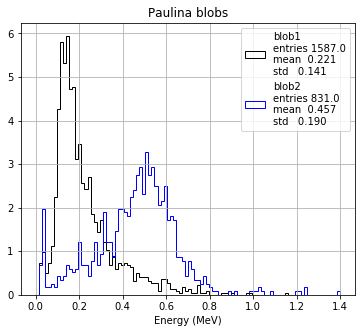

In [811]:
plt.figure(figsize = (6, 5));
pltext.hist(eblob2_e , 100, (0., 1.4), label = 'blob1', density = True);
pltext.hist(eblob2_bb, 100, (0., 1.4), label = 'blob2', density = True);
plt.xlabel('Energy (MeV)'); plt.title('Paulina blobs');

AttributeError: 'DataFrame' object has no attribute 'nloops'

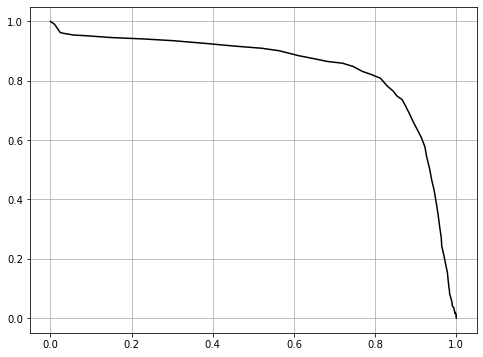

In [843]:
plt.figure(figsize = (8, 6));
roc(eblob2_e, eblob2_bb, 100, (0., 1.4), label = 'paulina-isaura');
plt.grid();
esel  = dd.dataclass == 0
bbsel = dd.dataclass == 1
sels = ((dd.nloops >= 0), (dd.nloops == 0) & (dd.nextr == 2))
labels = ['all', 'no loop & 2 extremes']
for i, sel in enumerate(sels):
    var1 = dd.eblob2[sel & esel]  #/ dd.sblob2[sel & esel]
    var2 = dd.eblob2[sel & bbsel] #/ dd.sblob2[sel & bbsel]
    roc(var1, var2, 100, (0., 1.4), label = labels[i]);
plt.legend(); plt.xlabel('rejection'); plt.ylabel('efficiency');

### Conclusions:

  * Paulina works as well as the best case of clouds
  
  * Why 0-loop, 2-extreme, fails sometimes? physics limits and rc problems
  
  * Why Paulina works so well for complicated tracks? 

## MC study of blobs energy

In [502]:
dfber = dfs['rcvoxels']
eblobs1, eblobs2 = [], []
i = 0
for evt, d in dfber.groupby('dataset_id'):
    if (np.all(d.binclass == i)): continue
    ieblob1 = np.unique([ene for ene, id in zip(d.elem_ener, d.elem) if '3_0' in id])
    ieblob2 = np.unique([ene for ene, id in zip(d.elem_ener, d.elem) if '3_1' in id])
    ieblob1 = float(ieblob1[0]) if len(ieblob1)>0 else -1.
    ieblob2 = float(ieblob2[0]) if len(ieblob2)>0 else -1.
    eblobs1.append(ieblob1)
    eblobs2.append(ieblob2)

Text(0.5, 0, 'number of blobs')

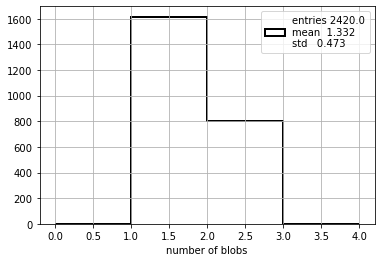

In [521]:
nblobs = [np.unique(d.nblob)[0] for evt, d in dfber.groupby('dataset_id')] 
pltext.hist(nblobs, 4, (0, 4), lw= 2);
plt.xlabel('number of blobs')

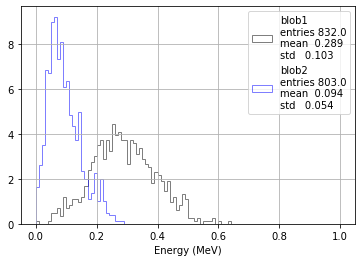

In [522]:
pltext.hist(eblobs1, 100, (0., 1.), alpha = 0.5, label = 'blob1', density = True);
pltext.hist(eblobs2, 100, (0., 1.), alpha = 0.5, label = 'blob2', density = True);
plt.xlabel('Energy (MeV)');

###  Conclusions:

 * The MC energy of the second blob is too small? (ave ~ 0.1 MeV average?)
 * The MC energy of the fist blob is also small, ~0.3 MeV average.

## Categories of MC blob node

In [619]:
dd = bc.run(filename, bc.ana_mcblob_nodes, -1)

Filename :  /Users/hernando/work/investigacion/NEXT/data/MC/NEW/ds/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut50.beersheba_label_4mm.h5
Events  : 2420
event  0
event  100
event  200
event  300
event  400
event  500
event  600
event  700
event  800
event  900
event  1000
event  1100
event  1200
event  1300
event  1400
event  1500
event  1600
event  1700
event  1800
event  1900
event  2000
event  2100
event  2200
event  2300
event  2400
processed number of events  2420
clouds failures             2


In [92]:
dd

blob  node     enode  sizenode  ingraph  inloop  connections  eneorder  \
0        1    31  0.484207        53     True   False            1         0   
1        1   162  0.682637        48     True    True            3         0   
2        1   250  0.640529        55     True   False            1         0   
3        1   141  0.733119        66     True   False            2         0   
4        1    55  0.585195        51     True   False            1         1   
...    ...   ...       ...       ...      ...     ...          ...       ...   
1269     1    63  0.482169        37     True    True            2         0   
1270     1   109  0.732384        52     True   False            1         0   
1271     1    52  0.443848        35     True    True            2         0   
1272     1    27  0.362751        35     True    True            3         0   
1273     1   126  0.791049        56     True   False            2         0   

      dataclass  event  
0             0      0  
1             0      1  
2             0      2  
3             0      3  
4             1      4  
...         ...    ...  
1269          0    995  
1270          0    996  
1271          0    997  
1272          0    998  
1273          0    999  

[1274 rows x 10 columns]

In [145]:
%matplotlib inline
def plot_ana_mcblob_nodes(dd, dataclass = 1):
    canvas = pltext.canvas(6, 2)
    names = ['blob1', 'blob2']
    indices = (1, 2) if dataclass == 1 else (1,)
    def _plot(i):
        sel  = (dd.blob == i) & (dd.dataclass == dataclass) 
        if (np.sum(sel) == 0): return
        name = names[i-1]
        canvas(1)
        pltext.hist(dd.enode[sel], 50, (0., 1.2), density = True, label = name);
        plt.xlabel('Energy (MeV)');
        canvas(2)
        pltext.hist(dd.sizenode[sel], 50, (0., 100.), density = True, label = name);
        plt.xlabel('size');
        canvas(3)
        pltext.hist(dd.connections[sel], 10, (0., 10), density = True, label = name);
        plt.xlabel('connections')
        canvas(4)
        pltext.hist(dd.ingraph[sel], 2, (0., 2), density = True, label = name);    
        plt.xlabel('in graph')
        canvas(5)
        pltext.hist(dd.inloop[sel], 2, (0., 2), density = True, label = name);
        plt.xlabel('in loop')
        canvas(6)
        pltext.hist(dd.eneorder[sel], 10, (0., 10), density = True, label = name);
        plt.xlabel('energy order')
    for i in indices: _plot(i)

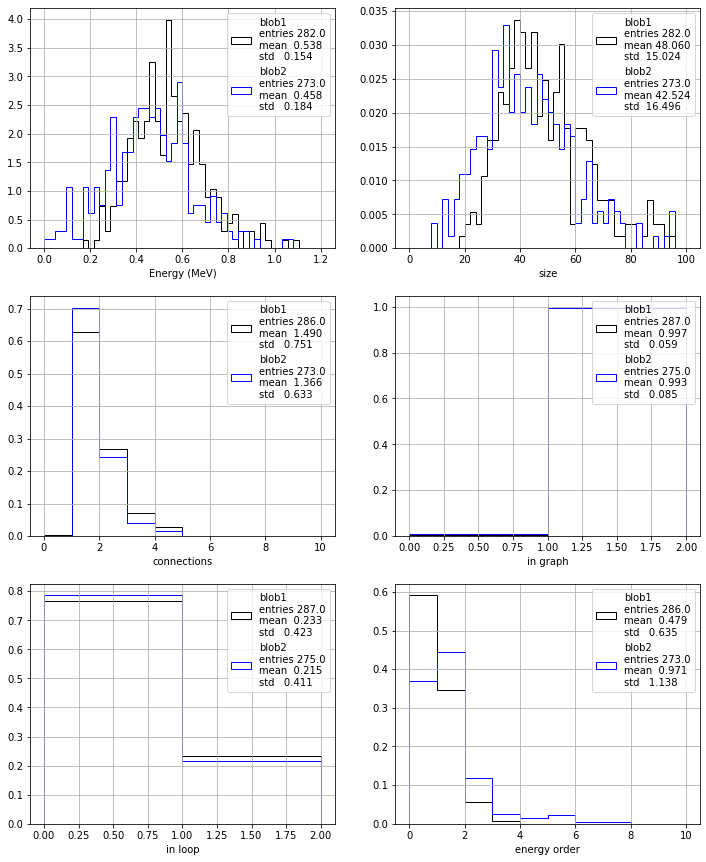

In [146]:
plot_ana_mcblob_nodes(dd)

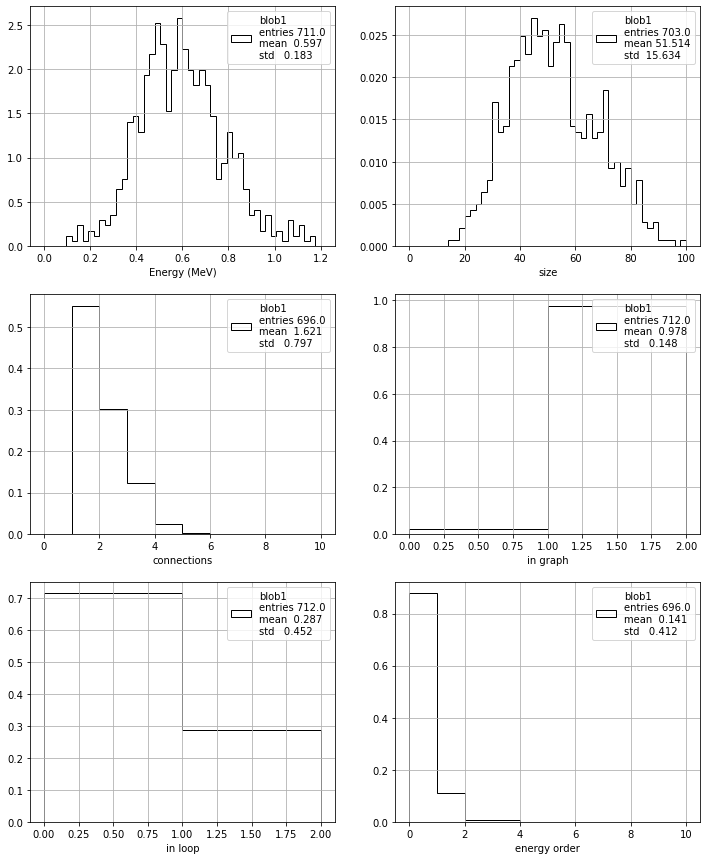

In [147]:
plot_ana_mcblob_nodes(dd, 0)

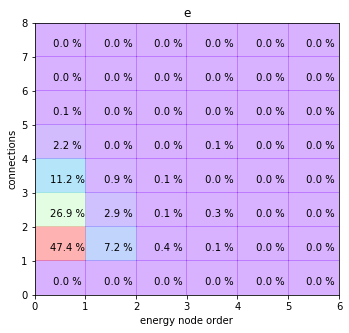

In [163]:
canvas = pltext.canvas(2, 2)
canvas(1)
sel = (dd.dataclass == 0) & (dd.blob == 1)
hist2d_text(dd.eneorder[sel], dd.connections[sel], (6, 8), ((0, 6), (0, 8)),
            alpha = 0.3, density = True)
plt.xlabel('energy node order'); plt.ylabel('connections'); plt.title('e');

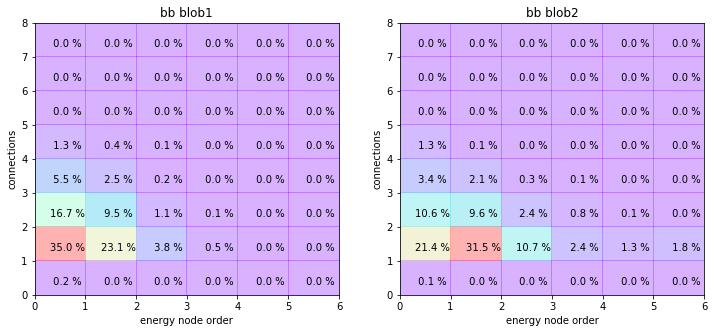

In [169]:
canvas = pltext.canvas(2, 2)
canvas(1)
sel = (dd.dataclass == 1) & (dd.blob == 1)
hist2d_text(dd.eneorder[sel], dd.connections[sel], (6, 8), ((0, 6), (0, 8)),
            alpha = 0.3, density = True)
plt.xlabel('energy node order'); plt.ylabel('connections'); plt.title('bb blob1');
canvas(2)
sel = (dd.dataclass == 1) & (dd.blob == 2)
hist2d_text(dd.eneorder[sel], dd.connections[sel], (6, 8), ((0, 6), (0, 8)),
            alpha = 0.3, density = True)
plt.xlabel('energy node order'); plt.ylabel('connections'); plt.title('bb blob2');

In [171]:
dd.columns

Index(['blob', 'node', 'enode', 'sizenode', 'ingraph', 'inloop', 'connections',
       'eneorder', 'dataclass', 'event'],
      dtype='object')

selections  803 803


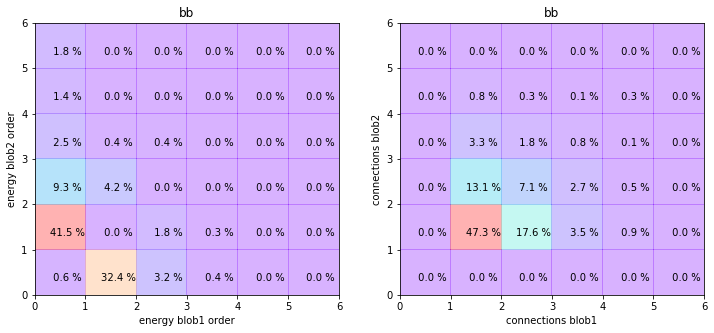

In [176]:
canvas = pltext.canvas(2, 2)
canvas(1)
sel1 = (dd.dataclass == 1) & (dd.blob == 1)
sel2 = (dd.dataclass == 1) & (dd.blob == 2)
sel1 = sel1 & np.isin(dd.event, dd[sel2].event.values)
print('selections ', np.sum(sel1), np.sum(sel2))
hist2d_text(dd.eneorder[sel1], dd.eneorder[sel2], (6, 6), ((0, 6), (0, 6)),
            alpha = 0.3, density = True)
plt.xlabel('energy blob1 order'); plt.ylabel('energy blob2 order'); plt.title('bb');
canvas(2)
hist2d_text(dd.connections[sel1], dd.connections[sel2], (6, 6), ((0, 6), (0, 6)),
            alpha = 0.3, density = True)
plt.xlabel('connections blob1'); plt.ylabel('connections blob2'); plt.title('bb');

## Ana MCblob sucess - different methods

In [971]:
clouds = bc.get_clouds_event(dfs, 21)
idd    = bc.ana_mcblob_success(clouds)

In [972]:
idd

method  node1  node2    ene1      ene2  size1  size2 success1 success2  \
0       mc     28     84  0.4661  0.299293     45     24     True     True   
1  paulina     28     84  0.4661  0.299293     45     24     True     True   
2   maxene     28     84  0.4661  0.299293     45     24     True     True   
3    graph     28     84  0.4661  0.299293     45     24     True     True   

   disgraph1  disgraph2  disene1  disene2  
0          0          0        0        1  
1          0          0        0        1  
2          0          0        0        1  
3          0          0        0        1

In [973]:
dd = bc.run(filename, bc.ana_mcblob_success, -1)

Filename :  /Users/hernando/work/investigacion/NEXT/data/MC/NEW/ds/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut50.beersheba_label_4mm.h5
Events  : 2420
event  0
event  100
event  200
event  300
event  400
event  500
event  600
event  700
event  800
event  900
event  1000
event  1100
event  1200
event  1300
event  1400
event  1500
event  1600
event  1700
event  1800
event  1900
event  2000
event  2100
event  2200
event  2300
event  2400
processed number of events  2420
clouds failures             39


In [974]:
dd

method  node1  node2      ene1      ene2  size1  size2 success1  \
0          mc    162    130  0.682637  0.100692     48     24     True   
1     paulina     24    130  0.137755  0.100692     24     24    False   
2      maxene    162    102  0.682637  0.295832     48     38     True   
3       graph    162     24  0.682637  0.137755     48     24     True   
4          mc    250     -1  0.640529  0.000000     55      0     True   
...       ...    ...    ...       ...       ...    ...    ...      ...   
9519    graph     39    189  0.537070  0.149015     44     27     True   
9520       mc     10    125  0.434246  0.100547     29     16     True   
9521  paulina     10    125  0.434246  0.100547     29     16     True   
9522   maxene     10     86  0.434246  0.352484     29     39     True   
9523    graph     10    125  0.434246  0.100547     29     16     True   

     success2  disgraph1  disgraph2  disene1  disene2  dataclass  event  
0        True          0          0        0        5          0      1  
1        True          1          0        3        5          0      1  
2       False          0          1        0        1          0      1  
3       False          0          1        0        3          0      1  
4        True          0         -1        0       -1          0      2  
...       ...        ...        ...      ...      ...        ...    ...  
9519     True          0          0        0        4          0   2418  
9520     True          0          0        0        4          0   2419  
9521     True          0          0        0        4          0   2419  
9522    False          0          5        0        1          0   2419  
9523     True          0          0        0        4          0   2419  

[9524 rows x 15 columns]

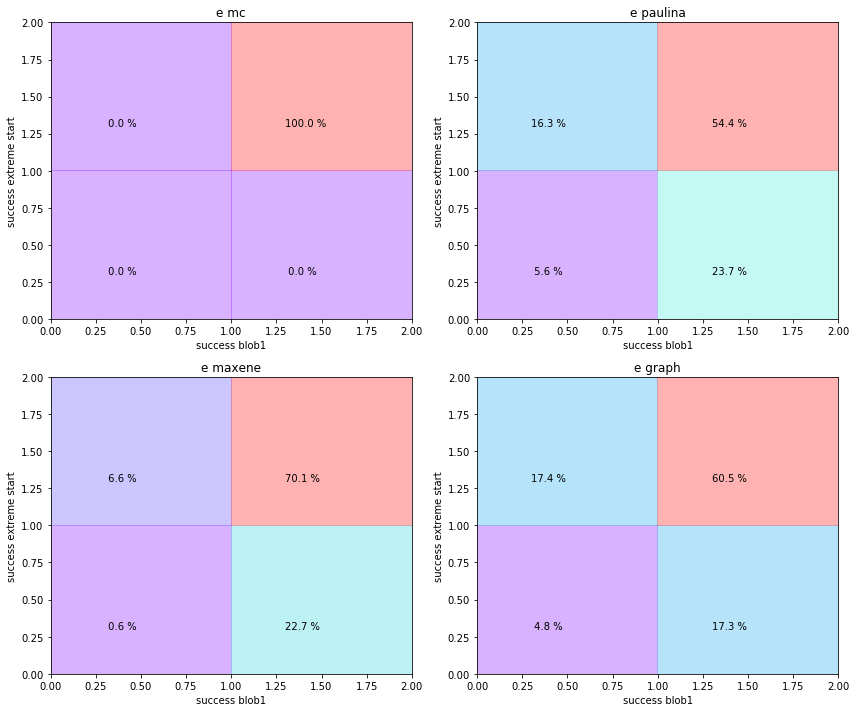

In [977]:
methods = ('mc', 'paulina', 'maxene', 'graph')
canvas  = pltext.canvas(len(methods), 2)
for i, method in enumerate(methods):
    canvas(i+1)
    sel = (dd.dataclass == 1) & (dd.method == method)
    hist2d_text(dd.success1[sel], dd.success2[sel], (2, 2), ((0, 2), (0, 2)), alpha = 0.3, density = True);
    plt.xlabel('success blob1'); plt.ylabel('success extreme start'); plt.title('e '+str(methods[i]));
plt.tight_layout();

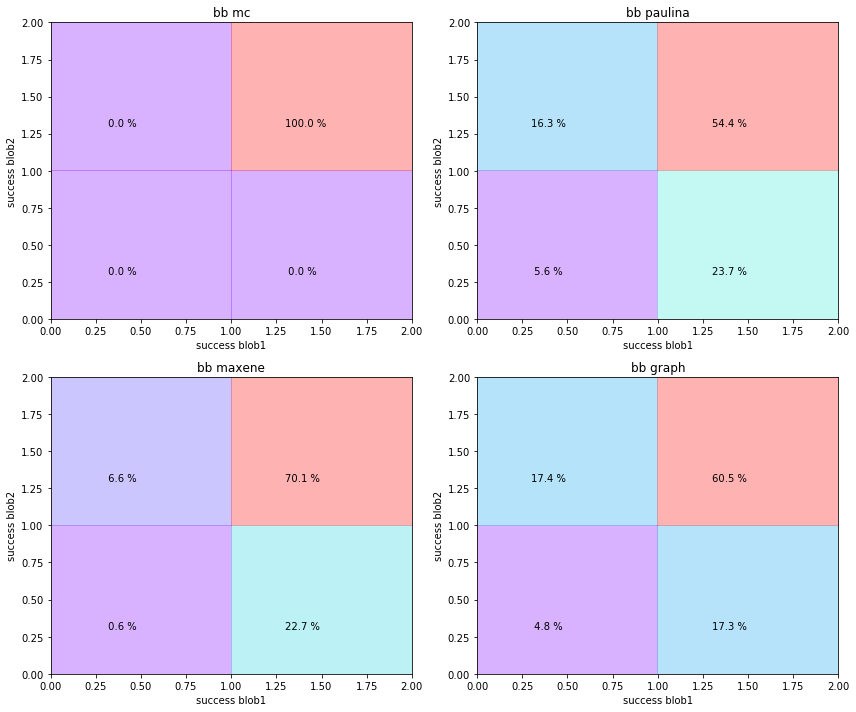

In [978]:
#methods = ('mc', 'paulina', 'maxene', 'graph')
canvas  = pltext.canvas(len(methods), 2)
for i, method in enumerate(methods):
    canvas(i+1)
    sel = (dd.dataclass == 1) & (dd.method == method)
    hist2d_text(dd.success1[sel], dd.success2[sel], (2, 2), ((0, 2), (0, 2)), alpha = 0.3, density = True);
    plt.xlabel('success blob1'); plt.ylabel('success blob2'); plt.title('bb '+str(methods[i]));
plt.tight_layout();

efficiency mc = 1.00
efficiency paulina = 0.69
efficiency maxene = 0.88
efficiency graph = 0.71


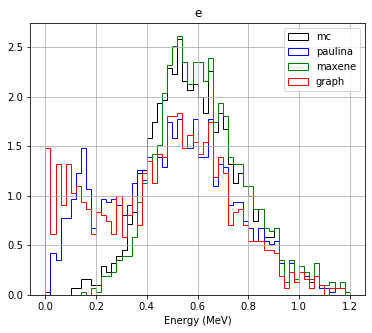

In [979]:
%matplotlib inline
dd.fillna(0);
canvas = pltext.canvas(1, 1)
sel   = dd.dataclass == 0
effs   = []
for method in methods:
    isel = sel & (dd.method == method)
    canvas(1)
    pltext.hist(dd.ene1[isel].values, 60, (0., 1.2), label = method, density = True, stats = False)
    plt.xlabel('Energy (MeV)')
    effs.append(np.sum(dd.success1[isel] == True)/(len(dd.success1[isel])))
plt.title('e'); plt.legend();
for i, key in enumerate(methods):
    print('efficiency {:s} = {:4.2f}'.format(key, effs[i]))
    

### conclusions for e-blob1

   * macene is close to mc
   
   * paulina-nodes fails in a fraction of events

efficiency blob1 mc = 1.00
efficiency blob2 mc = 1.00
efficiency blob1 paulina = 0.78
efficiency blob2 paulina = 0.71
efficiency blob1 maxene = 0.93
efficiency blob2 maxene = 0.77
efficiency blob1 graph = 0.78
efficiency blob2 graph = 0.78


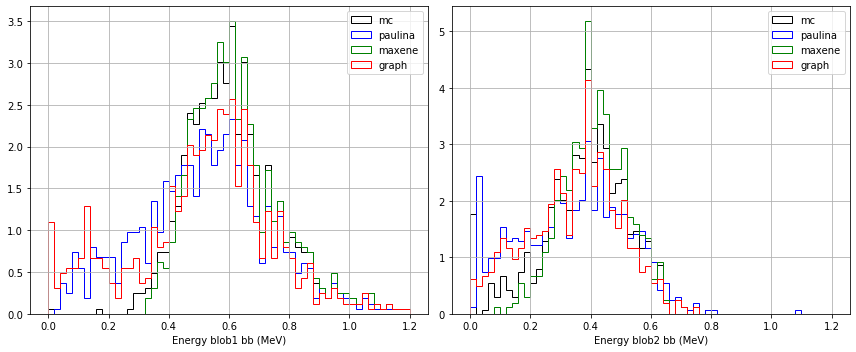

In [980]:
%matplotlib inline
dd.fillna(0);
canvas = pltext.canvas(2, 2)
sel   = dd.dataclass == 1
eff1s   = []
eff2s   = []
for method in methods:
    isel = sel & (dd.method == method)
    canvas(1)
    pltext.hist(dd.ene1[isel].values, 60, (0., 1.2), label = method, density = True, stats = False)
    plt.xlabel('Energy blob1 bb (MeV)'); plt.legend();
    eff1s.append(np.sum(dd.success1[isel] == True)/(len(dd.success1[isel])))
    canvas(2)
    pltext.hist(dd.ene2[isel].values, 60, (0., 1.2), label = method, density = True, stats = False)
    plt.xlabel('Energy blob2 bb (MeV)'); plt.legend()
    eff2s.append(np.sum(dd.success2[isel] == True)/(len(dd.success2[isel])))
plt.tight_layout();

for i, key in enumerate(methods):
    print('efficiency blob1 {:s} = {:4.2f}'.format(key, eff1s[i]))
    print('efficiency blob2 {:s} = {:4.2f}'.format(key, eff2s[i]))
    

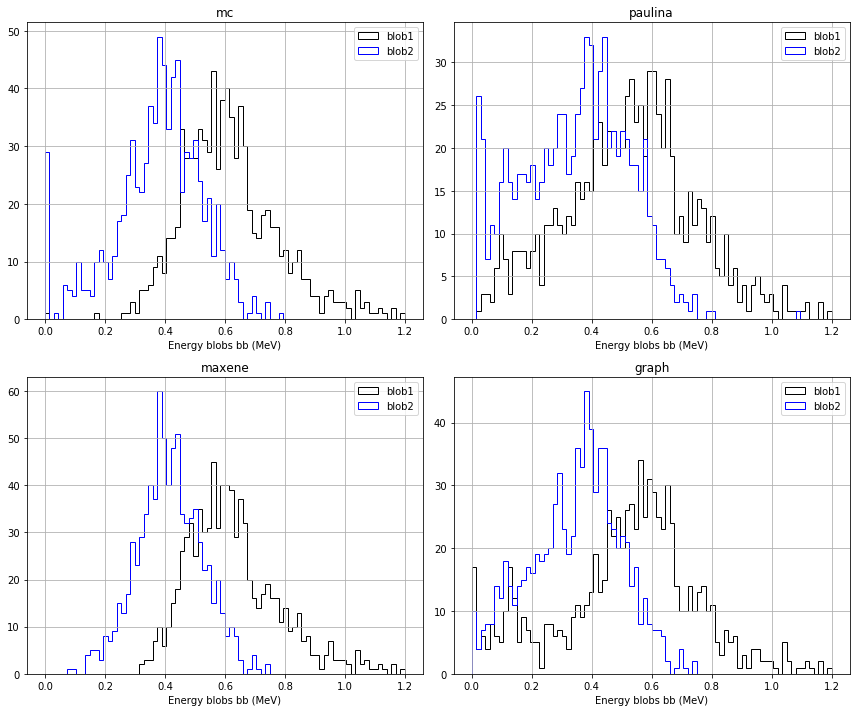

In [981]:
sel    = dd.dataclass == 1
canvas = pltext.canvas(len(methods), 2)
for i, method in enumerate(methods):
    canvas(i + 1)
    isel = sel & (dd.method == method)
    pltext.hist(dd.ene1[isel], 80, (0., 1.2), label = 'blob1', stats = False)
    pltext.hist(dd.ene2[isel], 80, (0., 1.2), label = 'blob2', stats = False)
    plt.title(method); plt.legend(); plt.xlabel('Energy blobs bb (MeV)');
plt.tight_layout();

### conclusions - blobs - bb

  * paulina-nodes if fine with blob1 but fails in blob2 for bb
  
  * enemax bias the blob energies.

In [982]:
eblob1_e,  eblob2_e  = paulina_blobs_energy(dfs, 0)
eblob1_bb, eblob2_bb = paulina_blobs_energy(dfs, 1)

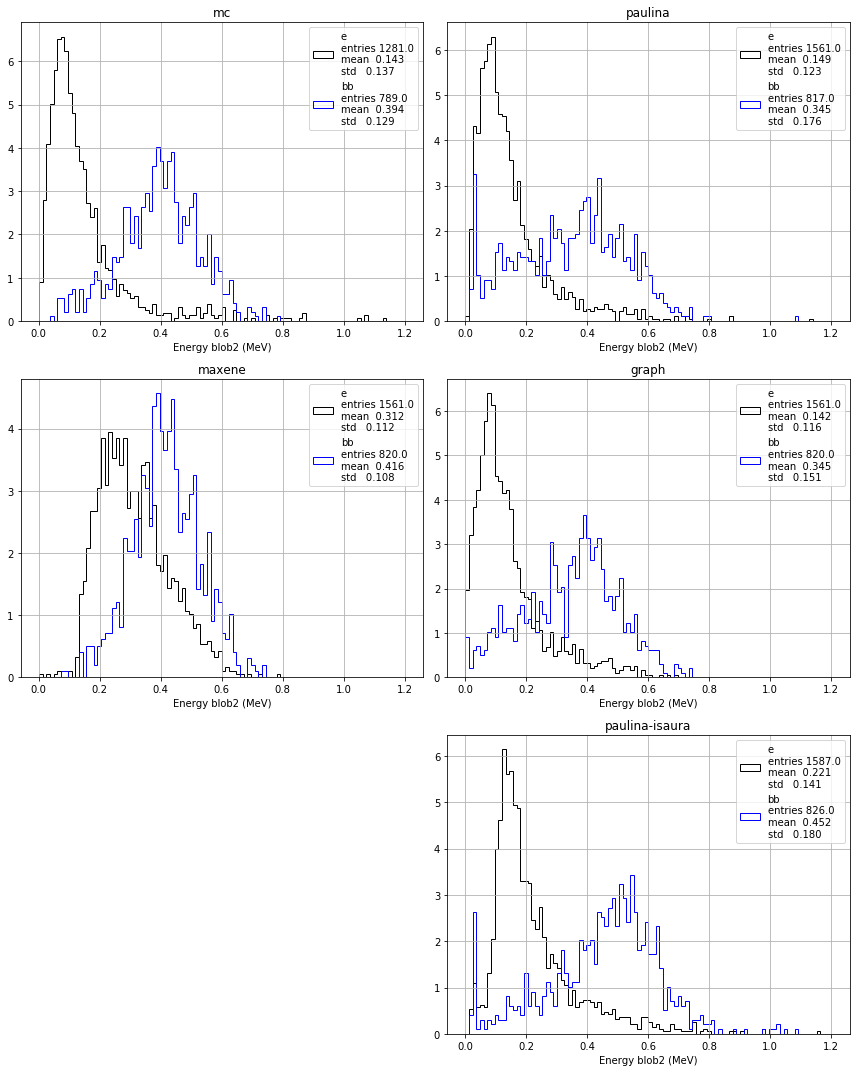

In [983]:
canvas = pltext.canvas(6, 2)
nbins, erange = 100, (0., 1.2)
sele   = dd.dataclass == 0
selbb  = dd.dataclass == 1
for i, method in enumerate(methods):
    canvas(i + 1)
    isel = dd.method == method
    var1 = dd.ene2[isel & sele].values
    var2 = dd.ene2[isel & selbb].values
    pltext.hist(var1[var1 > 0], nbins, erange, label = 'e' , stats = True, density = True)
    pltext.hist(var2[var2 > 0], nbins, erange, label = 'bb', stats = True, density = True)
    plt.title(method); plt.legend(); plt.xlabel('Energy blob2 (MeV)');
canvas(6)
pltext.hist(eblob2_e , nbins, erange, label = 'e' , stats = True, density = True)
pltext.hist(eblob2_bb, nbins, erange, label = 'bb', stats = True, density = True)
plt.title('paulina-isaura'); plt.legend(); plt.xlabel('Energy blob2 (MeV)');
plt.tight_layout();

### Conclusions - RoC

  * paulina-isuara is best tha mc-nodes. The large radious increases the success rate for blob2 and better rejection.
  
  * either paulina, maxene are far from mc!
  
  * how to reach the MC curve? Can be this be improved using a better blob-region definition?

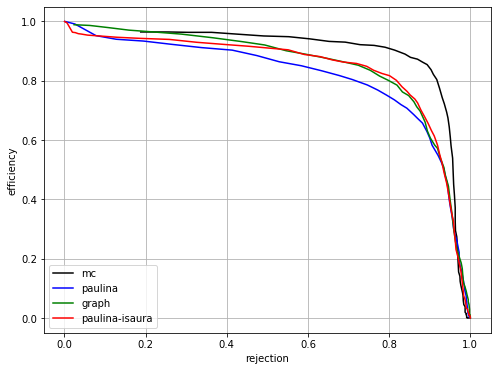

In [985]:
plt.figure(figsize = (8, 6))
sele  = dd.dataclass == 0
selbb = dd.dataclass == 1
for method in ('mc', 'paulina', 'graph'):
    isel = dd.method == method
    var1 = dd.ene2[isel & sele].values
    var2 = dd.ene2[isel & selbb].values
    roc(var1, var2, nbins, erange, label = method)
roc(eblob2_e, eblob2_bb, nbins, erange, label = 'paulina-isaura')
plt.legend();
plt.grid(which = 'both'); plt.xlabel('rejection'); plt.ylabel('efficiency');

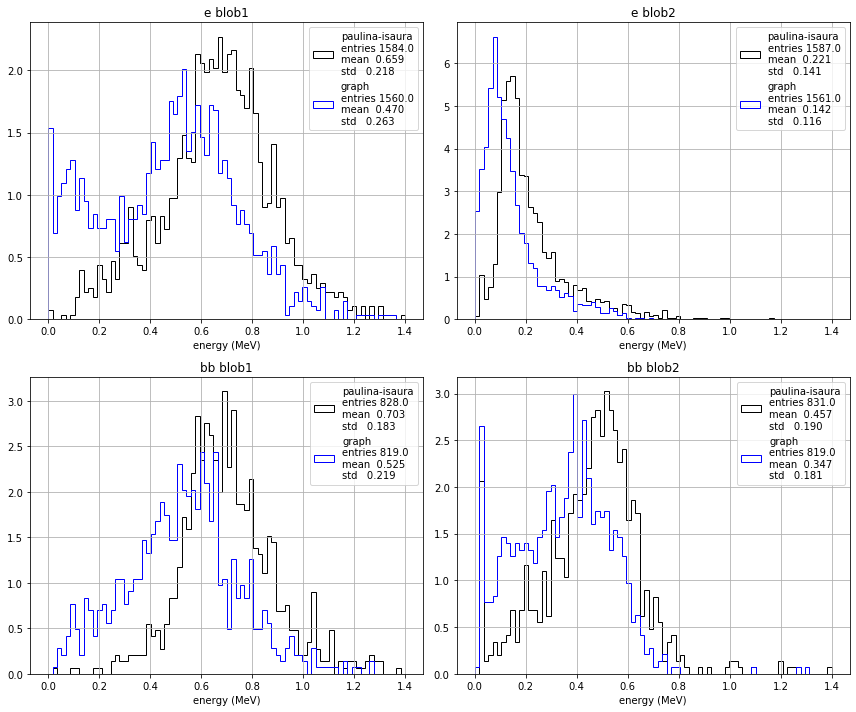

In [986]:
nbins = 80
method = 'graph'
erange = (0., 1.4)
canvas = pltext.canvas(4, 2)
sel = (dd.dataclass == 0) & (dd.method == method)
canvas(1)
pltext.hist(eblob1_e, nbins, erange, label = 'paulina-isaura', density = True);
pltext.hist(dd.ene1[sel], nbins, erange, label = method, density = True);
plt.xlabel('energy (MeV)'); plt.title('e blob1');
canvas(2)
pltext.hist(eblob2_e, nbins, erange, label = 'paulina-isaura', density = True);
pltext.hist(dd.ene2[sel], nbins, erange, label = method, density = True);
plt.xlabel('energy (MeV)'); plt.title('e blob2');
sel = (dd.dataclass == 1) & (dd.method == 'paulina')
canvas(3)
pltext.hist(eblob1_bb, nbins, erange, label = 'paulina-isaura', density = True);
pltext.hist(dd.ene1[sel], nbins, erange, label = method, density = True);
plt.xlabel('energy (MeV)'); plt.title('bb blob1');
canvas(4)
pltext.hist(eblob2_bb, nbins, erange, label = 'paulina-isaura', density = True);
pltext.hist(dd.ene2[sel], nbins, erange, label = method, density = True);
plt.xlabel('energy (MeV)'); plt.title('bb blob2');
plt.tight_layout()

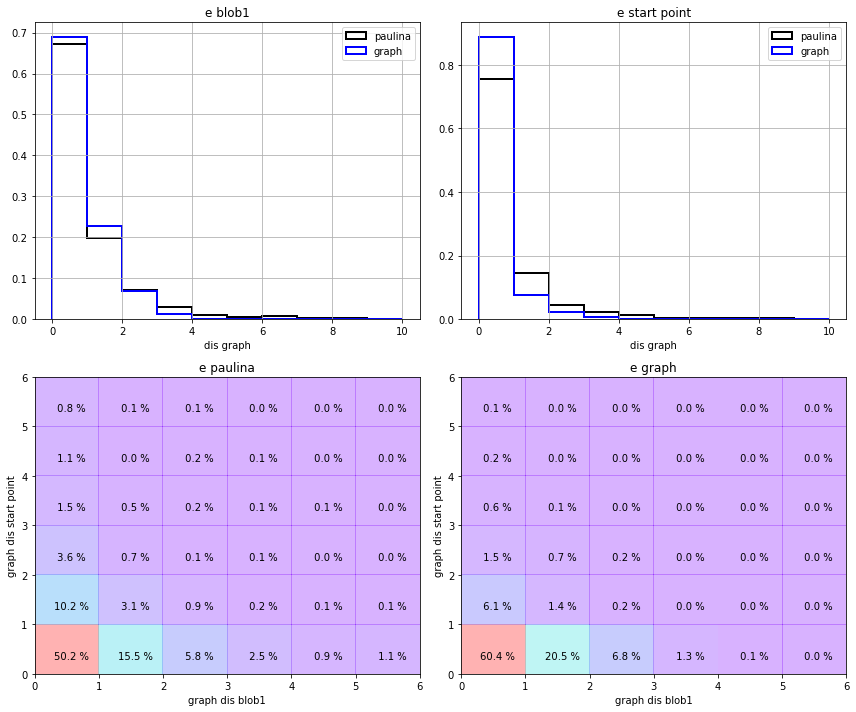

In [993]:
methods = ('paulina', 'graph')
canvas  = pltext.canvas(len(methods)+2, 2)
esel    = dd.dataclass == 0
for method in methods:
    isel = dd.method == method
    canvas(1)
    pltext.hist(dd.disgraph1[esel  & isel], 10, (0, 10), label = method, lw = 2, stats = False, density = True)
    plt.xlabel('dis graph'); plt.title('e blob1'); plt.legend();
    canvas(2)
    pltext.hist(dd.disgraph2[esel  & isel], 10, (0, 10), label = method, lw = 2, stats = False, density = True)
    plt.xlabel('dis graph'); plt.title('e start point'); plt.legend();
for i, method in enumerate(methods):
    canvas(3 + i)
    sel = (dd.dataclass == 0) & (dd.method == method)
    hist2d_text(dd.disgraph1[sel], dd.disgraph2[sel], (6, 6), ((0, 6), (0, 6)), alpha = 0.3, density = True);
    plt.xlabel('graph dis blob1'); plt.ylabel('graph dis start point'); plt.title('e '+str(methods[i]));
plt.tight_layout();

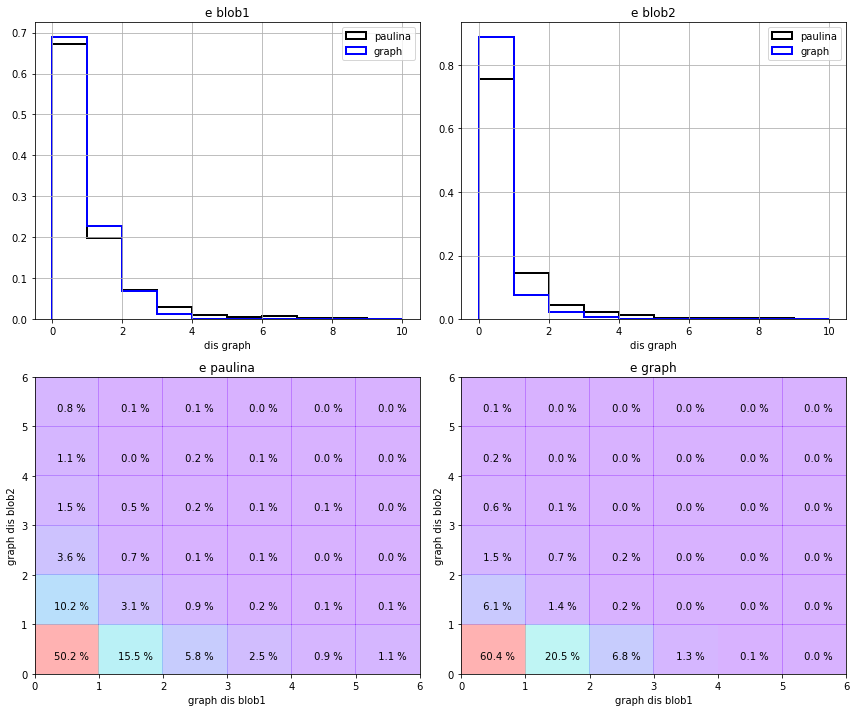

In [994]:
methods = ('paulina', 'graph')
canvas  = pltext.canvas(len(methods) + 2, 2)
bbsel    = dd.dataclass == 0
for method in methods:
    isel = dd.method == method
    canvas(1)
    pltext.hist(dd.disgraph1[bbsel  & isel], 10, (0, 10), label = method, lw = 2, stats = False, density = True)
    plt.xlabel('dis graph'); plt.title('e blob1'); plt.legend();
    canvas(2)
    pltext.hist(dd.disgraph2[bbsel  & isel], 10, (0, 10), label = method, lw = 2, stats = False, density = True)
    plt.xlabel('dis graph'); plt.title('e blob2'); plt.legend();
for i, method in enumerate(methods):
    canvas(3 + i)
    sel = bbsel & (dd.method == method)
    hist2d_text(dd.disgraph1[sel], dd.disgraph2[sel], (6, 6), ((0, 6), (0, 6)), alpha = 0.3, density = True);
    plt.xlabel('graph dis blob1'); plt.ylabel('graph dis blob2'); plt.title('e '+str(methods[i]));
plt.tight_layout();

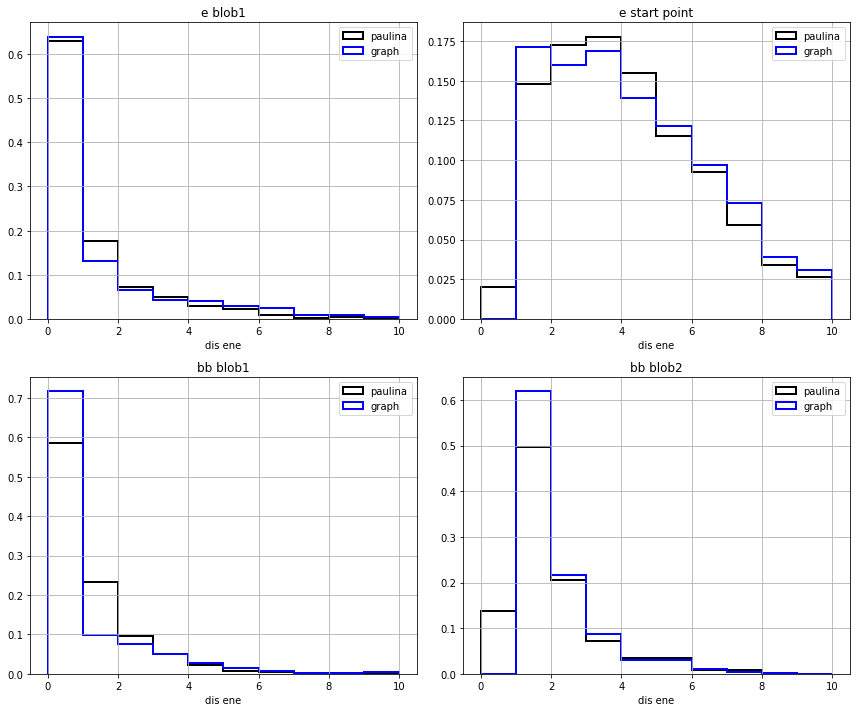

In [995]:
cavas = pltext.canvas(4, 2)
esel  = dd.dataclass == 0
bbsel = dd.dataclass == 1
for method in methods:
    isel = dd.method == method
    canvas(1)
    pltext.hist(dd.disene1[esel  & isel], 10, (0, 10), label = method, stats = False, lw = 2, density = True)
    plt.xlabel('dis ene'); plt.title('e blob1'); plt.legend();
    canvas(2)
    pltext.hist(dd.disene2[esel  & isel], 10, (0, 10), label = method, stats = False, lw = 2, density = True)
    plt.xlabel('dis ene'); plt.title('e start point'); plt.legend();
    canvas(3)
    pltext.hist(dd.disene1[bbsel & isel], 10, (0, 10), label = method, stats = False, lw = 2, density = True)
    plt.xlabel('dis ene'); plt.title('bb blob1'); plt.legend();
    canvas(4)
    pltext.hist(dd.disene2[bbsel & isel], 10, (0, 10), label = method, stats = False, lw = 2, density = True)
    plt.xlabel('dis ene'); plt.title('bb blob2'); plt.legend();
plt.tight_layout();

### Conclusions - blob1, blob2 for e/bb paulina-nodes and paulina-isaura

  * The largest radious increases the success rate and the rejection factor.

## Revisiting Graphs

In [635]:
# good 15, 21 bb
# interesting 10
evt = evts[15]
print('Event ', evt)
evoxels, ehits, etracks, eblobs = bc.get_event(dfs, evt)
bins, mask, cells, clouds = bc.get_clouds(evoxels, x0, voxel_size)
clouds                    = bc.extend_clouds_label(clouds, evoxels) 
clouds                    = bc.extend_clouds_isaura(clouds, eblobs, bins, mask)
#dfnodes = bc.ana_nodes(cloud)
#dfnodes

Event  15


<IPython.core.display.Javascript object>


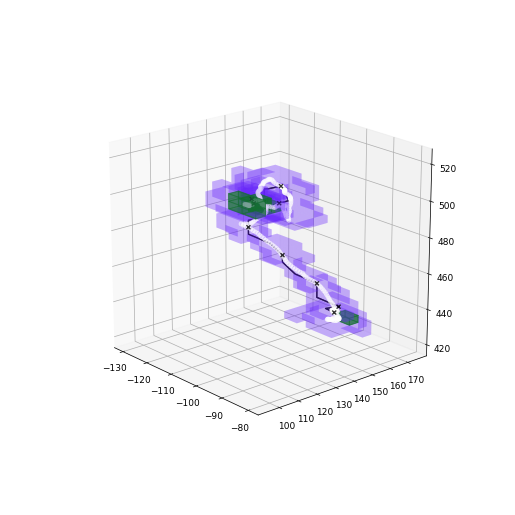

In [636]:
%matplotlib notebook
cells_select = cl.cells_select
plt.figure(figsize = (8, 8));

hits = [ehits[name].values for name in ['x', 'y', 'z']]
#print(hits)

pltclouds.draw_cloud(cells, bins, clouds);
ax = plt.gca()
ax.scatter(*hits, c = 'white', alpha = 0.5);
bsel = clouds.segclass == 3
pltclouds.voxels(cells_select(cells, bsel), bins, alpha = 0.5, color = 'green' , label = 'true');

graphs [[205, 188, 101, 27, 11, 60, 113, 161, 123]]
graph [205, 188, 101, 27, 11, 60, 113, 161, 123]
graph links  [(205, 188), (188, 101), (27, 101), (11, 27), (11, 60), (60, 113), (113, 161), (123, 161)]
graph energy  1.4647174164191332
[0.34354179 0.18897501 0.27389556 0.02324193 0.13328959 0.09411669
 0.05107315 0.05478246 0.30180124] 1.4647174164191332


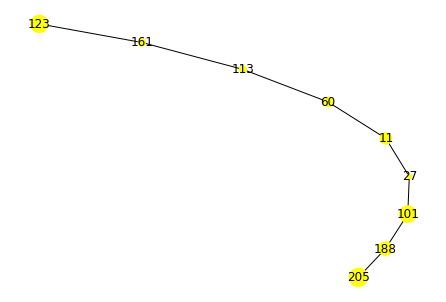

In [637]:
nodes, nlinks, graphs, glinks, idgraph = bc.get_graphs(clouds, 'eisborder')
egraph, graph, glink                   = bc.graph_most_energetic(graphs, glinks, clouds)
enes = np.array([bc.node_energy(node, clouds) for node in graph])
print('graphs', graphs)
print('graph', graph)
print('graph links ', glink)
print('graph energy ', egraph)
print(enes, np.sum(enes))
%matplotlib inline
bc.plot_graph(graph, glink, enes)

In [654]:
pair, _, _  = bc.graph_extremes(graph, glink, enes)
print(pair)

(205, 123)


In [657]:
mc_nodes = [bc.find_mcblob_node(clouds, i)[0] for i in range(2)]
print(mc_nodes)

[123, 205]


In [661]:
bc.graph_shortest_distance(graph, glink, pair, [1, 61])

[-1, -1]

In [665]:
di = bc.ana_graph_categories(clouds)

In [666]:
di

ngraphs                       1
energy       1.4647174164191332
nnodes                        9
nconn1                        2
nloops                        0
nextr                         2
ecc                           8
egraph0      1.4647174164191332
eblob1      0.34354179380495875
eblob2      0.30180124164448396
sblob1                       42
sblob2                       30
success1                   True
success2                   True
mcdistb1                      0
mcdistb2                      0
dtype: object

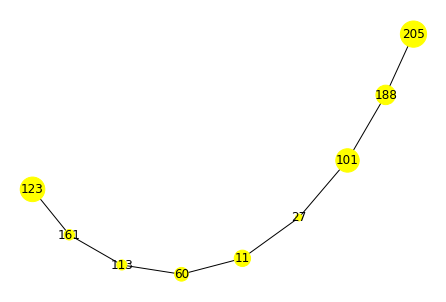

In [667]:
g = nx.Graph()
g.add_nodes_from(graph)
g.add_edges_from(glink)
nx.draw(g, with_labels = True, node_size = 2e3*enes, node_color = 'yellow')

In [576]:
idd = bc.ana_graph_categories(clouds)

In [577]:
idd

ngraphs                       1
energy       1.4647174164191332
nnodes                        9
nconn1                        2
nloops                        0
nextr                         2
ecc                           8
egraph0      1.4647174164191332
eblob1      0.34354179380495875
eblob2      0.30180124164448396
sblob1                       42
sblob2                       30
success1                   True
success2                   True
dtype: object

In [540]:
ecc = nx.eccentricity(g)
d = nx.diameter(g)
print(d)
extr = [key for key in ecc.keys() if ecc[key] == d]
print(extr)
nextr = len(extr)

5
[39, 223]


In [475]:
sortest_paths = dict(nx.all_pairs_shortest_path_length(g))
paths = [(extr[i], extr[j]) 
                 for i in range(nextr) for j in range(i + 1, nextr) if sortest_paths[extr[i]][extr[j]] == d]
print(paths)

[(205, 123)]


In [316]:
t = bc.graph_mst(graph, glink)

In [433]:
nodes, nlinks, graphs, graph_links, idcloud = bc.get_cloudid(clouds)
print('nodes   ', nodes)
print('nlinks  ', nlinks)
print('number of graphs ', len(graphs))
print('graphs  ', graphs)
print('graphs_links', graph_links)
#print('idcloud ', idcloud)

AttributeError: module 'nana.bclouds.bclouds' has no attribute 'get_cloudid'

In [659]:
connections = [bc.graph_connections(graph, glinks) for graph, glinks in zip(graphs, graph_links)]
print('connections ', connections)
print('graphs      ', graphs)
loops       = [bc.graph_loops(graph, glinks) for graph, glinks in zip(graphs, graph_links)]
print('loops       ', loops)

connections  [[1, 2, 2, 2, 2, 2, 2, 2, 1], [0], [0], [0]]
graphs       [[188, 122, 74, 64, 66, 115, 142, 196, 226], [30], [9], [34]]
loops        [0, 0, 0, 0]


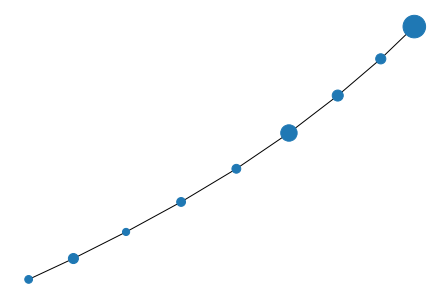

In [660]:
%matplotlib inline
enes = np.array([np.sum(clouds.energy[clouds.enode == node]) for node in graphs[0]])
size = np.array([np.sum(clouds.enode == node) for node in graphs[0]])
bc.graph_draw(graphs[0], graph_links[0], enes)

In [26]:
links  = cl.get_links(clouds.eispass.values, clouds.elink.values)
print(links)

[(array([10]), array([40])), (array([27]), array([50])), (array([34]), array([42])), (array([40]), array([10])), (array([42]), array([34])), (array([50]), array([27])), (array([59]), array([77])), (array([77]), array([59])), (array([111]), array([112])), (array([112]), array([111])), (array([117]), array([161])), (array([145]), array([191])), (array([161]), array([117])), (array([181]), array([184])), (array([184]), array([181])), (array([191]), array([145]))]


In [417]:
links  = clouds.get_links(cloud.eispass.values, cloud.elink.values)

In [418]:
nodes  = cloud.kid[cloud.eisnode == True].values
print(nodes)
cpass  = cloud.kid[cloud.eispass == True].values
print(cpass)
_anodes = [cloud.enode[kid] for kid in cpass]
print(_anodes)
_bnodes = [cloud.enode[cloud.elink[kid]] for kid in cpass]
links = list(zip(_anodes, _bnodes))
print(links)

[ 11  27  60 101 113 123 161 188 205]
[ 10  27  34  40  42  50  59  77 111 112 117 145 161 181 184 191]
[11, 27, 27, 60, 11, 101, 60, 113, 161, 113, 123, 101, 161, 205, 188, 188]
[(11, 60), (27, 101), (27, 11), (60, 11), (11, 27), (101, 27), (60, 113), (113, 60), (161, 113), (113, 161), (123, 161), (101, 188), (161, 123), (205, 188), (188, 205), (188, 101)]


In [419]:
import scipy.sparse.csgraph as gr
import networkx as nx

In [420]:
hits = [ehits[name].values for name in ['x', 'y', 'z']]
#print(hits[2])

In [456]:
def _nodes(cloud):

    nodes  = cloud.kid[cloud.eisnode == True].values
    print('nodes  ', nodes)
    xpos   = [np.array([cloud[name][kid] for kid in nodes]) for name in ('x0', 'x1', 'x2')]
    print('positions', xpos)
    nene   = [cloud.energy[node] for node in nodes] 
    enes   = [np.sum(cloud.energy[cloud.enode == node].values) for node in nodes]
    print('ene nodes ', enes)
    
    sizes  = [np.sum(cloud.enode == node) for node in nodes]
    
    #df = {}
    #df['kid'] = node
    #df['enecell'] = nene
    #df['enenode'] = enes
    #df['size']    = sizes
    #for i in range(2):
    #    df['x'+str(i)] = xpos[i]
    
    return np.array(nodes), np.array(nene), np.array(enes), np.array(sizes), xpos

def _edges(cloud):
    
    cpass    = cloud.kid[cloud.eispass == True].values
    print('passes ', cpass)
    clinks   = [(kid, cloud.elink[kid]) for kid in cpass]
    enelinks = [cloud.energy[kid] + cloud.energy[kid1] for kid, kid1 , in clinks]
    enelinks = np.array(enelinks)/np.max(enelinks)
    nlinks   = [(cloud.enode[kid], cloud.enode[kid1])  for kid, kid1 in clinks]
    #enelinks = np.array([cloud.energy[kid] + cloud.energy[cloud.elink[kid]] for kid in cpass])
    #enelinks = enelinks/np.max(enelinks)
    print('ene passes ', enelinks)
    print('clinks ', clinks)
    print('nlinks ', nlinks)

    return nlinks, clinks, enelinks
    

def nx_graph(cloud):
    
    nodes, nene, enodes, nsize, xpos = _nodes(cloud)
    nlinks, clinks, elinks           = _edges(cloud)
    
    G = nx.Graph()
    G.add_nodes_from(nodes , weights = enodes)
    G.add_edges_from(nlinks, weights = elinks)
    return G

In [457]:
nodes, nene, enes, sizes, xpos = _nodes(cloud)
nlinks, clinks, elinks         = _edges(cloud)
g = nx_graph(cloud)

nodes   [ 11  27  60 101 113 123 161 188 205]
positions [array([-122.5, -117.5, -112.5, -102.5, -102.5, -102.5,  -97.5,  -92.5,
        -87.5]), array([147.5, 142.5, 152.5, 137.5, 157.5, 167.5, 162.5, 122.5, 102.5]), array([471., 491., 459., 507., 447., 427., 435., 507., 515.])]
ene nodes  [0.133289586378913, 0.023241926863416175, 0.09411668903210427, 0.27389556207835675, 0.051073150444830503, 0.30180124164448396, 0.054782457670893084, 0.18897500850117682, 0.34354179380495875]
passes  [ 10  27  34  40  42  50  59  77 111 112 117 145 161 181 184 191]
ene passes  [0.53194666 0.19124845 0.17875826 0.53194666 0.17875826 0.19124845
 0.29401072 0.29401072 0.37922126 0.37922126 0.70511083 1.
 0.70511083 0.70861254 0.70861254 1.        ]
clinks  [(10, 40), (27, 50), (34, 42), (40, 10), (42, 34), (50, 27), (59, 77), (77, 59), (111, 112), (112, 111), (117, 161), (145, 191), (161, 117), (181, 184), (184, 181), (191, 145)]
nlinks  [(11, 60), (27, 101), (27, 11), (60, 11), (11, 27), (101, 27), (60,

In [460]:
print(g.nodes)
print(g.edges)

[11, 27, 60, 101, 113, 123, 161, 188, 205]
[(11, 60), (11, 27), (27, 101), (60, 113), (101, 188), (113, 161), (123, 161), (188, 205)]


In [458]:
nx.draw(g, with_labels = True, node_size = 5e3 * enes, node_color = 'orange',
        edge_color = 'red', width = 5.* elinks);

TypeError: text() missing 1 required positional argument: 's'

In [425]:
G, enes, enelinks, xpos = nx_graph(cloud)

nodes   [ 11  27  60 101 113 123 161 188 205]
passes  [ 10  27  34  40  42  50  59  77 111 112 117 145 161 181 184 191]
ene passes  [0.53194666 0.19124845 0.17875826 0.53194666 0.17875826 0.19124845
 0.29401072 0.29401072 0.37922126 0.37922126 0.70511083 1.
 0.70511083 0.70861254 0.70861254 1.        ]
links  [(11, 60), (27, 101), (27, 11), (60, 11), (11, 27), (101, 27), (60, 113), (113, 60), (161, 113), (113, 161), (123, 161), (101, 188), (161, 123), (205, 188), (188, 205), (188, 101)]
ene nodes  [0.133289586378913, 0.023241926863416175, 0.09411668903210427, 0.27389556207835675, 0.051073150444830503, 0.30180124164448396, 0.054782457670893084, 0.18897500850117682, 0.34354179380495875]


[array([-122.5, -117.5, -112.5, -102.5, -102.5, -102.5,  -97.5,  -92.5,
        -87.5]), array([147.5, 142.5, 152.5, 137.5, 157.5, 167.5, 162.5, 122.5, 102.5]), array([471., 491., 459., 507., 447., 427., 435., 507., 515.])]


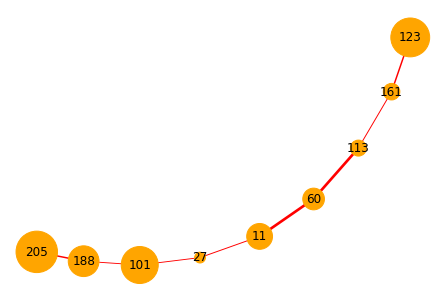

In [426]:
%matplotlib inline
nnodes = len(enes)
upos   = {}
for i, node in enumerate(G.nodes):
    upos[node] = (xpos[2][i], xpos[1][i])
print(xpos)
nx.draw(G, with_labels = True, node_size = 5e3 * np.array(enes), node_color = 'orange',
        edge_color = 'red', width = 5.* enelinks);

In [92]:
help(nx.draw)

Help on function draw in module networkx.drawing.nx_pylab:

draw(G, pos=None, ax=None, **kwds)
    Draw the graph G with Matplotlib.
    
    Draw the graph as a simple representation with no node
    labels or edge labels and using the full Matplotlib figure area
    and no axis labels by default.  See draw_networkx() for more
    full-featured drawing that allows title, axis labels etc.
    
    Parameters
    ----------
    G : graph
       A networkx graph
    
    pos : dictionary, optional
       A dictionary with nodes as keys and positions as values.
       If not specified a spring layout positioning will be computed.
       See :py:mod:`networkx.drawing.layout` for functions that
       compute node positions.
    
    ax : Matplotlib Axes object, optional
       Draw the graph in specified Matplotlib axes.
    
    kwds : optional keywords
       See networkx.draw_networkx() for a description of optional keywords.
    
    Examples
    --------
    >>> G = nx.dodecahedral_gr

In [134]:
cloud.kid[cloud.eisnode == True].values

array([  4,  29,  42,  90, 122, 130, 137])

In [11]:
graph = np.array([[0, 1, 0, 1], [1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 1, 0]])
graph

array([[0, 1, 0, 1],
       [1, 0, 1, 0],
       [0, 1, 0, 1],
       [1, 0, 1, 0]])

In [113]:
nodes  = np.arange(4)
onodes = np.copy(nodes) 
np.random.shuffle(onodes)
print(onodes)
links  = list(zip(nodes, onodes))
links  = [link for link in links if link[0] != link[1]]
print(links)

[2 0 1 3]
[(0, 2), (1, 0), (2, 1)]


In [114]:
#help(nx.Graph)

In [115]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(links)
print(G.nodes)
print(G.edges)
#g = [G[i, j] for i, j in links]

[0, 1, 2, 3]
[(0, 2), (0, 1), (1, 2)]


In [116]:
G1 = nx.minimum_spanning_tree(G)
cycles = nx.cycle_basis(G)
print('number of cycles ', len(cycles))

number of cycles  1


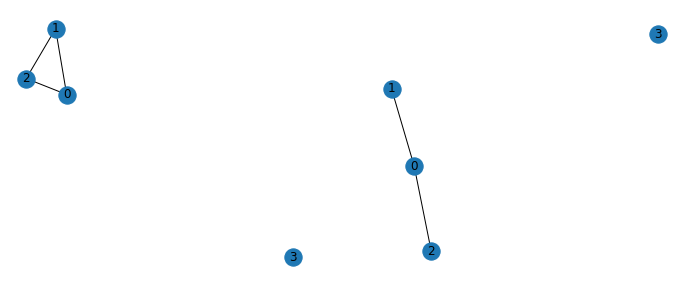

In [117]:
subplot = pltext.canvas(2, 2)
subplot(1)
nx.draw(G, with_labels = True)
subplot(2)
nx.draw(G1, with_labels = True)

In [135]:
#help(G)

In [58]:
print(G.nodes)
print(G.edges)

[0, 1, 2, 3]
[]


In [42]:
print(xgraph)

NameError: name 'xgraph' is not defined

ValueError: too many values to unpack (expected 2)

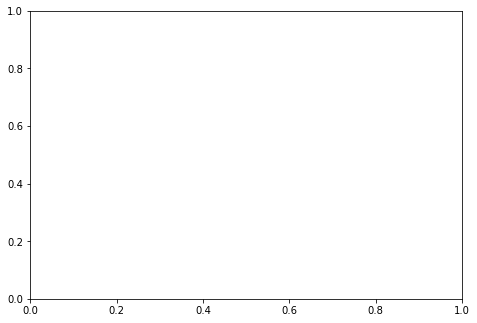

In [30]:
nx.draw(graph, with_labels=True, font_weight='bold')

In [18]:
tree, predecessors = gr.depth_first_order(graph, 0)
print(tree)
print(predecessors)

[0 1 2 3]
[-9999     0     1     2]


In [54]:
#datadir   = "/home/hernando/data/NEW/MC/bb0nu_esmeralda/"
datadir   = "/Users/hernando/work/investigacion/NEXT/data/MC/NEW/ds/"
filenames = ("Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_label_4mm_fid_v0.h5", 
             "Tl208_NEW_v1_03_01_nexus_v5_03_04_cut25.beersheba_label_4mm_fid_v0.h5")
filenames = ("prueba_cut24_prueba_correctlabelling.h5", 
             "prueba_cut25_prueba_correctlabelling.h5")
filenames = ("prueba_cut24_isaura.h5",) 
filenames = [datadir+file for file in filenames]
print('total files', len(filenames))
print(filenames[0])

total files 1
/Users/hernando/work/investigacion/NEXT/data/MC/NEW/ds/prueba_cut24_isaura.h5


In [50]:
def get_dfs(filename):
    
    dfs = {}
    
    dfs['rcvoxels'] = dio.load_dst(filename, 'DATASET', 'BeershebaVoxels')
    dfs['mcvoxels'] = dio.load_dst(filename, 'DATASET', 'MCVoxels')
    dfs['mchits']   = dio.load_dst(filename, 'DATASET', 'MCHits')
    dfs['events']   = dio.load_dst(filename, 'DATASET', 'EventsInfo')
    dfs['bins']     = dio.load_dst(filename, 'DATASET', 'BinsInfo')
    dfs['isaura']   = dio.load_dst(filename, 'DATASET', 'IsauraInfo')

    
    return dfs

In [26]:
dfs, evts = get_dfs(filenames[0])

NameError: name 'get_dfs' is not defined

In [56]:
rcvoxels   = dfs['rcvoxels']
mchits     = dfs['mchits']
isaura     = dfs['isaura']
voxel_size = [float(dfs['bins'][var].unique()) for var in ('size_x', 'size_y', 'size_z')]
print(voxel_size)

[5.0, 5.0, 4.0]


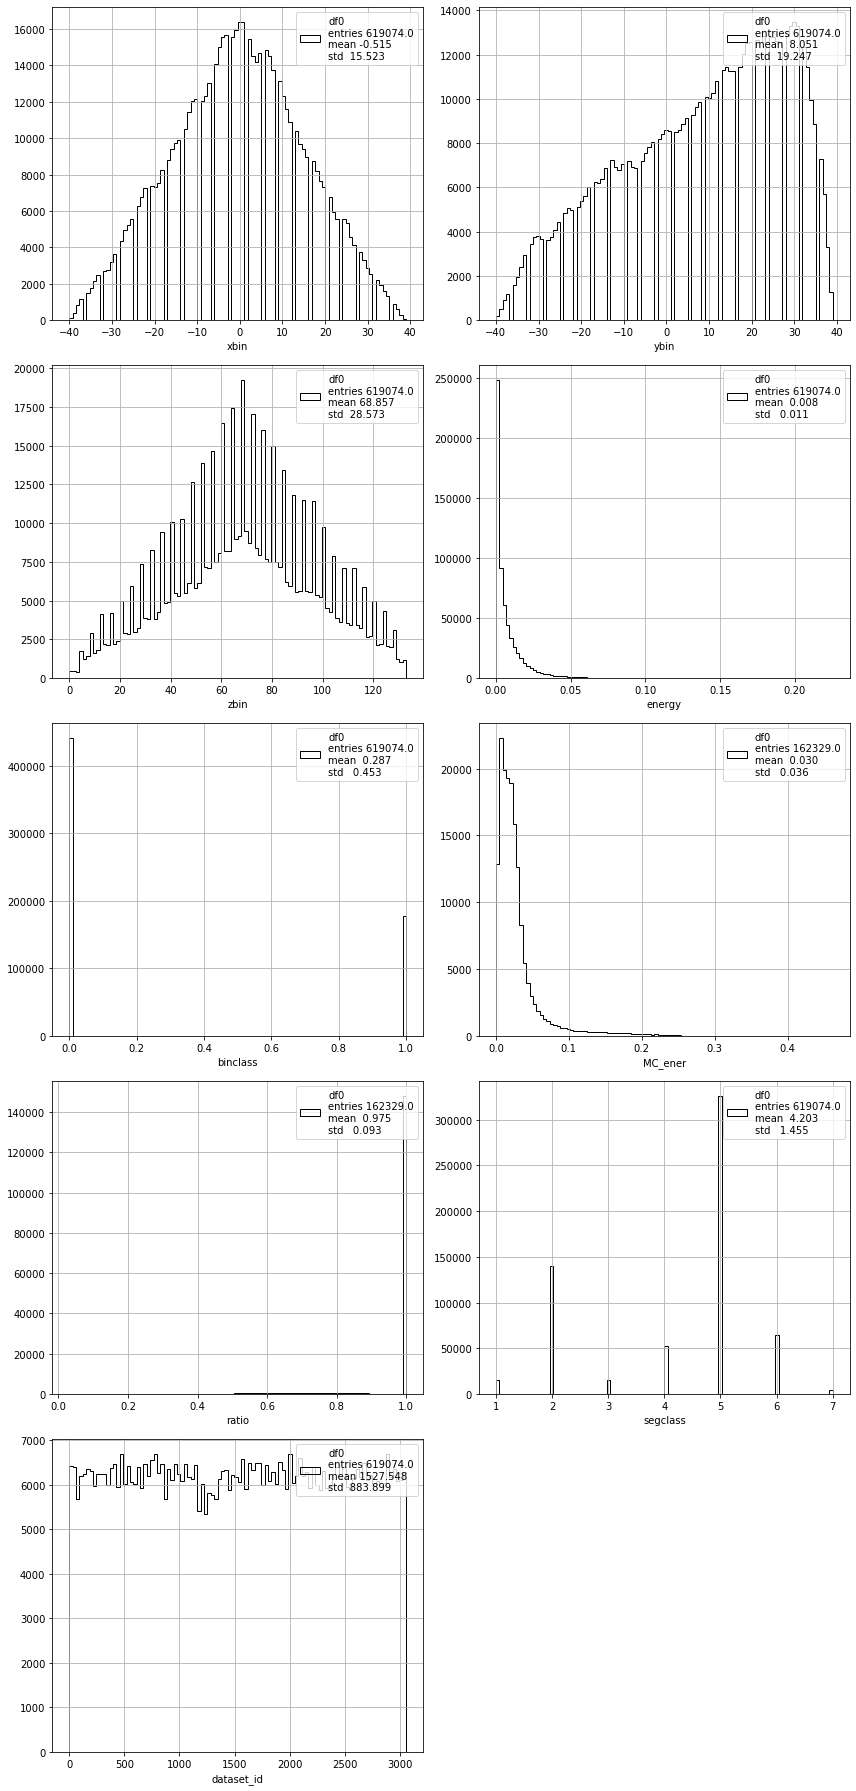

In [57]:
pltext.df_inspect(rcvoxels)

## Run: 

make clouds
ana nodes, are blobs? compute properties of nodes
return df


In [116]:
### Run over the events in the file

def get_eblobs(etracks):
    isablobs = {}
    sel = etracks.trackID == 0
    names = (('x', 'blobi_x'), ('y', 'blobi_y'), ('z', 'blobi_z'), ('energy', 'eblobi'))
    for key, varname in names:
        varnames = [varname.replace('i', i) for i in ['1', '2']]
        var = [float(etracks[varname][sel].values) for varname in varnames]
        isablobs[key] = np.array(var, float)
    eblobs = pd.DataFrame(isablobs)
    #print(eblobs)
    return eblobs

def run(rcvoxels, mchits, isaura, voxel_size, nevents = -1):

    seg_blob = 3
    
    events = rcvoxels['dataset_id'].unique()
    df     = None 
    nevents = len(events) if nevents == -1 else nevents
    print('events to process ', nevents)
    for evt in events[:nevents]:
        
        evoxels    = rcvoxels[rcvoxels.dataset_id == evt]
        ehits      = mchits  [mchits  .dataset_id == evt]
        etracks    = isaura  [isaura  .dataset_id == evt]
        eblobs     = get_eblobs(etracks)
        
        edataclass = int(evoxels.binclass.unique())
        if (evt%100 == 0):
            print('Event :', evt, ', class : ', edataclass)
    
        coors  = [evoxels[var].values for var in ('xbin', 'ybin', 'zbin')]
        coors  = [size * coor for size, coor in zip(voxel_size, coors)]
        ene    = evoxels['energy'].values
        bins, mask, cells, cloud = clouds.clouds(coors, voxel_size, ene)
        cloud['segclass'] = evoxels['segclass'].values
    
        bcell = clouds.cells_value(bins, mask, (eblobs['x'], eblobs['y'], eblobs['z']), eblobs['energy'] )
        cloud['pinablob'] = bcell > 0
        _nodes_pinablobs = cloud.enode[cloud.pinablob].unique()
        #print(_nodes_pinablobs)
    
        sel = cloud['segclass'] == seg_blob
        blob_nodes      = cloud['enode'][sel].unique()
        blob_cell_nodes = (cloud['eisnode'] == True) & (cloud['segclass'] == seg_blob)
        #print('blob nodes ', blob_nodes)
        #print('blob nodes cell ', np.sum(blob_cell_nodes), cloud['kid'][blob_cell_nodes].values)

        # create a DF with the nodes information
        nodes         = cloud['enode'].unique()
        nodes_seg     = np.array([int(cloud['segclass'][node]) for node in nodes])
        nodes_isblob  = np.isin(nodes, blob_nodes)
        nodes_size    = np.array([np.sum(cloud['enode'] == node) for node in nodes])
        nodes_energy  = np.array([np.sum(cloud[cloud['enode'] == node].energy) for node in nodes])
        nodes_enecell = np.array([float(cloud['energy'][node]) for node in nodes])
        nodes_nlinks = [np.sum(cloud[cloud.enode == node]['eispass'] == True) for node in nodes]

        nodes_pinablob = np.isin(nodes, _nodes_pinablobs)
        
        def blob_order(vals, nodes):
            vals, pos = clouds.ut_sort(vals, nodes)
            ipos = [int(np.where(pos == node)[0]) for node in nodes]
            return ipos 

        nodes_osize    = blob_order(nodes_size   , nodes)
        nodes_oenergy  = blob_order(nodes_energy , nodes)
        nodes_oenecell = blob_order(nodes_enecell, nodes)

        nnodes  = len(nodes)
        dfnodes = pd.DataFrame()
        dfnodes['dataset_id'] = np.ones(nnodes, int) * evt
        dfnodes['dataclass']  = np.ones(nnodes, int) * edataclass
        dfnodes['blobs']      = np.ones(nnodes, int) * len(blob_nodes)
        dfnodes['nodes']     = np.arange(nnodes)
        dfnodes['segclass']  = nodes_seg
        dfnodes['isblob']    = nodes_isblob
        dfnodes['size']      = nodes_size
        dfnodes['energy']    = nodes_energy 
        dfnodes['enecell']   = nodes_enecell
        dfnodes['osize']     = nodes_osize
        dfnodes['oenergy']   = nodes_oenergy 
        dfnodes['oenecell']  = nodes_oenecell
        dfnodes['nlinks']    = nodes_nlinks

        dfnodes['pinablob']  = nodes_pinablob
        
        #print(dfnodes)
        
        df = dfnodes if df is None else pd.concat((df, dfnodes), ignore_index = True)
    
    return df

In [120]:
df = run(rcvoxels, mchits, isaura, voxel_size, -1)

events to process  3059
Event : 0 , class :  0
Event : 100 , class :  0
Event : 200 , class :  0
Event : 300 , class :  0
Event : 400 , class :  0
Event : 500 , class :  0
Event : 600 , class :  0
Event : 700 , class :  0
Event : 800 , class :  0
Event : 900 , class :  0
Event : 1000 , class :  0
Event : 1100 , class :  0
Event : 1200 , class :  0
Event : 1300 , class :  0
Event : 1400 , class :  1
Event : 1500 , class :  1
Event : 1600 , class :  1
Event : 1700 , class :  1
Event : 1800 , class :  0
Event : 1900 , class :  0
Event : 2000 , class :  0
Event : 2100 , class :  1
Event : 2200 , class :  0
Event : 2300 , class :  0
Event : 2400 , class :  1
Event : 2500 , class :  0
Event : 2600 , class :  0
Event : 2700 , class :  1
Event : 2800 , class :  0
Event : 2900 , class :  0
Event : 3000 , class :  1


In [121]:
df

dataset_id  dataclass  blobs  nodes  segclass  isblob  size    energy  \
0               0          0      1      0         2   False    31  0.241451   
1               0          0      1      1         2   False    19  0.183784   
2               0          0      1      2         3    True    32  0.440508   
3               0          0      1      3         2   False    24  0.136528   
4               0          0      1      4         1   False    35  0.512597   
...           ...        ...    ...    ...       ...     ...   ...       ...   
26093        3058          0      1      7         2   False    20  0.094515   
26094        3058          0      1      8         2   False    14  0.064707   
26095        3058          0      1      9         7   False     1  0.001043   
26096        3058          0      1     10         1   False    15  0.029648   
26097        3058          0      1     11         4   False    31  0.135622   

        enecell  osize  oenergy  oenecell  nlinks  pinablob  
0      0.031109      2        2         4       2     False  
1      0.046420      5        3         2       2      True  
2      0.066237      1        1         1       1     False  
3      0.017588      3        5         7       2     False  
4      0.075780      0        0         0       2     False  
...         ...    ...      ...       ...     ...       ...  
26093  0.012257      5        6         9       2     False  
26094  0.018739      9        7         6       1     False  
26095  0.001043     11       11        11       0     False  
26096  0.012762      7        9         8       0     False  
26097  0.019730      2        4         4       0     False  

[26098 rows x 14 columns]

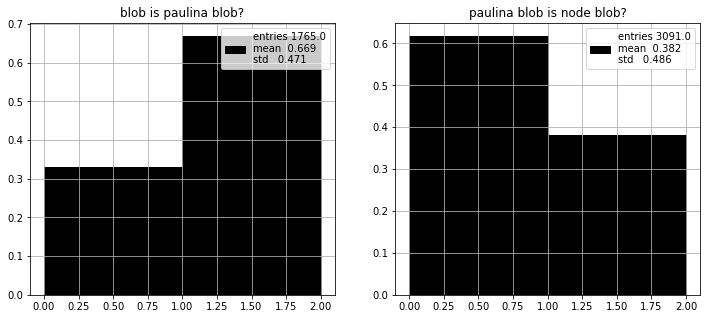

In [129]:
xsel = (df.dataclass == 0) & (df.blobs == 1) & (df.isblob   == True)
ysel = (df.dataclass == 0) & (df.blobs == 1) & (df.pinablob == True)
cd = pltext.canvas(2, 2)
cd(1)
pltext.hist((df.pinablob[xsel].values).astype(int), 2, (0, 2), fill = True, density = True);
plt.title('blob is paulina blob?')
cd(2)
ntot = np.sum(ysel)/2
nsel = (ysel) & (df.isblob == True)
print
pltext.hist((df.isblob  [ysel].values).astype(int), 2, (0, 2), fill = True, density = True);
plt.title('paulina blob is node blob?');

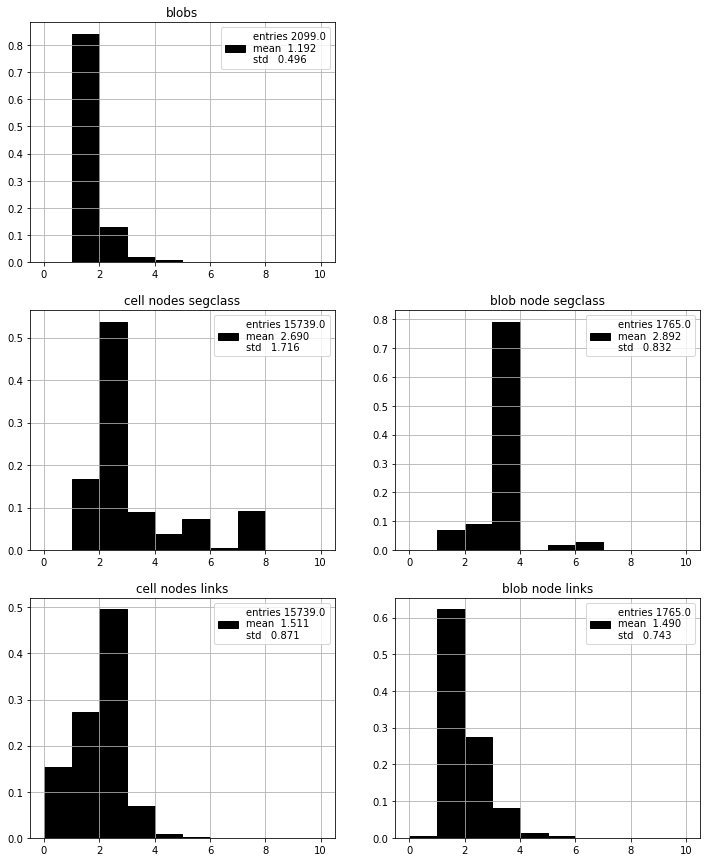

In [15]:
cd = pltext.canvas(6, 2)
cd(1)
plt.title('blobs')
pltext.hist(df['blobs'][(df.dataclass == 0) & (df.osize == 0)], 10, (0, 10), density = True, fill = True);
sel  = (df.dataclass == 0) & (df.blobs == 1)
xsel = (df.dataclass == 0) & (df.isblob == True)  & (df.blobs == 1)
ysel = (df.dataclass == 0) & (df.isblob == False) & (df.blobs == 1)
#print(np.sum(xsel), np.sum(ysel)); 

cd(3); plt.title('cell nodes segclass')
pltext.hist(df['segclass'][sel], 10, (0, 10), density = True, fill = True);
cd(4); plt.title('blob node segclass')
pltext.hist(df['segclass'][xsel], 10, (0, 10), density = True, fill = True); 

cd(5); plt.title('cell nodes links')
pltext.hist(df['nlinks'][sel], 10, (0, 10), density = True, fill = True);
cd(6); plt.title('blob node links')
pltext.hist(df['nlinks'][xsel], 10, (0, 10), density = True, fill = True); 

In [20]:
def _sel_events(sel):
    return df['dataset_id'][sel].unique()

selevents = {}

zsel = (df.dataclass == 0) & (df.blobs != 1)
selevents['e, nblobs > 1'] = _sel_events(zsel)

zsel = (df.dataclass == 0) & (df.blobs == 1) & (df.isblob == True) & (df.segclass != 3)
selevents['e, nblobs == 1, segclass != blob'] = _sel_events(zsel)

zsel = (df.dataclass == 0) & (df.blobs == 1) & (df.isblob == True) & (df.nlinks != 1)
selevents['e, nblobs == 1, nlinks != 1'] = _sel_events(zsel)

order size  [7.15014164e+01 2.07365439e+01 5.21246459e+00 1.92634561e+00
 3.96600567e-01 1.69971671e-01 0.00000000e+00 5.66572238e-02
 0.00000000e+00 0.00000000e+00]
order energy  [87.25212465 11.16147309  1.41643059  0.16997167  0.          0.
  0.          0.          0.          0.        ]
order energy cell  [8.27195467e+01 1.41643059e+01 2.71954674e+00 3.39943343e-01
 5.66572238e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


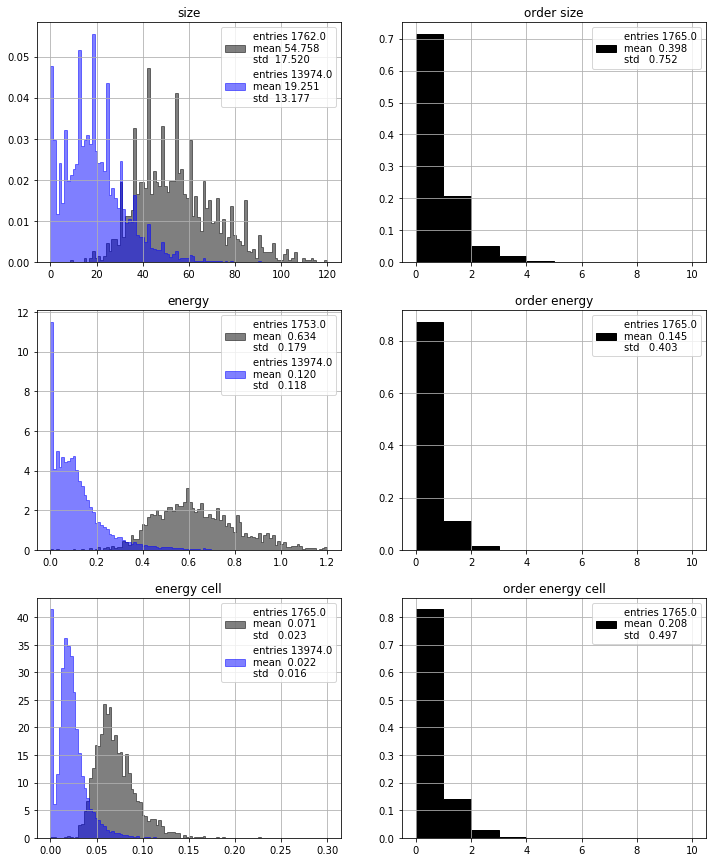

In [21]:
xsel = (df.dataclass == 0) & (df.isblob == True)  & (df.blobs == 1)
ysel = (df.dataclass == 0) & (df.isblob == False) & (df.blobs == 1)
#print(np.sum(xsel), np.sum(ysel)); 

cd = pltext.canvas(6, 2)
cd(1); plt.title('size');
pltext.hist(df['size'][xsel], 100, (0, 120), density = True, fill = True, alpha = 0.5);
pltext.hist(df['size'][ysel], 100, (0, 120), density = True, fill = True, alpha = 0.5);
cd(2); plt.title('order size');
pltext.hist(df['osize'][xsel], 10, (0, 10), density = True, fill = True);
counts, _  = np.histogram(df['osize'][xsel], 10, (0, 10), density = True)
print('order size ', 100*counts)

cd(3); plt.title('energy');
pltext.hist(df['energy'][xsel], 100, (0, 1.2), density = True, fill = True, alpha = 0.5);
pltext.hist(df['energy'][ysel], 100, (0, 1.2), density = True, fill = True, alpha = 0.5);
cd(4); plt.title('order energy');
pltext.hist(df['oenergy'][xsel], 10, (0, 10), density = True, fill = True);
counts, _  = np.histogram(df['oenergy'][xsel], 10, (0, 10), density = True)
print('order energy ', 100*counts)

cd(5); plt.title('energy cell');
pltext.hist(df['enecell'][xsel], 100, (0, 0.3), density = True, fill = True, alpha = 0.5);
pltext.hist(df['enecell'][ysel], 100, (0, 0.3), density = True, fill = True, alpha = 0.5);
cd(6); plt.title('order energy cell');
pltext.hist(df['oenecell'][xsel], 10, (0, 10), density = True, fill = True);
counts, _  = np.histogram(df['oenecell'][xsel], 10, (0, 10), density = True)
print('order energy cell ', 100*counts)


In [41]:
zsel = (df.dataclass == 0) & (df.blobs == 1) & (df.isblob == True) & (df.oenergy >0)
selevents['e, nblobs == 1, oenergy > 0'] = _sel_events(zsel)

zsel = (df.dataclass == 0) & (df.blobs == 1) & (df.isblob == True) & (df.nlinks == 1) & (df.oenergy == 0)
selevents['e, nblobs == 1, nlinks == 1, oenergy == 0'] = _sel_events(zsel)

zsel = (df.dataclass == 0) & (df.blobs == 1) & (df.isblob == True) & (df.nlinks == 1) & (df.oenergy  > 0) 
selevents['e, nblobs == 1, nlinks == 1, oenergy > 0'] = _sel_events(zsel)

zsel = (df.dataclass == 0) & (df.blobs == 1) & (df.isblob == True) & (df.nlinks >  1) & (df.oenergy == 0) 
selevents['e, nblobs == 1, nlinks > 1, oenergy == 0'] = _sel_events(zsel)

zsel = (df.dataclass == 0) & (df.blobs == 1) & (df.isblob == True) & (df.nlinks > 1) & (df.oenergy >  0)
selevents['e, nblobs == 1, nlinks > 1, oenergy > 0'] = _sel_events(zsel)


ntot = len(df.dataset_id[df.dataclass == 0].unique())
n1e  = len(df.dataset_id[(df.blobs == 1) & (df.dataclass == 0)].unique())
print('total e = ', ntot)
print('total e, nblobs == 1', n1e)
for name in selevents.keys():
    nsel = len(selevents[name])
    ndeno = ntot if name == 'e, nblobs > 1' else n1e
    print(name, ' = ', nsel, ', eff = ', 100 * float(nsel)/n1e, '%')

total e =  2099
total e, nblobs == 1 1765
e, nblobs > 1  =  334 , eff =  18.923512747875353 %
e, nblobs == 1, segclass != blob  =  367 , eff =  20.793201133144475 %
e, nblobs == 1, nlinks != 1  =  667 , eff =  37.79036827195468 %
e, nblobs == 1, oenergy > 0  =  225 , eff =  12.747875354107649 %
e, nblobs == 1, nlinks > 1, oenergy > 0  =  66 , eff =  3.7393767705382435 %
e, nblobs == 1, nlinks == 1, oenergy == 0  =  941 , eff =  53.314447592067985 %
e, nblobs == 1, nlinks == 1, oenergy > 0  =  157 , eff =  8.895184135977336 %
e, nblobs == 1, nlinks > 1, oenergy == 0  =  593 , eff =  33.59773371104816 %


In [46]:
for name in selevents:
    print('selevents["'+ name,'"] = ', tuple(selevents[name])[:20])

selevents["e, nblobs > 1 "] =  (1, 4, 28, 33, 42, 48, 51, 61, 68, 120, 135, 145, 146, 153, 175, 181, 184, 185, 187, 201)
selevents["e, nblobs == 1, segclass != blob "] =  (8, 10, 12, 14, 17, 26, 30, 31, 32, 49, 59, 77, 81, 85, 88, 96, 104, 119, 121, 125)
selevents["e, nblobs == 1, nlinks != 1 "] =  (3, 5, 6, 11, 14, 18, 22, 30, 32, 36, 45, 49, 50, 52, 53, 57, 60, 62, 74, 75)
selevents["e, nblobs == 1, oenergy > 0 "] =  (0, 2, 8, 16, 21, 34, 85, 142, 164, 170, 177, 199, 207, 231, 232, 246, 250, 255, 256, 261)
selevents["e, nblobs == 1, nlinks > 1, oenergy > 0 "] =  (199, 246, 255, 256, 263, 301, 323, 326, 347, 370, 380, 502, 535, 565, 657, 689, 692, 698, 702, 777)
selevents["e, nblobs == 1, nlinks == 1, oenergy == 0 "] =  (10, 12, 15, 17, 20, 24, 25, 26, 31, 35, 40, 47, 56, 59, 63, 67, 69, 70, 71, 79)
selevents["e, nblobs == 1, nlinks == 1, oenergy > 0 "] =  (0, 2, 8, 16, 21, 34, 85, 142, 164, 170, 177, 207, 231, 232, 250, 261, 330, 334, 408, 440)
selevents["e, nblobs == 1, nlinks > 1, 

In [26]:
xsel = (df.dataclass == 0) & (df.isblob == True)  & (df.blobs == 1)

name = 'extreme, most energetic'
zsel = (xsel) & (df.nlinks == 1) & (df.oenergy == 0)
ids  =  df['dataset_id'][zsel].unique()
print(name, ids[:15])

name = 'extreme, not most energetic'
zsel = (xsel) & (df.nlinks == 1) & (df.oenergy > 0)
ids  =  df['dataset_id'][zsel].unique()
print(name, ids[:15])

name = 'no extreme, most energetic'
zsel = (xsel) & (df.nlinks > 1) & (df.oenergy == 0)
ids  =  df['dataset_id'][zsel].unique()
print(name, ids[:15])

name = 'no extreme, no most energetic'
zsel = (xsel) & (df.nlinks > 1) & (df.oenergy > 0)
ids  =  df['dataset_id'][zsel].unique()
print(name, ids[:15])

name = 'blob in the chain, most energetic'
zsel = (xsel) & (df.nlinks == 2) & (df.oenergy == 0)
ids  =  df['dataset_id'][zsel].unique()
print(name, ids[:15])

name = 'blob in the chain, not most energetic'
zsel = (xsel) & (df.nlinks == 2) & (df.oenergy > 0)
ids  =  df['dataset_id'][zsel].unique()
print(name, ids[:15])

name = 'blob in xroad, most energetic'
zsel = (xsel) & (df.nlinks > 2) & (df.oenergy == 0)
ids  =  df['dataset_id'][zsel].unique()
print(name, ids[:15])

name = 'blob in xroad, not most energetic'
zsel = (xsel) & (df.nlinks > 2) & (df.oenergy > 0)
ids  =  df['dataset_id'][zsel].unique()
print(name, ids[:15])

name = 'cell of node blob is not blob'
zsel = (xsel) & (df.segclass != 3)
ids  =  df['dataset_id'][zsel].unique()
print(name, ids[:15])

extreme, most energetic [10 12 15 17 20 24 25 26 31 35 40 47 56 59 63]
extreme, not most energetic [  0   2   8  16  21  34  85 142 164 170 177 207 231 232 250]
no extreme, most energetic [ 3  5  6 11 14 18 22 30 32 36 45 49 50 52 53]
no extreme, no most energetic [199 246 255 256 263 301 323 326 347 370 380 502 535 565 657]
blob in the chain, most energetic [ 5  6 11 14 18 22 30 32 49 52 53 57 60 75 77]
blob in the chain, not most energetic [199 246 255 256 263 323 326 347 370 502 535 565 657 689 692]
blob in xroad, most energetic [  3  36  45  50  74  88 103 107 113 115 117 119 138 160 179]
blob in xroad, not most energetic [ 301  380  944 1095 1220 1635 1657 1941 2111 2151 2204 2209 2334 2513
 2658]
cell of node blob is not blob [ 8 10 12 14 17 26 30 31 32 49 59 77 81 85 88]


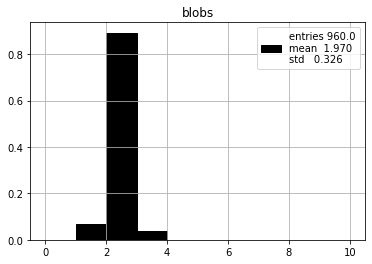

In [27]:
plt.title('blobs')
pltext.hist(df['blobs'][(df.dataclass == 1) & (df.osize == 0)], 10, (0, 10), density = True, fill = True);

order size  [42.59043174 33.19719953 14.99416569  5.65927655  2.27537923  0.75845974
  0.4084014   0.          0.05834306  0.05834306]
order energy  [46.49941657 40.95682614  9.33488915  2.15869312  0.46674446  0.35005834
  0.11668611  0.          0.11668611  0.        ]
order energy cell  [46.67444574 41.01516919  9.56826138  2.042007    0.35005834  0.23337223
  0.          0.05834306  0.          0.05834306]


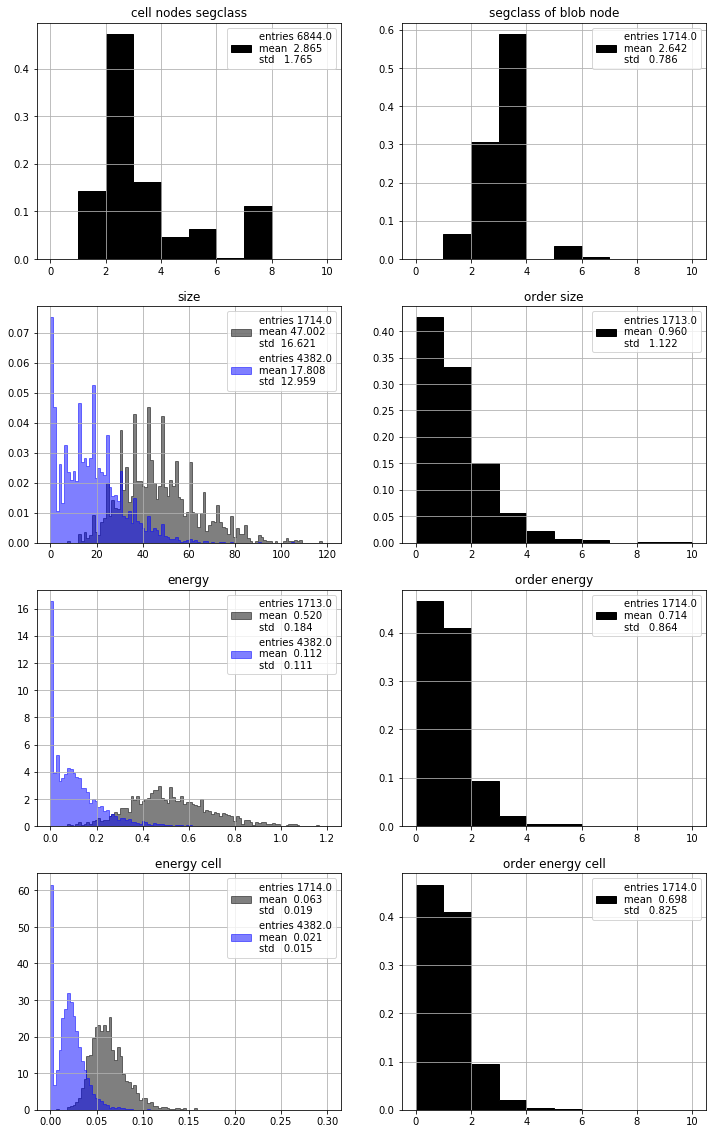

In [28]:
xsel = (df.dataclass == 1) & (df.isblob == True)  & (df.blobs == 2)
ysel = (df.dataclass == 1) & (df.isblob == False) & (df.blobs == 2)
#print(np.sum(xsel), np.sum(ysel)); 
cd = pltext.canvas(7, 2)
cd(1); plt.title('cell nodes segclass')
pltext.hist(df['segclass'][df.dataclass == 1], 10, (0, 10), density = True, fill = True);
cd(2); plt.title('segclass of blob node')
pltext.hist(df['segclass'][xsel], 10, (0, 10), density = True, fill = True); 

cd(3); plt.title('size');
pltext.hist(df['size'][xsel], 100, (0, 120), density = True, fill = True, alpha = 0.5);
pltext.hist(df['size'][ysel], 100, (0, 120), density = True, fill = True, alpha = 0.5);
cd(4); plt.title('order size');
pltext.hist(df['osize'][xsel], 10, (0, 10), density = True, fill = True);
counts, _  = np.histogram(df['osize'][xsel], 10, (0, 10), density = True)
print('order size ', 100*counts)

cd(5); plt.title('energy');
pltext.hist(df['energy'][xsel], 100, (0, 1.2), density = True, fill = True, alpha = 0.5);
pltext.hist(df['energy'][ysel], 100, (0, 1.2), density = True, fill = True, alpha = 0.5);
cd(6); plt.title('order energy');
pltext.hist(df['oenergy'][xsel], 10, (0, 10), density = True, fill = True);
counts, _  = np.histogram(df['oenergy'][xsel], 10, (0, 10), density = True)
print('order energy ', 100*counts)

cd(7); plt.title('energy cell');
pltext.hist(df['enecell'][xsel], 100, (0, 0.3), density = True, fill = True, alpha = 0.5);
pltext.hist(df['enecell'][ysel], 100, (0, 0.3), density = True, fill = True, alpha = 0.5);
cd(8); plt.title('order energy cell');
pltext.hist(df['oenecell'][xsel], 10, (0, 10), density = True, fill = True);
counts, _  = np.histogram(df['oenecell'][xsel], 10, (0, 10), density = True)
print('order energy cell ', 100*counts)


## Conclusions

 * Why there are electrons events with no-blobs? => are electrons from photo-electric [] repare labelling  
 
 * Why there are 2 electrons events with 1 blob? => 2nd electron with low energy, [] repare labelling!!
 
 * What are the electron events with > 1 blob? 
 
 * What are the 2 electrons events with > 2 blobs?
 
 * For the good electrons events (blob == electron): 87%(98%) of the cases the blob in in the most (two most) energetic nodes
 
 * For the good 2 electrons events (blobs == electrons): 90%(97%) of the cases the 2 blobs are the 2(3) most energetic.

In [29]:
xsel  = (df['dataclass'] == 0) & (df['blobs'] == 0)
xevts = df['dataset_id'][xsel].unique()
print('events 1 e, blobs < 1 ', xevts[:18])
xsel  = (df['dataclass'] == 0) & (df['blobs'] > 1)
xevts = df['dataset_id'][xsel].unique()
print('events 1 e, blobs > 1 ', xevts[:18])

xsel  = (df['dataclass'] == 1) & (df['blobs'] < 2)
xevts = df['dataset_id'][xsel].unique()
print('events 2 e, < 2 blobs ', xevts[:18])
xsel  = (df['dataclass'] == 1) & (df['blobs'] > 2)
xevts = df['dataset_id'][xsel].unique()
print('events 2 e, blobs > 2 ', xevts[:18])


events 1 e, blobs < 1  [ 931 1102 2936]
events 1 e, blobs > 1  [  1   4  28  33  42  48  51  61  68 120 135 145 146 153 175 181 184 185]
events 2 e, < 2 blobs  [  37  110  242  309  413  420  531  567  571  575  616  686  707  866
 1032 1069 1087 1089]
events 2 e, blobs > 2  [ 197  358  632  682  715  731  750  787  966 1038 1158 1167 1190 1221
 1243 1250 1259 1263]
